<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tests-LSTM+GRU" data-toc-modified-id="Tests-LSTM+GRU-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tests LSTM+GRU</a></span></li><li><span><a href="#Tests-1D-CNN" data-toc-modified-id="Tests-1D-CNN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tests 1D CNN</a></span></li><li><span><a href="#Hyperparameter-Tunning-3-1D-CNN-Layers" data-toc-modified-id="Hyperparameter-Tunning-3-1D-CNN-Layers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hyperparameter Tunning 3 1D CNN Layers</a></span></li><li><span><a href="#Hyperparameter-Tunning-2-1D-CNN-Layers" data-toc-modified-id="Hyperparameter-Tunning-2-1D-CNN-Layers-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hyperparameter Tunning 2 1D CNN Layers</a></span></li><li><span><a href="#Realtime-Code-Prediction" data-toc-modified-id="Realtime-Code-Prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Realtime Code Prediction</a></span></li><li><span><a href="#Test-2-1D-CNN-Layers-+-3-GRU-Layers" data-toc-modified-id="Test-2-1D-CNN-Layers-+-3-GRU-Layers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Test 2 1D CNN Layers + 3 GRU Layers</a></span></li><li><span><a href="#Hyperparameter-Tunning-2-1D-CNN-Layers-+-3-GRU" data-toc-modified-id="Hyperparameter-Tunning-2-1D-CNN-Layers-+-3-GRU-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Hyperparameter Tunning 2 1D CNN Layers + 3 GRU</a></span></li><li><span><a href="#Hyperparameter-Tuning-3-GRU-Layers" data-toc-modified-id="Hyperparameter-Tuning-3-GRU-Layers-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Hyperparameter Tuning 3 GRU Layers</a></span></li><li><span><a href="#Hyperparameter-Tuning-3-LSTM-Layers" data-toc-modified-id="Hyperparameter-Tuning-3-LSTM-Layers-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Hyperparameter Tuning 3 LSTM Layers</a></span></li><li><span><a href="#Hyperparameter-Tuning-4-1D-CNN-Layers" data-toc-modified-id="Hyperparameter-Tuning-4-1D-CNN-Layers-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Hyperparameter Tuning 4 1D CNN Layers</a></span></li></ul></div>

In [1]:
import mediapipe as mp
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import gc
from operator import add

2023-08-23 23:38:18.600496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 23:38:24.779704: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/kristian/miniconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

In [153]:
#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/videos/876528433251724-SQUEEZE.mp4')

with mp_holistic.Holistic(static_image_mode=False,
                          model_complexity=1) as holistic:
    while True:
        ret, frame = cap.read()
        if ret == False:
            break
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)
        # Left hand
        mp_drawing.draw_landmarks(
            frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))

        # Right Hand
        mp_drawing.draw_landmarks(
            frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))
        frame = cv2.flip(frame, 1)
        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break
cap.release()
cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [163]:
results

mediapipe.python.solution_base.SolutionOutputs

In [164]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [165]:
#pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
#face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [3]:
def extract_keypoints(results):
#    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [167]:
result_test = extract_keypoints(results)

In [168]:
result_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [4]:
def signvideodataframe(filepath):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filepath)

    # Define the path to the videos directory
    path = 'file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/videos/'

    # Create a 'Path' column by concatenating the path with 'Video file' column
    df['Path'] = path + df['Video file']
    
    # Calculate the frequency of each gloss and create a 'frequency' column
    df['Frequency'] = df['Gloss'].map(df['Gloss'].value_counts())

    # Sort the DataFrame by the 'Gloss' column
    df = df.sort_values(by='Gloss')

    # Reset the index of the DataFrame
    df = df.reset_index(drop=True)

    return df

In [5]:
traindf = signvideodataframe('file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/splits/train.csv')

In [6]:
traindf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P31,3827306090663467-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
1,P37,16792698524451422-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
2,P11,6868778695018762-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
3,P11,6870709051348651-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
4,P50,0719792557216079-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15


In [7]:
traindf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
40149,P37,9716493262876276-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
40150,P31,7550572181460327-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
40151,P46,47985881750082227-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
40152,P50,04671245574824856-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
40153,P51,19959052532136146-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15


In [8]:
traindf['Path'][0]

'file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/videos/3827306090663467-1 DOLLAR.mp4'

In [174]:
cap = cv2.VideoCapture(traindf['Path'][0])
#cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(static_image_mode=False,
                          model_complexity=1) as holistic:
    while True:
        ret, frame = cap.read()
        if ret == False:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)
        # Left hand
        mp_drawing.draw_landmarks(
            frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))

        # Right Hand
        mp_drawing.draw_landmarks(
            frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))

        frame = cv2.flip(frame, 1)
        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break
cap.release()
cv2.destroyAllWindows()

In [175]:
traindf.sample(20)

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
3028,P37,41775128552545326-BIRTHDAY.mp4,BIRTHDAY,D_01_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
31945,P11,4196732067344118-SNAIL.mp4,SNAIL,G_01_067,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,14
8896,P29,36433499886746423-DELEGATE.mp4,DELEGATE,H_03_001,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
4777,P31,4634164353032284-CAKE.mp4,CAKE,D_01_033,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,16
24376,P16,8628112408945923-OUTSIDE.mp4,OUTSIDE,E_03_071,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
37902,P33,6353213788072032-VISITOR.mp4,VISITOR,J_01_097,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
25118,P31,47043528831020653-PEEKABOO.mp4,PEEKABOO,E_02_026,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,17
10473,P11,03909923207087029-DROP.mp4,DROP,C_03_052,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
3262,P11,08568928378144558-BLINDS 2.mp4,BLINDS2,C_03_014,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,16
35647,P33,6089188553523701-THINK CONNECT.mp4,THINKCONNECT,F_02_087,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,14


In [176]:
traindf.describe()

,Frequency
count,40154.000000
mean,14.819893
std,1.317383
min,9.000000
25%,14.000000
50%,15.000000
75%,16.000000
max,24.000000


In [9]:
words = traindf.groupby(['Gloss'], sort=True)['Frequency'].count().sort_values(ascending=False).reset_index()
words.head(50)

,Gloss,Frequency
0,DOG1,24
1,HURDLE/TRIP1,22
2,BITE1,21
3,BREAKFAST1,21
4,DEMAND1,21
5,DARK1,21
6,MECHANIC1,20
7,PARTY1,20
8,DECIDE1,20
9,WHATFOR1,20


In [178]:
import plotly.express as px

fig = px.histogram(words,
                    x='Frequency',
                    color_discrete_sequence=px.colors.sequential.Oranges_r,
                    title='Frequency Data Distribution In Training Dataframe')

fig.show()

In [10]:
traindf = traindf[traindf['Gloss'].isin(words.Gloss.head(50))]
traindf=traindf.reset_index(drop=True)

In [180]:
traindf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P52,07157565148825373-seedAXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,19
1,P28,7179300005186042-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,19
2,P29,16216064841959765-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,19
3,P37,6193814382865199-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,19
4,P40,5947453960317015-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,19


In [181]:
traindf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
945,P50,9161417844146778-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,20
946,P14,00930662603221255-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,20
947,P27,82063651021682-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,20
948,P40,5268072837528903-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,20
949,P40,6363286086951516-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,20


In [182]:
words = traindf.groupby(['Gloss'], sort=True)['Frequency'].count().sort_values(ascending=False).reset_index()
words.head(100)

,Gloss,Frequency
0,DOG1,24
1,HURDLE/TRIP1,22
2,DARK1,21
3,BITE1,21
4,BREAKFAST1,21
5,DEMAND1,21
6,DEAF1,20
7,MECHANIC1,20
8,DECIDE1,20
9,WHATFOR1,20


In [183]:
import plotly.express as px

fig = px.histogram(words,
                    x='Frequency',
                    color_discrete_sequence=px.colors.sequential.Oranges_r,
                    title='Frequency Data Distribution In Training Dataframe Top 50 Words')

fig.show()

In [184]:
traindf.describe()

,Frequency
count,950.000000
mean,19.082105
std,1.316026
min,18.000000
25%,18.000000
50%,19.000000
75%,20.000000
max,24.000000


In [185]:
#traindf['Gloss'] = traindf['Gloss'].str.replace('\d+', '',regex=True)

In [186]:
traindf['Gloss'].nunique()

50

In [187]:
words = traindf['Gloss'].unique()
words

array(['AXE1', 'BACKPACK1', 'BASKETBALL1', 'BEE1', 'BELT1', 'BITE1',
       'BREAKFAST1', 'CANCER1', 'CHRISTMAS1', 'CONFUSED1', 'DARK1',
       'DEAF1', 'DECIDE1', 'DEMAND1', 'DEVELOP1', 'DINNER1', 'DOG1',
       'DOWNSIZE1', 'DRAG1', 'EAT1', 'EDIT1', 'ELEVATOR1', 'FINE1',
       'FLOAT1', 'FOREIGNER1', 'GUESS1', 'HALLOWEEN1', 'HOSPITAL1',
       'HURDLE/TRIP1', 'JEWELRY', 'KNIGHT1', 'LOCK1', 'LUNCH1', 'MAPLE',
       'MEAT1', 'MECHANIC1', 'MICROSCOPE1', 'MOVIE1', 'NOON1', 'PARTY1',
       'PATIENT2', 'RAZOR2', 'RIVER1', 'ROCKINGCHAIR1', 'SHAVE1', 'SINK',
       'SQUEEZE', 'THEY1', 'TWINS1', 'WHATFOR1'], dtype=object)

In [188]:
valdf = signvideodataframe('file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/splits/val.csv') 

In [189]:
valdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P26,22595012150860327-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,3
1,P39,7421622940519235-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,3
2,P21,686738356933241-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,3
3,P12,9219095671540121-5 DOLLARS.mp4,5DOLLARS,B_01_062,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
4,P21,1448188216215387-5 DOLLARS.mp4,5DOLLARS,B_01_062,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4


In [190]:
valdf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
10299,P21,6959326205750493-ZOOM IN.mp4,ZOOMIN,B_02_056,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,3
10300,P12,7758716133684984-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
10301,P39,844134294032034-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
10302,P21,5548062993721732-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
10303,P26,19366754134806952-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4


In [191]:
testdf = signvideodataframe('file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/splits/test.csv')

In [192]:
testdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P18,23521769221811684-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,13
1,P42,023931338852502426-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,13
2,P49,4893817008748198-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,13
3,P17,13991818149960333-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,13
4,P49,34625615110480457-1 DOLLAR.mp4,1DOLLAR,C_02_025,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,13


In [193]:
testdf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
32936,P18,4320702510886756-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,13
32937,P9,7676354653247301-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,13
32938,P47,5386272465310649-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,13
32939,P18,738440364224181-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,13
32940,P17,9953298353288469-ZOOM OFF.mp4,ZOOMOFF,D_01_057,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,13


In [194]:
valdf = valdf[valdf['Gloss'].isin(words)]
valdf = valdf.reset_index(drop=True)

In [195]:
valdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P39,19778675091674147-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
1,P26,8581142177964065-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
2,P39,3877478645046861-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
3,P21,8521417940364975-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
4,P5,9990244640190733-BACKPACK.mp4,BACKPACK1,G_03_091,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,3


In [196]:
valdf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
186,P26,032677896012150764-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,5
187,P5,6523145816470133-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,5
188,P39,0283886564670357-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,5
189,P21,6142521746642153-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,5
190,P12,06408604416165864-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,5


In [197]:
valdf['Gloss'].nunique()

50

In [198]:
valdf.describe()

,Frequency
count,191.000000
mean,3.963351
std,0.770316
min,3.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,6.000000


In [199]:
valdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P39,19778675091674147-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
1,P26,8581142177964065-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
2,P39,3877478645046861-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
3,P21,8521417940364975-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4
4,P5,9990244640190733-BACKPACK.mp4,BACKPACK1,G_03_091,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,3


In [200]:
fig = px.histogram(valdf.groupby(['Gloss'], sort=True)['Frequency'].count().sort_values(ascending=False).reset_index(),
                    x='Frequency',
                    color_discrete_sequence=px.colors.sequential.Oranges_r,
                    title='Frequency Data Distribution In Validation Dataframe Top 50 Words')

fig.show()

In [201]:
testdf = testdf[testdf['Gloss'].isin(words)]
testdf = testdf.reset_index(drop=True)

In [202]:
testdf['Gloss'].nunique()

50

In [203]:
testdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
0,P15,33721516025652254-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
1,P47,519067006979435-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
2,P35,5104381603195376-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
3,P42,44458614013793873-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15
4,P42,9604797909481075-AXE.mp4,AXE1,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,15


In [204]:
testdf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
724,P42,3448123355846451-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18
725,P47,034046510887022485-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18
726,P22,9359050586202402-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18
727,P42,2748457214117681-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18
728,P15,540014801916062-WHAT FOR.mp4,WHATFOR1,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18


In [205]:
testdf.describe()

,Frequency
count,729.000000
mean,14.978052
std,2.229192
min,9.000000
25%,14.000000
50%,15.000000
75%,16.000000
max,20.000000


In [206]:
fig = px.histogram(testdf.groupby(['Gloss'], sort=True)['Frequency'].count().sort_values(ascending=False).reset_index(),
                    x='Frequency',
                    color_discrete_sequence=px.colors.sequential.Oranges_r,
                    title='Frequency Data Distribution In Test Dataframe Top 50 Words', nbins=20)

fig.show()

In [207]:
valdf['Gloss'] = valdf['Gloss'].str.replace('\d+', '',regex=True)
testdf['Gloss'] = testdf['Gloss'].str.replace('\d+', '',regex=True)

In [11]:
traindf['Gloss'] = traindf['Gloss'].str.replace('\d+', '',regex=True)

In [208]:
words = traindf['Gloss'].unique()
words

array(['AXE', 'BACKPACK', 'BASKETBALL', 'BEE', 'BELT', 'BITE',
       'BREAKFAST', 'CANCER', 'CHRISTMAS', 'CONFUSED', 'DARK', 'DEAF',
       'DECIDE', 'DEMAND', 'DEVELOP', 'DINNER', 'DOG', 'DOWNSIZE', 'DRAG',
       'EAT', 'EDIT', 'ELEVATOR', 'FINE', 'FLOAT', 'FOREIGNER', 'GUESS',
       'HALLOWEEN', 'HOSPITAL', 'HURDLE/TRIP', 'JEWELRY', 'KNIGHT',
       'LOCK', 'LUNCH', 'MAPLE', 'MEAT', 'MECHANIC', 'MICROSCOPE',
       'MOVIE', 'NOON', 'PARTY', 'PATIENT', 'RAZOR', 'RIVER',
       'ROCKINGCHAIR', 'SHAVE', 'SINK', 'SQUEEZE', 'THEY', 'TWINS',
       'WHATFOR'], dtype=object)

In [209]:
words = valdf['Gloss'].unique()
words

array(['AXE', 'BACKPACK', 'BASKETBALL', 'BEE', 'BELT', 'BITE',
       'BREAKFAST', 'CANCER', 'CHRISTMAS', 'CONFUSED', 'DARK', 'DEAF',
       'DECIDE', 'DEMAND', 'DEVELOP', 'DINNER', 'DOG', 'DOWNSIZE', 'DRAG',
       'EAT', 'EDIT', 'ELEVATOR', 'FINE', 'FLOAT', 'FOREIGNER', 'GUESS',
       'HALLOWEEN', 'HOSPITAL', 'HURDLE/TRIP', 'JEWELRY', 'KNIGHT',
       'LOCK', 'LUNCH', 'MAPLE', 'MEAT', 'MECHANIC', 'MICROSCOPE',
       'MOVIE', 'NOON', 'PARTY', 'PATIENT', 'RAZOR', 'RIVER',
       'ROCKINGCHAIR', 'SHAVE', 'SINK', 'SQUEEZE', 'THEY', 'TWINS',
       'WHATFOR'], dtype=object)

In [210]:
words = testdf['Gloss'].unique()
words

array(['AXE', 'BACKPACK', 'BASKETBALL', 'BEE', 'BELT', 'BITE',
       'BREAKFAST', 'CANCER', 'CHRISTMAS', 'CONFUSED', 'DARK', 'DEAF',
       'DECIDE', 'DEMAND', 'DEVELOP', 'DINNER', 'DOG', 'DOWNSIZE', 'DRAG',
       'EAT', 'EDIT', 'ELEVATOR', 'FINE', 'FLOAT', 'FOREIGNER', 'GUESS',
       'HALLOWEEN', 'HOSPITAL', 'HURDLE/TRIP', 'JEWELRY', 'KNIGHT',
       'LOCK', 'LUNCH', 'MAPLE', 'MEAT', 'MECHANIC', 'MICROSCOPE',
       'MOVIE', 'NOON', 'PARTY', 'PATIENT', 'RAZOR', 'RIVER',
       'ROCKINGCHAIR', 'SHAVE', 'SINK', 'SQUEEZE', 'THEY', 'TWINS',
       'WHATFOR'], dtype=object)

In [211]:
print(traindf['Gloss'].nunique())
print(valdf['Gloss'].nunique())
print(testdf['Gloss'].nunique())

50
50
50


In [212]:
traintest = pd.concat([traindf,testdf])
traintest['Frequency'] = traintest['Gloss'].map(traintest['Gloss'].value_counts())
traintest = traintest.sort_values(by='Gloss')

traintest = traintest.reset_index(drop=True)

In [213]:
traintest.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency
1674,P37,8639087490010726-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,38
1675,P40,6445331634562388-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,38
1676,P37,6237575353180616-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,38
1677,P11,9697621013006055-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,38
1678,P15,540014801916062-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,38


In [214]:
traintest.describe()

,Frequency
count,1679.000000
mean,33.840977
std,2.876121
min,27.000000
25%,33.000000
50%,34.000000
75%,35.000000
max,41.000000


In [215]:
fig = px.histogram(traintest.groupby(['Gloss'], sort=True)['Frequency'].count().sort_values(ascending=False).reset_index(),
                    x='Frequency',
                    color_discrete_sequence=px.colors.sequential.Oranges_r,
                    title='Frequency Data Distribution In Training/Testing Dataframe Top 50 Words', nbins=20)

fig.show()

In [216]:
cap = cv2.VideoCapture(traindf.Path[4])
#cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(static_image_mode=False,
                          model_complexity=1) as holistic:
    while True:
        ret, frame = cap.read()
        if ret == False:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)

        # Mano izquieda (azul)
        mp_drawing.draw_landmarks(
            frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))

        # Mano derecha (verde)
        mp_drawing.draw_landmarks(
            frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))

        frame = cv2.flip(frame, 1)
        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break
cap.release()
cv2.destroyAllWindows()

In [12]:
# Define a function to extract keypoints from a single video file
def extract_keypoints_from_file(filepath):
    # Initialize a MediaPipe Holistic model
    holistic = mp.solutions.holistic.Holistic(static_image_mode=False,
                                              model_complexity=1,
                                              min_detection_confidence=0.5,
                                              min_tracking_confidence=0.5)

    # Open the video file
    cap = cv2.VideoCapture(filepath)

    # Initialize an empty list to store the keypoints for each frame
    keypoints = []

    # Loop through the frames of the video
    while cap.isOpened():
        # Read a frame from the video
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB color space
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Use the Holistic model to detect landmarks for the face, pose, and hands
        results = holistic.process(frame)

        # Extract the keypoints from the results object and append them to the keypoints list
        keypoints.append(extract_keypoints(results))

    # Release the video capture object and the Holistic model
    cap.release()
    holistic.close()

    return np.array(keypoints)

In [218]:
# Define a function to extract keypoints from a single video file
def extract_keypoints_from_file_flip(filepath):
    # Initialize a MediaPipe Holistic model
    holistic = mp.solutions.holistic.Holistic(static_image_mode=False,
                                              model_complexity=1,
                                              min_detection_confidence=0.5,
                                              min_tracking_confidence=0.5)

    # Open the video file
    cap = cv2.VideoCapture(filepath)

    # Initialize an empty list to store the keypoints for each frame
    keypoints = []

    # Loop through the frames of the video
    while cap.isOpened():
        # Read a frame from the video
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB color space
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.flip(frame, 1)
        # Use the Holistic model to detect landmarks for the face, pose, and hands
        results = holistic.process(frame)

        # Extract the keypoints from the results object and append them to the keypoints list
        keypoints.append(extract_keypoints(results))

    # Release the video capture object and the Holistic model
    cap.release()
    holistic.close()

    return np.array(keypoints)

In [219]:
extract_keypoints_from_file(traindf.Path[0]).shape

(100, 126)

In [220]:
test=extract_keypoints_from_file_flip(traindf.Path[0])
test[30]

array([ 7.96414077e-01,  9.08715069e-01,  9.07866706e-08,  7.49651492e-01,
        8.64592910e-01, -9.06617753e-03,  7.18871355e-01,  8.13641608e-01,
       -1.42531497e-02,  7.00173020e-01,  7.75223196e-01, -2.11012661e-02,
        6.85313523e-01,  7.38832355e-01, -2.72529013e-02,  7.53686905e-01,
        7.23692119e-01,  1.10347848e-02,  7.51472771e-01,  6.68876708e-01,
        1.31220720e-03,  7.49525487e-01,  6.38742685e-01, -1.18946834e-02,
        7.46116936e-01,  6.16605282e-01, -2.20092256e-02,  7.77112484e-01,
        7.26227760e-01,  5.35163376e-03,  7.76386797e-01,  6.63936794e-01,
       -3.61846294e-03,  7.73537099e-01,  6.33621931e-01, -1.52370287e-02,
        7.68957615e-01,  6.16506398e-01, -2.34815758e-02,  7.99829900e-01,
        7.40132511e-01, -3.79953836e-03,  8.01362157e-01,  6.78541660e-01,
       -1.29196774e-02,  7.97479153e-01,  6.52502894e-01, -1.86225455e-02,
        7.91766882e-01,  6.40358806e-01, -2.22017895e-02,  8.21929336e-01,
        7.65651405e-01, -

In [221]:
test=extract_keypoints_from_file(traindf.Path[0])
test[30]

array([ 7.41789162e-01,  4.14220452e-01, -8.04981610e-08,  7.52606869e-01,
        3.70309889e-01,  2.84047537e-02,  7.49311566e-01,  3.29515249e-01,
        4.10141498e-02,  7.39953101e-01,  3.03338051e-01,  4.79311235e-02,
        7.29388475e-01,  2.87711948e-01,  5.33078238e-02,  7.54872143e-01,
        2.95699596e-01,  2.53431760e-02,  7.42109537e-01,  2.41008013e-01,
        2.82448940e-02,  7.27952123e-01,  2.12981150e-01,  3.09054554e-02,
        7.15792120e-01,  1.95877552e-01,  3.31397988e-02,  7.44172215e-01,
        2.90129274e-01,  1.05545465e-02,  7.29215205e-01,  2.24516720e-01,
        1.45581122e-02,  7.13301122e-01,  1.93701595e-01,  1.77212693e-02,
        7.00190902e-01,  1.74026877e-01,  1.94902867e-02,  7.28045106e-01,
        2.91374683e-01, -2.65448634e-03,  7.14913905e-01,  2.26463526e-01,
        8.32793710e-04,  7.00475335e-01,  1.94862932e-01,  1.59235217e-03,
        6.88417256e-01,  1.72671020e-01,  9.31388815e-04,  7.07076907e-01,
        2.96958238e-01, -

In [222]:
cap = cv2.VideoCapture(traindf.Path[0])
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )

100


In [223]:
type(extract_keypoints_from_file(traindf.Path[0]))

numpy.ndarray

In [224]:
traindf.count()

Participant ID    950
Video file        950
Gloss             950
ASL-LEX Code      950
Path              950
Frequency         950
dtype: int64

In [13]:
def frames_from_file(filepath):
    cap = cv2.VideoCapture(filepath)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    length = round(frames / fps)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return frames, fps, length, width, height

In [226]:
frames_from_file(traindf.Path[0])

(100, 31, 3, 640, 480)

In [227]:
tqdm.pandas()
traintest[['Frames', 'FPS', 'Length', 'Width', 'Height']] = traintest['Path'].progress_apply(lambda x: pd.Series(frames_from_file(x)))

100%|███████████████████████████████████████| 1679/1679 [00:16<00:00, 99.74it/s]


In [228]:
traintest.describe()

,Frequency,Frames,FPS,Length,Width,Height
count,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000,1679.000000
mean,33.840977,82.300774,29.069089,2.846337,660.011912,483.752233
std,2.876121,40.078670,2.653846,1.365843,77.504276,14.532052
min,27.000000,10.000000,11.000000,0.000000,640.000000,480.000000
25%,33.000000,59.000000,29.000000,2.000000,640.000000,480.000000
50%,34.000000,75.000000,30.000000,3.000000,640.000000,480.000000
75%,35.000000,94.000000,30.000000,3.000000,640.000000,480.000000
max,41.000000,540.000000,31.000000,18.000000,960.000000,540.000000


In [229]:
fig = px.box(traintest, y="Frames", title="Video Frames Boxplot In Training/Testing Dataframe Top 50 Words",
                                color_discrete_sequence=px.colors.sequential.Greens_r)
fig.show()

In [230]:
tqdm.pandas()
traindf[['Frames', 'FPS', 'Length', 'Width', 'Height']] = traindf['Path'].progress_apply(lambda x: pd.Series(frames_from_file(x)))

100%|████████████████████████████████████████| 950/950 [00:08<00:00, 111.54it/s]


In [231]:
traindf['Frames'].max()

540

In [232]:
traindf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Width,Height
0,P52,07157565148825373-seedAXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,19,100,31,3,640,480
1,P28,7179300005186042-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,19,81,30,3,640,480
2,P29,16216064841959765-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,19,47,30,2,640,480
3,P37,6193814382865199-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,19,67,30,2,640,480
4,P40,5947453960317015-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,19,89,30,3,640,480


In [233]:
traindf.describe()

,Frequency,Frames,FPS,Length,Width,Height
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000
mean,19.082105,87.755789,29.354737,3.016842,641.347368,480.252632
std,1.316026,46.654745,2.197195,1.568167,20.731496,3.887155
min,18.000000,25.000000,11.000000,1.000000,640.000000,480.000000
25%,18.000000,60.000000,29.000000,2.000000,640.000000,480.000000
50%,19.000000,77.000000,30.000000,3.000000,640.000000,480.000000
75%,20.000000,97.000000,30.000000,3.000000,640.000000,480.000000
max,24.000000,540.000000,31.000000,18.000000,960.000000,540.000000


In [234]:
traindf = traindf[(traindf['Length'] > 1) & (traindf['FPS'] > 28) &(traindf['Frames'] < 131) ]
#filtered_df = traindf[(traindf['Frames'] > 0) & (traindf['Frames'] < 121)]
#filtered_df = traindf[traindf['Frames'] > 0]
traindf= traindf.reset_index(drop=True)
traindf['Frequency'] = traindf['Gloss'].map(traindf['Gloss'].value_counts())
traindf.describe()

,Frequency,Frames,FPS,Length,Width,Height
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,16.261194,76.113184,29.680348,2.593284,641.592040,480.298507
std,1.722009,20.091965,0.479790,0.671427,22.528858,4.224161
min,13.000000,45.000000,29.000000,2.000000,640.000000,480.000000
25%,15.000000,60.000000,29.000000,2.000000,640.000000,480.000000
50%,16.000000,74.000000,30.000000,2.000000,640.000000,480.000000
75%,17.000000,88.000000,30.000000,3.000000,640.000000,480.000000
max,20.000000,130.000000,31.000000,4.000000,960.000000,540.000000


In [235]:
traindf.head(10)

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Width,Height
0,P52,07157565148825373-seedAXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18,100,31,3,640,480
1,P28,7179300005186042-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18,81,30,3,640,480
2,P29,16216064841959765-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18,47,30,2,640,480
3,P37,6193814382865199-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18,67,30,2,640,480
4,P40,5947453960317015-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18,89,30,3,640,480
5,P40,929570016067665-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18,112,29,4,640,480
6,P16,904767261814883-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18,64,30,2,640,480
7,P43,016134052760367945-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18,75,30,2,640,480
8,P40,23099527328070546-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18,91,29,3,640,480
9,P37,21310388087265242-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,18,69,30,2,640,480


In [236]:
print(traindf['Gloss'].nunique())

50


In [237]:
tqdm.pandas()
valdf[['Frames', 'FPS', 'Length', 'Width', 'Height']] = valdf['Path'].progress_apply(lambda x: pd.Series(frames_from_file(x)))

100%|█████████████████████████████████████████| 191/191 [00:01<00:00, 97.27it/s]


In [238]:
valdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Width,Height
0,P39,19778675091674147-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4,121,30,4,640,480
1,P26,8581142177964065-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4,81,29,3,640,480
2,P39,3877478645046861-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4,120,30,4,640,480
3,P21,8521417940364975-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4,71,29,2,640,480
4,P5,9990244640190733-BACKPACK.mp4,BACKPACK,G_03_091,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,3,93,29,3,640,480


In [239]:
valdf.describe()

,Frequency,Frames,FPS,Length,Width,Height
count,191.000000,191.000000,191.000000,191.000000,191.0,191.0
mean,3.963351,88.905759,29.706806,3.000000,640.0,480.0
std,0.770316,36.214006,0.456423,1.248157,0.0,0.0
min,3.000000,37.000000,29.000000,1.000000,640.0,480.0
25%,3.000000,61.500000,29.000000,2.000000,640.0,480.0
50%,4.000000,76.000000,30.000000,3.000000,640.0,480.0
75%,4.000000,117.500000,30.000000,4.000000,640.0,480.0
max,6.000000,207.000000,30.000000,7.000000,640.0,480.0


In [240]:
valdf = valdf[(valdf['Length'] > 1) & (valdf['FPS'] > 28) &(valdf['Frames'] < 131) ]
#filtered_df = traindf[(traindf['Frames'] > 0) & (traindf['Frames'] < 121)]
#filtered_df = traindf[traindf['Frames'] > 0]
valdf = valdf.reset_index(drop=True)
valdf['Frequency'] = valdf['Gloss'].map(valdf['Gloss'].value_counts())
valdf.describe()

,Frequency,Frames,FPS,Length,Width,Height
count,162.000000,162.000000,162.000000,162.000000,162.0,162.0
mean,3.506173,78.203704,29.691358,2.623457,640.0,480.0
std,0.907162,23.787397,0.463365,0.772311,0.0,0.0
min,2.000000,45.000000,29.000000,2.000000,640.0,480.0
25%,3.000000,59.250000,29.000000,2.000000,640.0,480.0
50%,4.000000,71.500000,30.000000,2.000000,640.0,480.0
75%,4.000000,92.000000,30.000000,3.000000,640.0,480.0
max,5.000000,130.000000,30.000000,4.000000,640.0,480.0


In [241]:
print(valdf['Gloss'].nunique())

50


In [242]:
testdf['Path'] = testdf['Path'].str.replace('file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/', 'file:///home/kristian/ASL_Citizen/',regex=True)

In [243]:
tqdm.pandas()
testdf[['Frames', 'FPS', 'Length', 'Width', 'Height']] = testdf['Path'].progress_apply(lambda x: pd.Series(frames_from_file(x)))

100%|█████████████████████████████████████████| 729/729 [00:07<00:00, 91.51it/s]


In [244]:
testdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Width,Height
0,P15,33721516025652254-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/33721...,15,196,29,7,640,480
1,P47,519067006979435-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/51906...,15,102,26,4,640,480
2,P35,5104381603195376-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/51043...,15,70,29,2,640,480
3,P42,44458614013793873-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/44458...,15,57,30,2,960,540
4,P42,9604797909481075-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/96047...,15,66,30,2,960,540


In [245]:
testdf.describe()

,Frequency,Frames,FPS,Length,Width,Height
count,729.000000,729.000000,729.000000,729.000000,729.000000,729.000000
mean,14.978052,75.192044,28.696845,2.624143,684.334705,488.312757
std,2.229192,27.848864,3.113689,1.003439,110.626974,20.742558
min,9.000000,10.000000,14.000000,0.000000,640.000000,480.000000
25%,14.000000,56.000000,29.000000,2.000000,640.000000,480.000000
50%,15.000000,73.000000,30.000000,3.000000,640.000000,480.000000
75%,16.000000,90.000000,30.000000,3.000000,640.000000,480.000000
max,20.000000,234.000000,31.000000,8.000000,960.000000,540.000000


In [246]:
testdf = testdf[(testdf['Length'] > 1) & (testdf['FPS'] > 28) &(testdf['Frames'] < 131) ]
#filtered_df = traindf[(traindf['Frames'] > 0) & (traindf['Frames'] < 121)]
#filtered_df = traindf[traindf['Frames'] > 0]
testdf = testdf.reset_index(drop=True)
testdf['Frequency'] = testdf['Gloss'].map(testdf['Gloss'].value_counts())
testdf.describe()

,Frequency,Frames,FPS,Length,Width,Height
count,534.000000,534.000000,534.000000,534.000000,534.000000,534.000000
mean,11.254682,77.256554,29.702247,2.619850,688.539326,489.101124
std,2.311308,19.420007,0.526337,0.670792,114.896647,21.543121
min,5.000000,45.000000,29.000000,2.000000,640.000000,480.000000
25%,10.000000,61.000000,29.000000,2.000000,640.000000,480.000000
50%,12.000000,75.000000,30.000000,3.000000,640.000000,480.000000
75%,13.000000,91.000000,30.000000,3.000000,640.000000,480.000000
max,15.000000,130.000000,31.000000,4.000000,960.000000,540.000000


In [247]:
print(testdf['Gloss'].nunique())

50


In [248]:
traintest = pd.concat([traindf,testdf])
traintest['Frequency'] = traintest['Gloss'].map(traintest['Gloss'].value_counts())
traintest = traintest.sort_values(by='Gloss')

traintest = traintest.reset_index(drop=True)

In [249]:
traintest.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Width,Height
1333,P37,8639087490010726-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,29,59,29,2,640,480
1334,P40,6445331634562388-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,29,89,30,3,640,480
1335,P37,6237575353180616-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,29,56,30,2,640,480
1336,P37,16185522171162914-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,29,64,30,2,640,480
1337,P15,540014801916062-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/54001...,29,79,29,3,640,480


In [250]:
traintest.describe()

,Frequency,Frames,FPS,Length,Width,Height
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,27.203288,76.569507,29.689088,2.603886,660.328849,483.811659
std,3.306202,19.827114,0.498810,0.671049,78.080254,14.640048
min,20.000000,45.000000,29.000000,2.000000,640.000000,480.000000
25%,25.000000,60.000000,29.000000,2.000000,640.000000,480.000000
50%,28.000000,75.000000,30.000000,2.000000,640.000000,480.000000
75%,30.000000,89.000000,30.000000,3.000000,640.000000,480.000000
max,32.000000,130.000000,31.000000,4.000000,960.000000,540.000000


In [251]:
fig = px.histogram(traintest.groupby(['Gloss'], sort=True)['Frequency'].count().sort_values(ascending=False).reset_index(),
                    x='Frequency',
                    color_discrete_sequence=px.colors.sequential.Oranges_r,
                    title='Frequency Data Distribution In Final Training Dataframe',nbins=20)

fig.show()

In [252]:
traintest.groupby(['Gloss'], sort=True)['Frequency'].count().sort_values(ascending=False).reset_index()

,Gloss,Frequency
0,DOG,32
1,BASKETBALL,32
2,DARK,32
3,ROCKINGCHAIR,31
4,PARTY,31
5,BELT,30
6,MOVIE,30
7,MECHANIC,30
8,CHRISTMAS,30
9,HALLOWEEN,30


In [253]:
fig = px.box(traintest, y="Frames", title="Video Frames Boxplot In Final Training Dataframe",
                                            color_discrete_sequence=px.colors.sequential.Greens_r)
fig.show()

In [254]:
traintest.duplicated().sum()

0

In [258]:
traintest['Participant ID'].nunique()

39

In [257]:
valdf['Participant ID'].nunique()

5

In [256]:
traindf['Path'] = traindf['Path'].str.replace('file:///media/kristian/HDD/ASL_Citizen/ASL_Citizen/', 'file:///home/kristian/ASL_Citizen/',regex=True)

In [108]:
keypoints_series = traindf['Path'].progress_apply(extract_keypoints_from_file)
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/train_keypoints.npy", keypoints_series)

100%|███████████████████████████████████████| 804/804 [1:09:21<00:00,  5.18s/it]


In [177]:
keypoints_series = traindf['Path'].progress_apply(extract_keypoints_from_file_flip)
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/train_keypoints_flip.npy", keypoints_series)

100%|███████████████████████████████████████| 804/804 [1:10:32<00:00,  5.26s/it]


In [178]:
keypoints_series.shape

(804,)

In [110]:
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/train_keypoints.npy", keypoints_series)

In [111]:
import numpy as np
keypoints_series=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/train_keypoints.npy",allow_pickle=True)

In [130]:
max(keypoints.shape[0] for keypoints in keypoints_series)

130

In [129]:
min(keypoints.shape[0] for keypoints in keypoints_series)


45

In [131]:
max_len = traindf['Frames'].max()

In [132]:
max_len

130

In [116]:
#keypoints_np = np.zeros((len(keypoints_series), max_len, 126))
#for i, keypoints in enumerate(keypoints_series):
#    keypoints_np[i, :keypoints.shape[0], :] = keypoints

In [115]:
# Create a padded array to store keypoints
keypoints_np = np.zeros((len(keypoints_series), max_len, 126))

# Iterate through keypoints_series and fill keypoints_np with pre-padding
for i, keypoints in enumerate(keypoints_series):
    keypoints_len = min(keypoints.shape[0], max_len)
    padding_len = max_len - keypoints_len
    keypoints_np[i, padding_len:, :] = keypoints[:keypoints_len, :]

In [116]:
keypoints_np.shape

(804, 130, 1662)

In [117]:
print(keypoints_np[6])

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.49487716  0.39238185 -1.29218626 ...  0.          0.
   0.        ]
 [ 0.49096876  0.39365393 -1.30090356 ...  0.          0.
   0.        ]
 [ 0.48817223  0.39431143 -1.3236835  ...  0.          0.
   0.        ]]


In [119]:
keypoints_np.shape

(804, 130, 1662)

In [117]:
keypoints_series = valdf['Path'].progress_apply(extract_keypoints_from_file)

100%|█████████████████████████████████████████| 162/162 [13:46<00:00,  5.10s/it]


In [118]:
keypoints_series.shape

(162,)

In [119]:
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/val_keypoints.npy", keypoints_series)

In [120]:
import numpy as np
keypoints_series=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe/val_keypoints.npy",allow_pickle=True)

In [121]:
keypoints_series.shape

(162,)

In [125]:
#keypoints_np = np.zeros((len(keypoints_series), max_len, 126))
#for i, keypoints in enumerate(keypoints_series):
#    keypoints_np[i, :keypoints.shape[0], :] = keypoints

In [126]:
# Create a padded array to store keypoints
keypoints_np = np.zeros((len(keypoints_series), max_len, 126))

# Iterate through keypoints_series and fill keypoints_np with pre-padding
for i, keypoints in enumerate(keypoints_series):
    keypoints_len = min(keypoints.shape[0], max_len)
    padding_len = max_len - keypoints_len
    keypoints_np[i, padding_len:, :] = keypoints[:keypoints_len, :]

In [127]:
keypoints_np.shape

(162, 130, 1662)

In [128]:
keypoints_np.shape

(162, 130, 1662)

In [129]:
keypoints_np

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.5595299 ,  0.3205725 , -1.27106977, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55954963,  0.32069033, -1.25959992, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55960971,  0.3209095 , -1.23169589, ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.5183838 ,  0.33223236, -1.15552998, ...,  

In [123]:
keypoints_series = testdf['Path'].progress_apply(extract_keypoints_from_file)
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/test_keypoints.npy", keypoints_series)

100%|█████████████████████████████████████████| 534/534 [45:17<00:00,  5.09s/it]


In [179]:
keypoints_series = testdf['Path'].progress_apply(extract_keypoints_from_file_flip)
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/test_keypoints_flip.npy", keypoints_series)
keypoints_series = valdf['Path'].progress_apply(extract_keypoints_from_file_flip)
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/val_keypoints_flip.npy", keypoints_series)

100%|█████████████████████████████████████████| 162/162 [15:07<00:00,  5.60s/it]


In [113]:
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/test_keypoints.npy", keypoints_series)

(705,)

In [116]:
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe/test_keypoints.npy", keypoints_np)

In [127]:
import numpy as np
keypoints_series=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/test_keypoints.npy", allow_pickle=True)

In [128]:
keypoints_series.shape

(534,)

In [ ]:
# Create a padded array to store keypoints
keypoints_np = np.zeros((len(keypoints_series), max_len, 126))

# Iterate through keypoints_series and fill keypoints_np with pre-padding
for i, keypoints in enumerate(keypoints_series):
    keypoints_len = min(keypoints.shape[0], max_len)
    padding_len = max_len - keypoints_len
    keypoints_np[i, padding_len:, :] = keypoints[:keypoints_len, :]

In [114]:
keypoints_np = np.zeros((len(keypoints_series), max_len, 126))
for i, keypoints in enumerate(keypoints_series):
    keypoints_np[i, :keypoints.shape[0], :] = keypoints

In [115]:
keypoints_np.shape

(705, 130, 1662)

In [118]:
keypoints_np.shape

(705, 130, 1662)

# Preprocessing

In [14]:
import numpy as np
train_keypoints=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/train_keypoints.npy",allow_pickle=True)
val_keypoints =np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/val_keypoints.npy",allow_pickle=True)
test_keypoints=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/test_keypoints.npy",allow_pickle=True)

print('Training Keypoints Shape:', train_keypoints.shape)
print('Validation Kepoints Shape:', val_keypoints.shape)
print('Test Keypoints Shape:',test_keypoints.shape)

Training Keypoints Shape: (804,)
Validation Kepoints Shape: (162,)
Test Keypoints Shape: (534,)


In [15]:
train_keypoints_flip=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/train_keypoints_flip.npy",allow_pickle=True)
val_keypoints_flip =np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/val_keypoints_flip.npy",allow_pickle=True)
test_keypoints_flip=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/test_keypoints_flip.npy",allow_pickle=True)

print('Training Keypoints Shape:', train_keypoints_flip.shape)
print('Validation Kepoints Shape:', val_keypoints_flip.shape)
print('Test Keypoints Shape:',test_keypoints_flip.shape)

Training Keypoints Shape: (804,)
Validation Kepoints Shape: (162,)
Test Keypoints Shape: (534,)


In [16]:
max_len=130

In [17]:
# Create a padded array to store keypoints
keypoints_np = np.zeros((len(train_keypoints), max_len, 126))

# Iterate through keypoints_series and fill keypoints_np with pre-padding
for i, keypoints in enumerate(train_keypoints):
    keypoints_len = min(keypoints.shape[0], max_len)
    padding_len = max_len - keypoints_len
    keypoints_np[i, padding_len:, :] = keypoints[:keypoints_len, :]
    
train_keypoints = keypoints_np
print('Training Keypoints Shape:', train_keypoints.shape)

Training Keypoints Shape: (804, 130, 126)


In [18]:
# Create a padded array to store keypoints
keypoints_np = np.zeros((len(val_keypoints), max_len, 126))

# Iterate through keypoints_series and fill keypoints_np with pre-padding
for i, keypoints in enumerate(val_keypoints):
    keypoints_len = min(keypoints.shape[0], max_len)
    padding_len = max_len - keypoints_len
    keypoints_np[i, padding_len:, :] = keypoints[:keypoints_len, :]
    
val_keypoints = keypoints_np
print('Validation Keypoints Shape:', val_keypoints.shape)

Validation Keypoints Shape: (162, 130, 126)


In [19]:
# Create a padded array to store keypoints
keypoints_np = np.zeros((len(test_keypoints), max_len, 126))

# Iterate through keypoints_series and fill keypoints_np with pre-padding
for i, keypoints in enumerate(test_keypoints):
    keypoints_len = min(keypoints.shape[0], max_len)
    padding_len = max_len - keypoints_len
    keypoints_np[i, padding_len:, :] = keypoints[:keypoints_len, :]
    
test_keypoints = keypoints_np
print('Test Keypoints Shape:', test_keypoints.shape)

Test Keypoints Shape: (534, 130, 126)


In [20]:
# Create a padded array to store keypoints
keypoints_np = np.zeros((len(train_keypoints_flip), max_len, 126))

# Iterate through keypoints_series and fill keypoints_np with pre-padding
for i, keypoints in enumerate(train_keypoints_flip):
    keypoints_len = min(keypoints.shape[0], max_len)
    padding_len = max_len - keypoints_len
    keypoints_np[i, padding_len:, :] = keypoints[:keypoints_len, :]
    
train_keypoints_flip = keypoints_np
print('Training Keypoints Shape:', train_keypoints_flip.shape)

Training Keypoints Shape: (804, 130, 126)


In [21]:
# Create a padded array to store keypoints
keypoints_np = np.zeros((len(val_keypoints_flip), max_len, 126))

# Iterate through keypoints_series and fill keypoints_np with pre-padding
for i, keypoints in enumerate(val_keypoints_flip):
    keypoints_len = min(keypoints.shape[0], max_len)
    padding_len = max_len - keypoints_len
    keypoints_np[i, padding_len:, :] = keypoints[:keypoints_len, :]
    
val_keypoints_flip = keypoints_np
print('Validation Keypoints Shape:', val_keypoints_flip.shape)

Validation Keypoints Shape: (162, 130, 126)


In [22]:
# Create a padded array to store keypoints
keypoints_np = np.zeros((len(test_keypoints_flip), max_len, 126))

# Iterate through keypoints_series and fill keypoints_np with pre-padding
for i, keypoints in enumerate(test_keypoints_flip):
    keypoints_len = min(keypoints.shape[0], max_len)
    padding_len = max_len - keypoints_len
    keypoints_np[i, padding_len:, :] = keypoints[:keypoints_len, :]
    
test_keypoints_flip = keypoints_np
print('Test Keypoints Shape:', test_keypoints_flip.shape)

Test Keypoints Shape: (534, 130, 126)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from keras.utils import to_categorical
import numpy as np
#from keras.preprocessing.sequence import pad_sequences

In [140]:
traindf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length
0,P52,07157565148825373-seedAXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/07157...,18,100,31,3
1,P28,7179300005186042-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/71793...,18,81,30,3
2,P29,16216064841959765-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/16216...,18,47,30,2
3,P37,6193814382865199-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/61938...,18,67,30,2
4,P40,5947453960317015-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/59474...,18,89,30,3


In [141]:
encoder = OrdinalEncoder()

In [142]:
traindf['Cat_label'] = encoder.fit_transform(traindf[['Gloss']]).astype(int)
traindf = traindf.sort_values(by='Gloss',)

In [143]:
traindf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Cat_label
0,P52,07157565148825373-seedAXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/07157...,18,100,31,3,0
17,P37,29360158406046777-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/29360...,18,73,30,2,0
16,P27,053394218351220823-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/05339...,18,52,29,2,0
15,P40,10598328043940142-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/10598...,18,81,29,3,0
14,P50,3937261764308986-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/39372...,18,72,30,2,0


In [144]:
traindf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Cat_label
789,P40,6445331634562388-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/64453...,16,89,30,3,49
788,P37,6237575353180616-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/62375...,16,56,30,2,49
802,P40,5268072837528903-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/52680...,16,92,29,3,49
794,P37,16185522171162914-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/16185...,16,64,30,2,49
803,P40,6363286086951516-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/63632...,16,65,29,2,49


In [145]:
valdf['Cat_label'] = encoder.fit_transform(valdf[['Gloss']]).astype(int)
valdf = valdf.sort_values(by='Gloss',)

In [146]:
valdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Cat_label
0,P39,19778675091674147-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4,121,30,4,0
1,P26,8581142177964065-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4,81,29,3,0
2,P39,3877478645046861-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4,120,30,4,0
3,P21,8521417940364975-AXE.mp4,AXE,G_03_066,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,4,71,29,2,0
4,P5,9990244640190733-BACKPACK.mp4,BACKPACK,G_03_091,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,3,93,29,3,1


In [147]:
valdf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Cat_label
159,P39,0283886564670357-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,5,121,30,4,49
160,P21,6142521746642153-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,5,57,30,2,49
157,P26,032677896012150764-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,5,81,29,3,49
158,P5,6523145816470133-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,5,116,30,4,49
161,P12,06408604416165864-WHAT FOR.mp4,WHATFOR,C_02_054,file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...,5,71,30,2,49


In [148]:
testdf['Cat_label'] = encoder.fit_transform(testdf[['Gloss']]).astype(int)
testdf = testdf.sort_values(by='Gloss',)

In [149]:
testdf.head()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Cat_label
0,P35,5104381603195376-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/51043...,11,70,29,2,0
1,P42,44458614013793873-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/44458...,11,57,30,2,0
2,P42,9604797909481075-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/96047...,11,66,30,2,0
3,P9,30728048195204827-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/30728...,11,96,30,3,0
4,P6,28522130623160047-AXE.mp4,AXE,G_03_066,file:///home/kristian/ASL_Citizen/videos/28522...,11,54,29,2,0


In [150]:
testdf.tail()

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Cat_label
522,P6,6734748834983595-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/67347...,13,66,29,2,49
521,P17,33051835760678294-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/33051...,13,52,31,2,49
532,P42,2748457214117681-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/27484...,13,74,30,2,49
526,P42,9684934734400592-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/96849...,13,89,30,3,49
533,P15,540014801916062-WHAT FOR.mp4,WHATFOR,C_02_054,file:///home/kristian/ASL_Citizen/videos/54001...,13,79,29,3,49


In [24]:
label_map = {label:num for num, label in enumerate(traindf['Gloss'].unique())}

In [25]:
label_map

{'AXE': 0,
 'BACKPACK': 1,
 'BASKETBALL': 2,
 'BEE': 3,
 'BELT': 4,
 'BITE': 5,
 'BREAKFAST': 6,
 'CANCER': 7,
 'CHRISTMAS': 8,
 'CONFUSED': 9,
 'DARK': 10,
 'DEAF': 11,
 'DECIDE': 12,
 'DEMAND': 13,
 'DEVELOP': 14,
 'DINNER': 15,
 'DOG': 16,
 'DOWNSIZE': 17,
 'DRAG': 18,
 'EAT': 19,
 'EDIT': 20,
 'ELEVATOR': 21,
 'FINE': 22,
 'FLOAT': 23,
 'FOREIGNER': 24,
 'GUESS': 25,
 'HALLOWEEN': 26,
 'HOSPITAL': 27,
 'HURDLE/TRIP': 28,
 'JEWELRY': 29,
 'KNIGHT': 30,
 'LOCK': 31,
 'LUNCH': 32,
 'MAPLE': 33,
 'MEAT': 34,
 'MECHANIC': 35,
 'MICROSCOPE': 36,
 'MOVIE': 37,
 'NOON': 38,
 'PARTY': 39,
 'PATIENT': 40,
 'RAZOR': 41,
 'RIVER': 42,
 'ROCKINGCHAIR': 43,
 'SHAVE': 44,
 'SINK': 45,
 'SQUEEZE': 46,
 'THEY': 47,
 'TWINS': 48,
 'WHATFOR': 49}

In [26]:
inv_label_map = {v: k for k, v in label_map.items()}

In [285]:
inv_label_map

{0: 'AXE',
 1: 'BACKPACK',
 2: 'BASKETBALL',
 3: 'BEE',
 4: 'BELT',
 5: 'BITE',
 6: 'BREAKFAST',
 7: 'CANCER',
 8: 'CHRISTMAS',
 9: 'CONFUSED',
 10: 'DARK',
 11: 'DEAF',
 12: 'DECIDE',
 13: 'DEMAND',
 14: 'DEVELOP',
 15: 'DINNER',
 16: 'DOG',
 17: 'DOWNSIZE',
 18: 'DRAG',
 19: 'EAT',
 20: 'EDIT',
 21: 'ELEVATOR',
 22: 'FINE',
 23: 'FLOAT',
 24: 'FOREIGNER',
 25: 'GUESS',
 26: 'HALLOWEEN',
 27: 'HOSPITAL',
 28: 'HURDLE/TRIP',
 29: 'JEWELRY',
 30: 'KNIGHT',
 31: 'LOCK',
 32: 'LUNCH',
 33: 'MAPLE',
 34: 'MEAT',
 35: 'MECHANIC',
 36: 'MICROSCOPE',
 37: 'MOVIE',
 38: 'NOON',
 39: 'PARTY',
 40: 'PATIENT',
 41: 'RAZOR',
 42: 'RIVER',
 43: 'ROCKINGCHAIR',
 44: 'SHAVE',
 45: 'SINK',
 46: 'SQUEEZE',
 47: 'THEY',
 48: 'TWINS',
 49: 'WHATFOR'}

In [286]:
inv_label_map[0]

'AXE'

In [153]:
traindf.sample(10)

,Participant ID,Video file,Gloss,ASL-LEX Code,Path,Frequency,Frames,FPS,Length,Cat_label
197,P11,93340344109002-DEAF.mp4,DEAF,F_03_038,file:///home/kristian/ASL_Citizen/videos/93340...,18,52,29,2,11
190,P50,6965626273607881-DEAF.mp4,DEAF,F_03_038,file:///home/kristian/ASL_Citizen/videos/69656...,18,63,30,2,11
671,P50,37298532610460033-RAZOR 2.mp4,RAZOR,K_03_103,file:///home/kristian/ASL_Citizen/videos/37298...,13,60,30,2,41
278,P27,635034042192421-DOG.mp4,DOG,A_01_056,file:///home/kristian/ASL_Citizen/videos/63503...,20,49,30,2,16
99,P29,2296487888208607-BITE.mp4,BITE,K_02_045,file:///home/kristian/ASL_Citizen/videos/22964...,19,45,30,2,5
639,P37,9047865551380374-PARTY.mp4,PARTY,G_02_059,file:///home/kristian/ASL_Citizen/videos/90478...,20,75,30,2,39
554,P29,3817632832150144-MEAT.mp4,MEAT,D_02_022,file:///home/kristian/ASL_Citizen/videos/38176...,16,52,30,2,34
762,P27,4163876725261626-THEY.mp4,THEY,F_02_103,file:///home/kristian/ASL_Citizen/videos/41638...,14,45,30,2,47
779,P43,9855459225573504-TWINS.mp4,TWINS,F_01_032,file:///home/kristian/ASL_Citizen/videos/98554...,17,69,29,2,48
30,P40,14052296225070893-BACKPACK.mp4,BACKPACK,G_03_091,file:///home/kristian/ASL_Citizen/videos/14052...,17,88,30,3,1


In [154]:
Ytrain = encoder.fit_transform(traindf[['Gloss']])
Ytest = encoder.fit_transform(testdf[['Gloss']])
Yval = encoder.fit_transform(valdf[['Gloss']])

In [155]:
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/train_labels_array_1D.npy", Ytrain)
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/test_labels_array_1D.npy", Ytest)
np.save("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/val_labels_array_1D.npy", Yval)

In [27]:
Ytrain=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/train_labels_array_1D.npy")
Ytest=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/test_labels_array_1D.npy")
Yval=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/val_labels_array_1D.npy")
Ytrain_flip=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/train_labels_array_1D.npy")
Ytest_flip=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/test_labels_array_1D.npy")
Yval_flip=np.load("/home/kristian/Capstone/keypoints/ASL_Citizen/Mediapipe_hands/val_labels_array_1D.npy")


In [28]:
Xtrain = train_keypoints
Xtest = test_keypoints
Xval = val_keypoints
Xtrain_flip = train_keypoints_flip
Xtest_flip = test_keypoints_flip
Xval_flip = val_keypoints_flip

In [29]:
Xval = val_keypoints
Xval_flip = val_keypoints_flip

In [30]:
n_classes = 50
print("Shape before one-hot encoding: ", Ytrain.shape)
Ytrain = to_categorical(Ytrain, n_classes)
print("Shape after one-hot encoding: ", Ytrain.shape)
print("Shape before one-hot encoding: ", Ytest.shape)
Ytest = to_categorical(Ytest, n_classes)
print("Shape after one-hot encoding: ", Ytest.shape)
print("Shape before one-hot encoding: ", Yval.shape)
Yval = to_categorical(Yval, n_classes)
print("Shape after one-hot encoding: ", Yval.shape)
print("Shape before one-hot encoding: ", Ytrain_flip.shape)
Ytrain_flip = to_categorical(Ytrain_flip, n_classes)
print("Shape after one-hot encoding: ", Ytrain_flip.shape)
print("Shape before one-hot encoding: ", Ytest_flip.shape)
Ytest_flip = to_categorical(Ytest_flip, n_classes)
print("Shape after one-hot encoding: ", Ytest_flip.shape)
print("Shape before one-hot encoding: ", Yval_flip.shape)
Yval_flip = to_categorical(Yval_flip, n_classes)
print("Shape after one-hot encoding: ", Yval_flip.shape)

Shape before one-hot encoding:  (804, 1)
Shape after one-hot encoding:  (804, 50)
Shape before one-hot encoding:  (534, 1)
Shape after one-hot encoding:  (534, 50)
Shape before one-hot encoding:  (162, 1)
Shape after one-hot encoding:  (162, 50)
Shape before one-hot encoding:  (804, 1)
Shape after one-hot encoding:  (804, 50)
Shape before one-hot encoding:  (534, 1)
Shape after one-hot encoding:  (534, 50)
Shape before one-hot encoding:  (162, 1)
Shape after one-hot encoding:  (162, 50)


In [31]:
type(Ytrain)

numpy.ndarray

In [32]:
Ytrain.shape

(804, 50)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=10)

In [33]:
Xtrain = np.concatenate((Xtrain, Xtest,Xtrain_flip,Xtest_flip), axis=0)
print(Xtrain.shape)
Ytrain = np.concatenate((Ytrain, Ytest, Ytrain_flip, Ytest_flip), axis=0)
print(Ytrain.shape)

(2676, 130, 126)
(2676, 50)


In [34]:
Xval.shape

(162, 130, 126)

In [35]:
Xval_flip.shape

(162, 130, 126)

In [36]:
Xval = np.concatenate((Xval, Xval_flip), axis=0)
print(Xval.shape)
Yval = np.concatenate((Yval, Yval_flip), axis=0)
print(Yval.shape)

(324, 130, 126)
(324, 50)


In [228]:
print(Xtrain.shape)
Xval.shape

(2676, 130, 126)


(324, 130, 126)

In [37]:
import numpy as np

# Calculate the sparsity
num_zero_values = np.count_nonzero(Xtrain == 0)
total_values = Xtrain.size

sparsity = num_zero_values / total_values

print(f"Sparsity: {sparsity:.2%}")

Sparsity: 79.97%


In [38]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer

#scaletrain = np.concatenate((Xtrain, Xval), axis=0)
#num_samples, num_frames, num_keypoints = scaletrain.shape
#scaletrain = scaletrain.reshape(num_samples, -1)

num_samples, num_frames, num_keypoints = Xtrain.shape
Xtrain = Xtrain.reshape(num_samples, -1)

# Create a MinMaxScaler
#scaler = StandardScaler()
#scaler = Normalizer(norm='l2')
scaler = MaxAbsScaler()

#scaler.fit(scaletrain)
scaler.fit(Xtrain)
# Fit and transform the data
Xtrain = scaler.transform(Xtrain)

# Reshape the scaled data back to the original shape
Xtrain = Xtrain.reshape(num_samples, num_frames, num_keypoints)

In [39]:
num_samples, num_frames, num_keypoints = Xval.shape
Xval = Xval.reshape(num_samples, -1)

# Fit and transform the data
Xval = scaler.transform(Xval)

# Reshape the scaled data back to the original shape
Xval = Xval.reshape(num_samples, num_frames, num_keypoints)

In [40]:
num_samples, num_frames, num_keypoints = Xval_flip.shape
Xval_flip = Xval_flip.reshape(num_samples, -1)

# Fit and transform the data
Xval_flip = scaler.transform(Xval_flip)

# Reshape the scaled data back to the original shape
Xval_flip = Xval_flip.reshape(num_samples, num_frames, num_keypoints)

In [437]:
dum = Xval.reshape(num_samples,-1)
dum.shape

(324, 16380)

In [41]:
Xtrain.shape

(2676, 130, 126)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(input_data_scaled,
                                                    Y,
                                                    test_size=0.,
                                                    random_state=10)

NameError: name 'input_data_scaled' is not defined

In [42]:
print(Xtrain.shape)
Xtest.shape

(2676, 130, 126)


(534, 130, 126)

In [43]:
print(Ytrain.shape)
Ytest.shape

(2676, 50)


(534, 50)

In [44]:
Xtrain

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [54]:
Ytrain

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [420]:
Yval.shape

(324, 50)

In [421]:
Xval.shape

(324, 130, 126)

# Model

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam ,Adagrad, Adadelta, SGD, Nadam
import os


In [46]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
tf.random.set_seed(100)

In [47]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

## Tests LSTM+GRU

In [48]:
max_len = 130

In [68]:
model = Sequential(name='Sequential')
act_function = 'tanh'
model.add(LSTM(180, return_sequences=True, activation=act_function, input_shape=(130,126)))
model.add(LSTM(90, return_sequences=True, activation=act_function))
#model.add(LSTM(180, return_sequences=True, activation=act_function))
model.add(LSTM(90, return_sequences=False,activation=act_function))
#model.add(Dense(90, activation=act_function))
#model.add(Dense(90, activation=act_function))
#model.add(Dense(90, activation=act_function))
#model.add(Dense(90, activation=act_function))
#model.add(Dense(45, activation=act_function))
model.add(Dense(90, activation=act_function))
model.add(Dense(50, activation=act_function))
model.summary()

optimizer = SGD(learning_rate=.00001,nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(Xtrain, Ytrain, epochs=1000, validation_split=.2, batch_size = 64)

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 130, 180)          221040    
                                                                 
 lstm_3 (LSTM)               (None, 130, 90)           97560     
                                                                 
 lstm_4 (LSTM)               (None, 90)                65160     
                                                                 
 dense_10 (Dense)            (None, 90)                8190      
                                                                 
 dense_11 (Dense)            (None, 50)                4550      
                                                                 
Total params: 396500 (1.51 MB)
Trainable params: 396500 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
34/34 [

KeyboardInterrupt: 

In [170]:
model = Sequential(name='Sequential')
act_function = 'tanh'
model.add(GRU(64, return_sequences=True, activation=act_function, input_shape=(130,126)))
model.add(GRU(64, return_sequences=False, activation=act_function))
model.add(Dense(64, activation=act_function))
model.add(Dense(50, activation=act_function))
optimizer = Adagrad(learning_rate=.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(Xtrain, Ytrain, epochs=1000, validation_split=.2, batch_size = 64)
model.summary()

Epoch 1/1000


2023-08-10 19:37:31.086458: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


17/17 [==============================] - 7s 64ms/step - loss: 8.5475 - categorical_accuracy: 0.0234 - val_loss: 8.1678 - val_categorical_accuracy: 0.0000e+00
Epoch 2/1000
17/17 [==============================] - 0s 26ms/step - loss: 7.7508 - categorical_accuracy: 0.0271 - val_loss: 7.6328 - val_categorical_accuracy: 0.0000e+00
Epoch 3/1000
17/17 [==============================] - 0s 26ms/step - loss: 8.9888 - categorical_accuracy: 0.0243 - val_loss: 8.2151 - val_categorical_accuracy: 0.0522
Epoch 4/1000
17/17 [==============================] - 0s 25ms/step - loss: 9.8813 - categorical_accuracy: 0.0243 - val_loss: 7.1391 - val_categorical_accuracy: 0.0000e+00
Epoch 5/1000
17/17 [==============================] - 0s 25ms/step - loss: 8.5391 - categorical_accuracy: 0.0280 - val_loss: 10.0403 - val_categorical_accuracy: 0.0000e+00
Epoch 6/1000
17/17 [==============================] - 0s 27ms/step - loss: 6.3260 - categorical_accuracy: 0.0290 - val_loss: 7.3463 - val_categorical_accuracy: 0

Epoch 49/1000
17/17 [==============================] - 0s 25ms/step - loss: 7.4271 - categorical_accuracy: 0.0262 - val_loss: 6.2155 - val_categorical_accuracy: 0.0000e+00
Epoch 50/1000
17/17 [==============================] - 0s 25ms/step - loss: 7.7637 - categorical_accuracy: 0.0252 - val_loss: 8.3997 - val_categorical_accuracy: 0.0000e+00
Epoch 51/1000
17/17 [==============================] - 0s 26ms/step - loss: 7.7397 - categorical_accuracy: 0.0224 - val_loss: 7.5216 - val_categorical_accuracy: 0.0000e+00
Epoch 52/1000
17/17 [==============================] - 0s 25ms/step - loss: 7.5803 - categorical_accuracy: 0.0187 - val_loss: 8.2021 - val_categorical_accuracy: 0.0000e+00
Epoch 53/1000
17/17 [==============================] - 0s 25ms/step - loss: 7.8845 - categorical_accuracy: 0.0299 - val_loss: 8.2387 - val_categorical_accuracy: 0.0000e+00
Epoch 54/1000
17/17 [==============================] - 0s 26ms/step - loss: 7.7295 - categorical_accuracy: 0.0271 - val_loss: 6.6656 - val_c

Epoch 97/1000
17/17 [==============================] - 0s 26ms/step - loss: 7.7295 - categorical_accuracy: 0.0280 - val_loss: 6.0611 - val_categorical_accuracy: 0.0000e+00
Epoch 98/1000
17/17 [==============================] - 0s 25ms/step - loss: 7.6836 - categorical_accuracy: 0.0252 - val_loss: 5.3140 - val_categorical_accuracy: 0.0000e+00
Epoch 99/1000
17/17 [==============================] - 0s 25ms/step - loss: 7.6254 - categorical_accuracy: 0.0271 - val_loss: 7.3098 - val_categorical_accuracy: 0.0000e+00
Epoch 100/1000
17/17 [==============================] - 0s 25ms/step - loss: 7.7652 - categorical_accuracy: 0.0290 - val_loss: 5.8322 - val_categorical_accuracy: 0.0000e+00
Epoch 101/1000
17/17 [==============================] - 0s 25ms/step - loss: 7.6242 - categorical_accuracy: 0.0336 - val_loss: 7.9454 - val_categorical_accuracy: 0.0000e+00
Epoch 102/1000
17/17 [==============================] - 0s 26ms/step - loss: 7.5506 - categorical_accuracy: 0.0243 - val_loss: 7.8198 - va

KeyboardInterrupt: 

In [171]:
model = Sequential()

act_function = 'LeakyReLU'
model.add(LSTM(64, return_sequences=True, activation=act_function, input_shape=(130,126)))
model.add(GRU(128, return_sequences=True, activation=act_function))
model.add(LSTM(64, return_sequences=False, activation=act_function))
model.add(Dense(64, activation=act_function))
model.add(Dense(32, activation=act_function))
model.add(Dense(50, activation='softmax'))
optimizer = SGD(learning_rate=.0000005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(Xtrain, Ytrain, epochs=1000, validation_split=.2, batch_size = 32, callbacks=[tb_callback])
model.summary()

Epoch 1/1000
34/34 [==============================] - 24s 563ms/step - loss: 3.9129 - categorical_accuracy: 0.0280 - val_loss: 3.9095 - val_categorical_accuracy: 0.0000e+00
Epoch 2/1000
34/34 [==============================] - 18s 534ms/step - loss: 3.9129 - categorical_accuracy: 0.0280 - val_loss: 3.9095 - val_categorical_accuracy: 0.0000e+00
Epoch 3/1000
34/34 [==============================] - 18s 528ms/step - loss: 3.9129 - categorical_accuracy: 0.0280 - val_loss: 3.9095 - val_categorical_accuracy: 0.0000e+00
Epoch 4/1000
34/34 [==============================] - 17s 512ms/step - loss: 3.9129 - categorical_accuracy: 0.0280 - val_loss: 3.9095 - val_categorical_accuracy: 0.0000e+00
Epoch 5/1000
14/34 [===========>..................] - ETA: 10s - loss: 3.9135 - categorical_accuracy: 0.0290

KeyboardInterrupt: 

In [172]:
model = Sequential(name='Sequential') #good, overfitting

act_function = 'LeakyReLU'
model.add(GRU(128, return_sequences=True, activation=act_function, input_shape=(130,126)))
model.add(GRU(128, return_sequences=False, activation=act_function))
#model.add(LSTM(64, return_sequences=False, activation=act_function))
model.add(Dense(128, activation=act_function, input_shape=(130,126)))
model.add(Dense(128, activation=act_function))
model.add(Dense(64, activation=act_function))
model.add(Dense(50, activation='softmax'))
optimizer = Lion(learning_rate=.00025)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(Xtrain, Ytrain, epochs=1000, validation_split=.4, batch_size = 64, callbacks=[tb_callback])
model.summary()

Epoch 1/1000
13/13 [==============================] - 9s 442ms/step - loss: 3.9150 - categorical_accuracy: 0.0249 - val_loss: 3.9111 - val_categorical_accuracy: 0.0205
Epoch 2/1000
13/13 [==============================] - 5s 412ms/step - loss: 3.9105 - categorical_accuracy: 0.0237 - val_loss: 3.9111 - val_categorical_accuracy: 0.0131
Epoch 3/1000
13/13 [==============================] - 5s 410ms/step - loss: 3.9039 - categorical_accuracy: 0.0224 - val_loss: 3.9114 - val_categorical_accuracy: 0.0205
Epoch 4/1000
13/13 [==============================] - 5s 418ms/step - loss: 3.8937 - categorical_accuracy: 0.0262 - val_loss: 3.9152 - val_categorical_accuracy: 0.0205
Epoch 5/1000
13/13 [==============================] - 5s 416ms/step - loss: 3.8874 - categorical_accuracy: 0.0274 - val_loss: 3.9219 - val_categorical_accuracy: 0.0112
Epoch 6/1000
13/13 [==============================] - 5s 416ms/step - loss: 3.8808 - categorical_accuracy: 0.0187 - val_loss: 3.9215 - val_categorical_accuracy:

13/13 [==============================] - 6s 453ms/step - loss: 0.1663 - categorical_accuracy: 0.9476 - val_loss: 7.7187 - val_categorical_accuracy: 0.3582
Epoch 96/1000
13/13 [==============================] - 6s 462ms/step - loss: 0.1604 - categorical_accuracy: 0.9589 - val_loss: 7.9065 - val_categorical_accuracy: 0.3675
Epoch 97/1000
13/13 [==============================] - 6s 462ms/step - loss: 0.2348 - categorical_accuracy: 0.9377 - val_loss: 7.6548 - val_categorical_accuracy: 0.3731
Epoch 98/1000
13/13 [==============================] - 6s 461ms/step - loss: 0.2026 - categorical_accuracy: 0.9377 - val_loss: 7.6788 - val_categorical_accuracy: 0.3619
Epoch 99/1000
13/13 [==============================] - 6s 451ms/step - loss: 0.1327 - categorical_accuracy: 0.9539 - val_loss: 7.5109 - val_categorical_accuracy: 0.3638
Epoch 100/1000
13/13 [==============================] - 6s 461ms/step - loss: 0.1414 - categorical_accuracy: 0.9514 - val_loss: 7.2929 - val_categorical_accuracy: 0.3489

13/13 [==============================] - 6s 462ms/step - loss: 0.0572 - categorical_accuracy: 0.9825 - val_loss: 7.4264 - val_categorical_accuracy: 0.4347
Epoch 192/1000
13/13 [==============================] - 6s 465ms/step - loss: 0.0595 - categorical_accuracy: 0.9813 - val_loss: 8.1414 - val_categorical_accuracy: 0.4347
Epoch 193/1000
13/13 [==============================] - 6s 464ms/step - loss: 0.0871 - categorical_accuracy: 0.9713 - val_loss: 7.8970 - val_categorical_accuracy: 0.4347
Epoch 194/1000
13/13 [==============================] - 6s 472ms/step - loss: 0.0746 - categorical_accuracy: 0.9751 - val_loss: 8.1593 - val_categorical_accuracy: 0.4328
Epoch 195/1000
13/13 [==============================] - 6s 466ms/step - loss: 0.0704 - categorical_accuracy: 0.9738 - val_loss: 8.0066 - val_categorical_accuracy: 0.4515
Epoch 196/1000
13/13 [==============================] - 6s 467ms/step - loss: 0.0665 - categorical_accuracy: 0.9825 - val_loss: 8.0449 - val_categorical_accuracy: 0.

13/13 [==============================] - 6s 479ms/step - loss: 0.0561 - categorical_accuracy: 0.9863 - val_loss: 9.1304 - val_categorical_accuracy: 0.4627
Epoch 288/1000
13/13 [==============================] - 6s 472ms/step - loss: 0.0606 - categorical_accuracy: 0.9825 - val_loss: 9.1830 - val_categorical_accuracy: 0.4478
Epoch 289/1000
13/13 [==============================] - 6s 483ms/step - loss: 0.0690 - categorical_accuracy: 0.9838 - val_loss: 9.6757 - val_categorical_accuracy: 0.4664
Epoch 290/1000
13/13 [==============================] - 6s 482ms/step - loss: 0.0844 - categorical_accuracy: 0.9751 - val_loss: 9.7388 - val_categorical_accuracy: 0.4701
Epoch 291/1000
13/13 [==============================] - 6s 473ms/step - loss: 0.0720 - categorical_accuracy: 0.9763 - val_loss: 9.2409 - val_categorical_accuracy: 0.4720
Epoch 292/1000
13/13 [==============================] - 6s 474ms/step - loss: 0.0556 - categorical_accuracy: 0.9850 - val_loss: 8.9168 - val_categorical_accuracy: 0.

KeyboardInterrupt: 

In [173]:
res = model.predict(Xval)

6/6 [==============================] - 1s 66ms/step


In [174]:
np.argmax(res[100])

43

In [175]:
np.argmax(Yval[100])

31

In [52]:
model = Sequential(name='Sequential') ##best

act_function = 'LeakyReLU'
model.add(GRU(32, return_sequences=False, activation=act_function, dropout=.5,input_shape=(130,126)))
#model.add(GRU(128, return_sequences=True, activation=act_function))
#model.add(LSTM(64, return_sequences=False, activation=act_function))
model.add(Dense(32, activation=act_function))
#model.add(Dense(64, activation=act_function))
model.add(Dense(16, activation=act_function))
model.add(Dropout(.3))
model.add(Dense(50, activation='softmax'))
optimizer = Lion(learning_rate=.00005,global_clipnorm=.25)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(Xtrain, Ytrain, epochs=1000, validation_split=.3, batch_size = 64, callbacks=[tb_callback])
model.summary()

Epoch 1/1000
30/30 [==============================] - 8s 215ms/step - loss: 3.9204 - categorical_accuracy: 0.0144 - val_loss: 3.9345 - val_categorical_accuracy: 0.0249
Epoch 2/1000
30/30 [==============================] - 6s 191ms/step - loss: 3.9167 - categorical_accuracy: 0.0160 - val_loss: 3.9284 - val_categorical_accuracy: 0.0386
Epoch 3/1000
30/30 [==============================] - 6s 192ms/step - loss: 3.9122 - categorical_accuracy: 0.0208 - val_loss: 3.9255 - val_categorical_accuracy: 0.0174
Epoch 4/1000
30/30 [==============================] - 6s 190ms/step - loss: 3.9099 - categorical_accuracy: 0.0203 - val_loss: 3.9239 - val_categorical_accuracy: 0.0174
Epoch 5/1000
30/30 [==============================] - 6s 193ms/step - loss: 3.9066 - categorical_accuracy: 0.0230 - val_loss: 3.9242 - val_categorical_accuracy: 0.0174
Epoch 6/1000
30/30 [==============================] - 6s 191ms/step - loss: 3.9071 - categorical_accuracy: 0.0182 - val_loss: 3.9249 - val_categorical_accuracy:

KeyboardInterrupt: 

In [51]:
model = Sequential(name='Sequential') #chingon

act_function = 'selu'
model.add(GRU(64, return_sequences=False, activation=act_function, dropout=.5,kernel_initializer='he_uniform',input_shape=(130,126)))
#model.add(GRU(128, return_sequences=True, activation=act_function))
#model.add(LSTM(64, return_sequences=False, activation=act_function))
model.add(Dense(32, activation=act_function))
#model.add(Dense(64, activation=act_function))
model.add(Dense(16, activation=act_function))
model.add(Dropout(.3))
model.add(Dense(50, activation='softmax'))
optimizer = Lion(learning_rate=.005,global_clipnorm=10)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(Xtrain, Ytrain, epochs=5000, validation_split=.4, batch_size = 64, callbacks=[tb_callback])
model.summary()

2023-08-11 09:51:02.420040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1739 MB memory:  -> device: 0, name: NVIDIA GeForce MX250, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/5000


2023-08-11 09:51:05.936031: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff908411900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-11 09:51:05.936057: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX250, Compute Capability 6.1
2023-08-11 09:51:05.940241: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-11 09:51:05.953295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-11 09:51:06.015538: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 [==============================] - 9s 241ms/step - loss: 4.0962 - categorical_accuracy: 0.0168 - val_loss: 4.0085 - val_categorical_accuracy: 0.0065
Epoch 2/5000
26/26 [==============================] - 4s 158ms/step - loss: 3.9604 - categorical_accuracy: 0.0249 - val_loss: 3.9157 - val_categorical_accuracy: 0.0336
Epoch 3/5000
26/26 [==============================] - 4s 164ms/step - loss: 3.8279 - categorical_accuracy: 0.0336 - val_loss: 3.7152 - val_categorical_accuracy: 0.0327
Epoch 4/5000
26/26 [==============================] - 4s 166ms/step - loss: 3.6075 - categorical_accuracy: 0.0561 - val_loss: 3.5930 - val_categorical_accuracy: 0.0401
Epoch 5/5000
26/26 [==============================] - 4s 171ms/step - loss: 3.4629 - categorical_accuracy: 0.0766 - val_loss: 3.6859 - val_categorical_accuracy: 0.0523
Epoch 6/5000
26/26 [==============================] - 5s 173ms/step - loss: 3.3429 - categorical_accuracy: 0.0854 - val_loss: 3.3516 - val_categorical_accuracy: 0.0682
Epoch

KeyboardInterrupt: 

In [178]:
model = Sequential(name='Sequential') 

act_function = 'LeakyReLU'
initializer = 'lecun_uniform'
model.add(GRU(32, return_sequences=True, kernel_initializer=initializer, activation=act_function, dropout=0,input_shape=(130,126)))
model.add(GRU(8, return_sequences=False, activation=act_function))
#model.add(LSTM(64, return_sequences=False, activation=act_function))
model.add(Dense(32, activation=act_function, kernel_initializer=initializer))
model.add(Dense(32, activation=act_function, kernel_initializer=initializer))
model.add(Dense(16, activation=act_function, kernel_initializer=initializer))
#model.add(Dropout(.3))
model.add(Dense(50, activation='softmax'))
optimizer = Lion(learning_rate=.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(Xtrain, Ytrain, epochs=1000, validation_split=.3, batch_size = 64, callbacks=[tb_callback])
model.summary()

Epoch 1/1000
15/15 [==============================] - 12s 587ms/step - loss: 3.9141 - categorical_accuracy: 0.0192 - val_loss: 3.9452 - val_categorical_accuracy: 0.0000e+00
Epoch 2/1000
15/15 [==============================] - 6s 426ms/step - loss: 3.8960 - categorical_accuracy: 0.0321 - val_loss: 4.0005 - val_categorical_accuracy: 0.0000e+00
Epoch 3/1000
15/15 [==============================] - 6s 415ms/step - loss: 3.8835 - categorical_accuracy: 0.0278 - val_loss: 4.0428 - val_categorical_accuracy: 0.0000e+00
Epoch 4/1000
15/15 [==============================] - 6s 427ms/step - loss: 3.8513 - categorical_accuracy: 0.0417 - val_loss: 3.9643 - val_categorical_accuracy: 0.0274
Epoch 5/1000
15/15 [==============================] - 6s 421ms/step - loss: 3.7220 - categorical_accuracy: 0.0524 - val_loss: 3.7845 - val_categorical_accuracy: 0.0000e+00
Epoch 6/1000
15/15 [==============================] - 6s 432ms/step - loss: 3.5726 - categorical_accuracy: 0.0598 - val_loss: 3.6370 - val_cate

KeyboardInterrupt: 

In [44]:
initializer

NameError: name 'initializer' is not defined

In [45]:
model = Sequential(name='Sequential')

act_function = 'LeakyReLU'
model.add(GRU(128, return_sequences=False, activation=act_function, input_shape=(130,126)))
#model.add(GRU(128, return_sequences=True, activation=act_function))
#model.add(LSTM(64, return_sequences=False, activation=act_function))
model.add(Dense(128, activation=act_function, input_shape=(130,126)))
model.add(Dense(128, activation=act_function))
model.add(Dense(64, activation=act_function))
model.add(Dropout(.2))
model.add(Dense(50, activation='softmax'))
optimizer = Lion(learning_rate=.00025)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(Xtrain, Ytrain, epochs=1000, validation_split=.2, batch_size = 32, callbacks=[tb_callback])
model.summary()

2023-08-08 10:10:09.127784: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 924736800 exceeds 10% of free system memory.
2023-08-08 10:10:09.961623: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 924736800 exceeds 10% of free system memory.


Epoch 1/1000
34/34 [==============================] - 9s 207ms/step - loss: 3.9179 - categorical_accuracy: 0.0224 - val_loss: 4.3422 - val_categorical_accuracy: 0.0000e+00
Epoch 2/1000
34/34 [==============================] - 7s 201ms/step - loss: 3.8832 - categorical_accuracy: 0.0234 - val_loss: 5.0312 - val_categorical_accuracy: 0.0000e+00
Epoch 3/1000
34/34 [==============================] - 7s 192ms/step - loss: 3.8310 - categorical_accuracy: 0.0215 - val_loss: 5.5114 - val_categorical_accuracy: 0.0000e+00
Epoch 4/1000
34/34 [==============================] - 7s 202ms/step - loss: 3.8174 - categorical_accuracy: 0.0271 - val_loss: 5.8857 - val_categorical_accuracy: 0.0000e+00
Epoch 5/1000
34/34 [==============================] - 7s 210ms/step - loss: 3.7950 - categorical_accuracy: 0.0336 - val_loss: 5.7742 - val_categorical_accuracy: 0.0000e+00
Epoch 6/1000
34/34 [==============================] - 7s 212ms/step - loss: 3.7763 - categorical_accuracy: 0.0262 - val_loss: 6.2825 - val_c

KeyboardInterrupt: 

## Tests 1D CNN

In [43]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D

# Define the CNN model
model = Sequential(name='Sequential')
act_function = 'selu'

# Add convolutional layers
model.add(Conv1D(filters=50, kernel_size=2, activation=act_function, input_shape=(130, 126)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=2, activation=act_function))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=50, kernel_size=2, activation=act_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(SpatialDropout1D(0.5))
model.add(Conv1D(filters=100, kernel_size=2, activation=act_function))
model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.5))

#model.add(Conv1D(filters=50, kernel_size=2, activation=act_function))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='selu', kernel_regularizer=regularizers.l2(l=0.001)))
model.add(MaxPooling1D(pool_size=2))

# droput layer, remove if no work
model.add(SpatialDropout1D(0.5))

# Flatten the output for the fully connected layers
model.add(Flatten())
# Add fully connected layers
model.add(Dense(40, activation=act_function))
model.add(Dense(16, activation=act_function))
#model.add(Dense(40, activation=act_function))
#model.add(Dense(16, activation=act_function))
#model.add(Dropout(0.5))
model.add(Dense(50, activation='softmax'))  # Output layer
optimizer = Lion(learning_rate=.00075)
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(Xtrain, Ytrain, epochs=5000, validation_split=.3, batch_size = 128, callbacks=[tb_callback])

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 129, 50)           12650     
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 64, 50)            0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 63, 100)           10100     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 31, 100)           0         
 ng1D)                                                           
                                                                 
 conv1d_12 (Conv1D)          (None, 30, 50)            10050     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 15, 50)            0

Epoch 32/5000
15/15 [==============================] - 0s 27ms/step - loss: 2.1337 - categorical_accuracy: 0.3513 - val_loss: 2.1980 - val_categorical_accuracy: 0.3412
Epoch 33/5000
15/15 [==============================] - 0s 27ms/step - loss: 2.1407 - categorical_accuracy: 0.3679 - val_loss: 2.1737 - val_categorical_accuracy: 0.3425
Epoch 34/5000
15/15 [==============================] - 0s 27ms/step - loss: 2.0837 - categorical_accuracy: 0.3962 - val_loss: 2.1697 - val_categorical_accuracy: 0.3499
Epoch 35/5000
15/15 [==============================] - 0s 27ms/step - loss: 2.0354 - categorical_accuracy: 0.3807 - val_loss: 2.1663 - val_categorical_accuracy: 0.3412
Epoch 36/5000
15/15 [==============================] - 0s 27ms/step - loss: 2.0273 - categorical_accuracy: 0.3951 - val_loss: 2.2525 - val_categorical_accuracy: 0.3300
Epoch 37/5000
15/15 [==============================] - 0s 27ms/step - loss: 2.0277 - categorical_accuracy: 0.4026 - val_loss: 2.1512 - val_categorical_accuracy:

Epoch 81/5000
15/15 [==============================] - 0s 27ms/step - loss: 1.3167 - categorical_accuracy: 0.6044 - val_loss: 1.9463 - val_categorical_accuracy: 0.4633
Epoch 82/5000
15/15 [==============================] - 0s 27ms/step - loss: 1.3047 - categorical_accuracy: 0.6012 - val_loss: 1.7397 - val_categorical_accuracy: 0.4819
Epoch 83/5000
15/15 [==============================] - 0s 28ms/step - loss: 1.2917 - categorical_accuracy: 0.6097 - val_loss: 1.8784 - val_categorical_accuracy: 0.4732
Epoch 84/5000
15/15 [==============================] - 0s 27ms/step - loss: 1.2986 - categorical_accuracy: 0.6070 - val_loss: 1.7948 - val_categorical_accuracy: 0.4807
Epoch 85/5000
15/15 [==============================] - 0s 27ms/step - loss: 1.2531 - categorical_accuracy: 0.6295 - val_loss: 1.8634 - val_categorical_accuracy: 0.4869
Epoch 86/5000
15/15 [==============================] - 0s 27ms/step - loss: 1.2604 - categorical_accuracy: 0.6204 - val_loss: 1.7198 - val_categorical_accuracy:

15/15 [==============================] - 0s 27ms/step - loss: 0.8539 - categorical_accuracy: 0.7806 - val_loss: 1.7826 - val_categorical_accuracy: 0.6090
Epoch 178/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.8016 - categorical_accuracy: 0.7854 - val_loss: 1.9159 - val_categorical_accuracy: 0.5766
Epoch 179/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.8124 - categorical_accuracy: 0.7886 - val_loss: 1.9770 - val_categorical_accuracy: 0.5517
Epoch 180/5000
15/15 [==============================] - 0s 27ms/step - loss: 0.7867 - categorical_accuracy: 0.7912 - val_loss: 1.8922 - val_categorical_accuracy: 0.5791
Epoch 181/5000
15/15 [==============================] - 0s 29ms/step - loss: 0.7878 - categorical_accuracy: 0.7859 - val_loss: 1.8395 - val_categorical_accuracy: 0.5965
Epoch 182/5000
15/15 [==============================] - 0s 27ms/step - loss: 0.7808 - categorical_accuracy: 0.7859 - val_loss: 2.0498 - val_categorical_accuracy: 0.5629
E

15/15 [==============================] - 0s 28ms/step - loss: 0.7219 - categorical_accuracy: 0.8350 - val_loss: 2.0357 - val_categorical_accuracy: 0.5791
Epoch 274/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.7027 - categorical_accuracy: 0.8350 - val_loss: 2.0901 - val_categorical_accuracy: 0.5766
Epoch 275/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.7359 - categorical_accuracy: 0.8334 - val_loss: 2.1743 - val_categorical_accuracy: 0.5641
Epoch 276/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.6781 - categorical_accuracy: 0.8324 - val_loss: 2.2822 - val_categorical_accuracy: 0.5803
Epoch 277/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.7110 - categorical_accuracy: 0.8356 - val_loss: 2.0423 - val_categorical_accuracy: 0.6139
Epoch 278/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.6634 - categorical_accuracy: 0.8414 - val_loss: 2.2474 - val_categorical_accuracy: 0.5666
E

15/15 [==============================] - 0s 28ms/step - loss: 0.9295 - categorical_accuracy: 0.7806 - val_loss: 1.8402 - val_categorical_accuracy: 0.6152
Epoch 370/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.9163 - categorical_accuracy: 0.7811 - val_loss: 1.9252 - val_categorical_accuracy: 0.6102
Epoch 371/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.9060 - categorical_accuracy: 0.7758 - val_loss: 1.8172 - val_categorical_accuracy: 0.6488
Epoch 372/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.8611 - categorical_accuracy: 0.7950 - val_loss: 1.8438 - val_categorical_accuracy: 0.6214
Epoch 373/5000
15/15 [==============================] - 0s 30ms/step - loss: 0.9033 - categorical_accuracy: 0.7891 - val_loss: 1.9361 - val_categorical_accuracy: 0.5990
Epoch 374/5000
15/15 [==============================] - 0s 28ms/step - loss: 0.8228 - categorical_accuracy: 0.8105 - val_loss: 2.0734 - val_categorical_accuracy: 0.5903
E

15/15 [==============================] - 0s 29ms/step - loss: 1.4990 - categorical_accuracy: 0.6369 - val_loss: 2.1277 - val_categorical_accuracy: 0.5467
Epoch 466/5000
15/15 [==============================] - 0s 28ms/step - loss: 1.3938 - categorical_accuracy: 0.6514 - val_loss: 1.9833 - val_categorical_accuracy: 0.5579
Epoch 467/5000
15/15 [==============================] - 0s 29ms/step - loss: 1.3970 - categorical_accuracy: 0.6594 - val_loss: 1.9575 - val_categorical_accuracy: 0.5567
Epoch 468/5000
15/15 [==============================] - 0s 29ms/step - loss: 1.3950 - categorical_accuracy: 0.6679 - val_loss: 1.9613 - val_categorical_accuracy: 0.5554
Epoch 469/5000
15/15 [==============================] - 0s 29ms/step - loss: 1.3942 - categorical_accuracy: 0.6684 - val_loss: 1.8228 - val_categorical_accuracy: 0.5890
Epoch 470/5000
15/15 [==============================] - 0s 29ms/step - loss: 1.3293 - categorical_accuracy: 0.6765 - val_loss: 1.7895 - val_categorical_accuracy: 0.5853
E

15/15 [==============================] - 0s 30ms/step - loss: 0.7355 - categorical_accuracy: 0.8430 - val_loss: 2.3359 - val_categorical_accuracy: 0.5716
Epoch 562/5000
15/15 [==============================] - 0s 33ms/step - loss: 0.6797 - categorical_accuracy: 0.8468 - val_loss: 2.0596 - val_categorical_accuracy: 0.5965
Epoch 563/5000
15/15 [==============================] - 0s 30ms/step - loss: 0.7212 - categorical_accuracy: 0.8377 - val_loss: 2.2593 - val_categorical_accuracy: 0.5753
Epoch 564/5000
15/15 [==============================] - 0s 30ms/step - loss: 0.6749 - categorical_accuracy: 0.8532 - val_loss: 2.2616 - val_categorical_accuracy: 0.5853
Epoch 565/5000
15/15 [==============================] - 0s 31ms/step - loss: 0.7387 - categorical_accuracy: 0.8361 - val_loss: 2.1449 - val_categorical_accuracy: 0.6040
Epoch 566/5000
15/15 [==============================] - 0s 30ms/step - loss: 0.6872 - categorical_accuracy: 0.8521 - val_loss: 2.1336 - val_categorical_accuracy: 0.5990
E

KeyboardInterrupt: 

In [47]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D

# Define the CNN model
model = Sequential(name='Sequential')
act_function = 'selu'

# Add convolutional layers
model.add(Conv1D(filters=50, kernel_size=2, activation=act_function, input_shape=(130, 126)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=2, activation=act_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=50, kernel_size=2, activation=act_function))
#model.add(MaxPooling1D(pool_size=2))
#model.add(SpatialDropout1D(0.5))
#model.add(Conv1D(filters=100, kernel_size=2, activation=act_function))
#model.add(MaxPooling1D(pool_size=2))
#model.add(SpatialDropout1D(0.5))

#model.add(Conv1D(filters=50, kernel_size=2, activation=act_function))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='selu', kernel_regularizer=regularizers.l2(l=0.001)))
model.add(MaxPooling1D(pool_size=2))

# droput layer, remove if no work
model.add(SpatialDropout1D(0.5))

# Flatten the output for the fully connected layers
model.add(Flatten())
# Add fully connected layers
model.add(Dense(40, activation=act_function))
#model.add(Dense(16, activation=act_function))
#model.add(Dense(40, activation=act_function))
#model.add(Dense(16, activation=act_function))
#model.add(Dropout(0.5))
model.add(Dense(50, activation='softmax'))  # Output layer
optimizer = Lion(learning_rate=.00075)
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(Xtrain, Ytrain, epochs=5000, validation_split=.3, batch_size = 128, callbacks=[tb_callback])

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 129, 50)           12650     
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 64, 50)            0         
 ng1D)                                                           
                                                                 
 conv1d_25 (Conv1D)          (None, 62, 64)            9664      
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 31, 64)            0         
 ng1D)                                                           
                                                                 
 spatial_dropout1d_7 (Spati  (None, 31, 64)            0         
 alDropout1D)                                                    
                                                        

Epoch 88/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.4221 - categorical_accuracy: 0.9092 - val_loss: 3.8767 - val_categorical_accuracy: 0.5230
Epoch 89/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.4622 - categorical_accuracy: 0.8996 - val_loss: 3.7301 - val_categorical_accuracy: 0.5280
Epoch 90/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.3792 - categorical_accuracy: 0.9151 - val_loss: 4.0435 - val_categorical_accuracy: 0.5367
Epoch 91/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.3995 - categorical_accuracy: 0.9119 - val_loss: 4.0432 - val_categorical_accuracy: 0.5392
Epoch 92/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.4471 - categorical_accuracy: 0.9055 - val_loss: 3.8701 - val_categorical_accuracy: 0.5355
Epoch 93/5000
15/15 [==============================] - 0s 22ms/step - loss: 0.4046 - categorical_accuracy: 0.9103 - val_loss: 3.7944 - val_categorical_accuracy:

KeyboardInterrupt: 

In [52]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D

# Define the CNN model
model = Sequential(name='Sequential')
act_function = 'selu'

# Add convolutional layers
model.add(Conv1D(filters=25, kernel_size=2, activation=act_function, input_shape=(130, 126)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=50, kernel_size=2, activation=act_function))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=25, kernel_size=3, activation='selu', kernel_regularizer=regularizers.l2(l=0.001)))
model.add(MaxPooling1D(pool_size=2))

# droput layer, remove if no work
model.add(SpatialDropout1D(0.7))

# Flatten the output for the fully connected layers
model.add(Flatten())
# Add fully connected layers
model.add(Dense(20, activation=act_function))
#model.add(Dense(16, activation=act_function))
#model.add(Dense(40, activation=act_function))
#model.add(Dense(16, activation=act_function))
model.add(Dropout(0.2))
model.add(Dense(50, activation='softmax'))  # Output layer
optimizer = Lion(learning_rate=.00075)
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(Xtrain, Ytrain, epochs=5000, validation_split=.3, batch_size = 128, callbacks=[tb_callback])

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_38 (Conv1D)          (None, 129, 25)           6325      
                                                                 
 max_pooling1d_38 (MaxPooli  (None, 64, 25)            0         
 ng1D)                                                           
                                                                 
 conv1d_39 (Conv1D)          (None, 63, 50)            2550      
                                                                 
 max_pooling1d_39 (MaxPooli  (None, 31, 50)            0         
 ng1D)                                                           
                                                                 
 conv1d_40 (Conv1D)          (None, 29, 25)            3775      
                                                                 
 max_pooling1d_40 (MaxPooli  (None, 14, 25)            0

Epoch 37/5000
15/15 [==============================] - 0s 19ms/step - loss: 2.5753 - categorical_accuracy: 0.2702 - val_loss: 2.5617 - val_categorical_accuracy: 0.2354
Epoch 38/5000
15/15 [==============================] - 0s 19ms/step - loss: 2.5664 - categorical_accuracy: 0.2696 - val_loss: 2.4536 - val_categorical_accuracy: 0.2615
Epoch 39/5000
15/15 [==============================] - 0s 20ms/step - loss: 2.5819 - categorical_accuracy: 0.2600 - val_loss: 2.4138 - val_categorical_accuracy: 0.2777
Epoch 40/5000
15/15 [==============================] - 0s 19ms/step - loss: 2.5370 - categorical_accuracy: 0.2712 - val_loss: 2.4642 - val_categorical_accuracy: 0.2528
Epoch 41/5000
15/15 [==============================] - 0s 19ms/step - loss: 2.5290 - categorical_accuracy: 0.2782 - val_loss: 2.3691 - val_categorical_accuracy: 0.2976
Epoch 42/5000
15/15 [==============================] - 0s 19ms/step - loss: 2.4860 - categorical_accuracy: 0.2712 - val_loss: 2.4598 - val_categorical_accuracy:

Epoch 86/5000
15/15 [==============================] - 0s 20ms/step - loss: 2.0995 - categorical_accuracy: 0.3711 - val_loss: 1.8783 - val_categorical_accuracy: 0.4296
Epoch 87/5000
15/15 [==============================] - 0s 20ms/step - loss: 2.0611 - categorical_accuracy: 0.3833 - val_loss: 1.7951 - val_categorical_accuracy: 0.4682
Epoch 88/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.9946 - categorical_accuracy: 0.4106 - val_loss: 1.7882 - val_categorical_accuracy: 0.4770
Epoch 89/5000
15/15 [==============================] - 0s 20ms/step - loss: 2.0076 - categorical_accuracy: 0.4031 - val_loss: 1.8115 - val_categorical_accuracy: 0.4707
Epoch 90/5000
15/15 [==============================] - 0s 19ms/step - loss: 2.0049 - categorical_accuracy: 0.3924 - val_loss: 1.8203 - val_categorical_accuracy: 0.4471
Epoch 91/5000
15/15 [==============================] - 0s 20ms/step - loss: 2.0117 - categorical_accuracy: 0.3924 - val_loss: 1.8210 - val_categorical_accuracy:

15/15 [==============================] - 0s 21ms/step - loss: 1.6682 - categorical_accuracy: 0.4864 - val_loss: 1.4969 - val_categorical_accuracy: 0.5517
Epoch 183/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.6944 - categorical_accuracy: 0.4784 - val_loss: 1.5207 - val_categorical_accuracy: 0.5405
Epoch 184/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.6382 - categorical_accuracy: 0.4891 - val_loss: 1.5049 - val_categorical_accuracy: 0.5467
Epoch 185/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.6912 - categorical_accuracy: 0.4955 - val_loss: 1.4877 - val_categorical_accuracy: 0.5579
Epoch 186/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.6767 - categorical_accuracy: 0.4917 - val_loss: 1.5129 - val_categorical_accuracy: 0.5554
Epoch 187/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.6761 - categorical_accuracy: 0.4837 - val_loss: 1.4896 - val_categorical_accuracy: 0.5255
E

15/15 [==============================] - 0s 20ms/step - loss: 1.5362 - categorical_accuracy: 0.5270 - val_loss: 1.3779 - val_categorical_accuracy: 0.5841
Epoch 279/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.4595 - categorical_accuracy: 0.5473 - val_loss: 1.4743 - val_categorical_accuracy: 0.5679
Epoch 280/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.5185 - categorical_accuracy: 0.5286 - val_loss: 1.4176 - val_categorical_accuracy: 0.5890
Epoch 281/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.5185 - categorical_accuracy: 0.5243 - val_loss: 1.4560 - val_categorical_accuracy: 0.5841
Epoch 282/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.5261 - categorical_accuracy: 0.5302 - val_loss: 1.4653 - val_categorical_accuracy: 0.5766
Epoch 283/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.4677 - categorical_accuracy: 0.5430 - val_loss: 1.4190 - val_categorical_accuracy: 0.5729
E

15/15 [==============================] - 0s 21ms/step - loss: 1.3639 - categorical_accuracy: 0.5788 - val_loss: 1.4688 - val_categorical_accuracy: 0.5866
Epoch 375/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.3793 - categorical_accuracy: 0.5713 - val_loss: 1.5157 - val_categorical_accuracy: 0.5741
Epoch 376/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.3802 - categorical_accuracy: 0.5766 - val_loss: 1.4542 - val_categorical_accuracy: 0.5753
Epoch 377/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.3725 - categorical_accuracy: 0.5739 - val_loss: 1.4691 - val_categorical_accuracy: 0.5567
Epoch 378/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.3869 - categorical_accuracy: 0.5862 - val_loss: 1.3844 - val_categorical_accuracy: 0.6015
Epoch 379/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.3645 - categorical_accuracy: 0.5804 - val_loss: 1.3622 - val_categorical_accuracy: 0.6102
E

15/15 [==============================] - 0s 21ms/step - loss: 1.3527 - categorical_accuracy: 0.5900 - val_loss: 1.4722 - val_categorical_accuracy: 0.5965
Epoch 471/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.3097 - categorical_accuracy: 0.5814 - val_loss: 1.5516 - val_categorical_accuracy: 0.5704
Epoch 472/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.3338 - categorical_accuracy: 0.5905 - val_loss: 1.4407 - val_categorical_accuracy: 0.6077
Epoch 473/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.3523 - categorical_accuracy: 0.5852 - val_loss: 1.4275 - val_categorical_accuracy: 0.6326
Epoch 474/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.3136 - categorical_accuracy: 0.5969 - val_loss: 1.4875 - val_categorical_accuracy: 0.6002
Epoch 475/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2785 - categorical_accuracy: 0.6167 - val_loss: 1.4270 - val_categorical_accuracy: 0.6040
E

15/15 [==============================] - 0s 20ms/step - loss: 1.2753 - categorical_accuracy: 0.6188 - val_loss: 1.4348 - val_categorical_accuracy: 0.6139
Epoch 567/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2537 - categorical_accuracy: 0.6119 - val_loss: 1.4466 - val_categorical_accuracy: 0.6102
Epoch 568/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2889 - categorical_accuracy: 0.6097 - val_loss: 1.4145 - val_categorical_accuracy: 0.6040
Epoch 569/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2958 - categorical_accuracy: 0.5953 - val_loss: 1.4201 - val_categorical_accuracy: 0.6115
Epoch 570/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2784 - categorical_accuracy: 0.6022 - val_loss: 1.4252 - val_categorical_accuracy: 0.5878
Epoch 571/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2704 - categorical_accuracy: 0.6129 - val_loss: 1.5247 - val_categorical_accuracy: 0.5753
E

15/15 [==============================] - 0s 20ms/step - loss: 1.2250 - categorical_accuracy: 0.6209 - val_loss: 1.5479 - val_categorical_accuracy: 0.5741
Epoch 663/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.2431 - categorical_accuracy: 0.6247 - val_loss: 1.4542 - val_categorical_accuracy: 0.6040
Epoch 664/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2313 - categorical_accuracy: 0.6241 - val_loss: 1.5035 - val_categorical_accuracy: 0.5890
Epoch 665/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2321 - categorical_accuracy: 0.6156 - val_loss: 1.5407 - val_categorical_accuracy: 0.5928
Epoch 666/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2156 - categorical_accuracy: 0.6204 - val_loss: 1.4419 - val_categorical_accuracy: 0.6227
Epoch 667/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2513 - categorical_accuracy: 0.6209 - val_loss: 1.4988 - val_categorical_accuracy: 0.5853
E

15/15 [==============================] - 0s 23ms/step - loss: 1.1854 - categorical_accuracy: 0.6380 - val_loss: 1.4942 - val_categorical_accuracy: 0.5816
Epoch 759/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2055 - categorical_accuracy: 0.6364 - val_loss: 1.4758 - val_categorical_accuracy: 0.5791
Epoch 760/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.1506 - categorical_accuracy: 0.6466 - val_loss: 1.4694 - val_categorical_accuracy: 0.5903
Epoch 761/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.1928 - categorical_accuracy: 0.6321 - val_loss: 1.4240 - val_categorical_accuracy: 0.5878
Epoch 762/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.1864 - categorical_accuracy: 0.6300 - val_loss: 1.4975 - val_categorical_accuracy: 0.5965
Epoch 763/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.2039 - categorical_accuracy: 0.6204 - val_loss: 1.5028 - val_categorical_accuracy: 0.5878
E

15/15 [==============================] - 0s 21ms/step - loss: 1.1311 - categorical_accuracy: 0.6562 - val_loss: 1.4914 - val_categorical_accuracy: 0.6077
Epoch 855/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.1551 - categorical_accuracy: 0.6508 - val_loss: 1.5170 - val_categorical_accuracy: 0.5878
Epoch 856/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.1670 - categorical_accuracy: 0.6455 - val_loss: 1.4760 - val_categorical_accuracy: 0.5978
Epoch 857/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.1615 - categorical_accuracy: 0.6396 - val_loss: 1.4893 - val_categorical_accuracy: 0.6090
Epoch 858/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.1639 - categorical_accuracy: 0.6439 - val_loss: 1.4940 - val_categorical_accuracy: 0.5990
Epoch 859/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.1343 - categorical_accuracy: 0.6514 - val_loss: 1.5191 - val_categorical_accuracy: 0.5890
E

15/15 [==============================] - 0s 21ms/step - loss: 1.1299 - categorical_accuracy: 0.6487 - val_loss: 1.5196 - val_categorical_accuracy: 0.6139
Epoch 951/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.0893 - categorical_accuracy: 0.6690 - val_loss: 1.5795 - val_categorical_accuracy: 0.5903
Epoch 952/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.1499 - categorical_accuracy: 0.6482 - val_loss: 1.5668 - val_categorical_accuracy: 0.5803
Epoch 953/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.1408 - categorical_accuracy: 0.6418 - val_loss: 1.5107 - val_categorical_accuracy: 0.6027
Epoch 954/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.1414 - categorical_accuracy: 0.6599 - val_loss: 1.4785 - val_categorical_accuracy: 0.6276
Epoch 955/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.1298 - categorical_accuracy: 0.6562 - val_loss: 1.4746 - val_categorical_accuracy: 0.6139
E

15/15 [==============================] - 0s 20ms/step - loss: 1.0903 - categorical_accuracy: 0.6620 - val_loss: 1.5023 - val_categorical_accuracy: 0.6040
Epoch 1047/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.0600 - categorical_accuracy: 0.6749 - val_loss: 1.5135 - val_categorical_accuracy: 0.6002
Epoch 1048/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.0544 - categorical_accuracy: 0.6818 - val_loss: 1.5399 - val_categorical_accuracy: 0.6002
Epoch 1049/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.0949 - categorical_accuracy: 0.6690 - val_loss: 1.5727 - val_categorical_accuracy: 0.6189
Epoch 1050/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.1319 - categorical_accuracy: 0.6626 - val_loss: 1.5247 - val_categorical_accuracy: 0.6177
Epoch 1051/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.0607 - categorical_accuracy: 0.6572 - val_loss: 1.5553 - val_categorical_accuracy: 0.5

15/15 [==============================] - 0s 21ms/step - loss: 1.0817 - categorical_accuracy: 0.6733 - val_loss: 1.7245 - val_categorical_accuracy: 0.5641
Epoch 1143/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.0609 - categorical_accuracy: 0.6797 - val_loss: 1.5893 - val_categorical_accuracy: 0.5915
Epoch 1144/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.0695 - categorical_accuracy: 0.6695 - val_loss: 1.5543 - val_categorical_accuracy: 0.6015
Epoch 1145/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.1450 - categorical_accuracy: 0.6615 - val_loss: 1.5271 - val_categorical_accuracy: 0.6027
Epoch 1146/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.0497 - categorical_accuracy: 0.6775 - val_loss: 1.6026 - val_categorical_accuracy: 0.5729
Epoch 1147/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.0893 - categorical_accuracy: 0.6642 - val_loss: 1.5892 - val_categorical_accuracy: 0.5

15/15 [==============================] - 0s 19ms/step - loss: 1.0600 - categorical_accuracy: 0.6690 - val_loss: 1.6291 - val_categorical_accuracy: 0.5990
Epoch 1239/5000
15/15 [==============================] - 0s 19ms/step - loss: 1.0414 - categorical_accuracy: 0.6786 - val_loss: 1.6310 - val_categorical_accuracy: 0.5828
Epoch 1240/5000
15/15 [==============================] - 0s 18ms/step - loss: 1.0410 - categorical_accuracy: 0.6749 - val_loss: 1.6239 - val_categorical_accuracy: 0.6326
Epoch 1241/5000
15/15 [==============================] - 0s 19ms/step - loss: 1.0484 - categorical_accuracy: 0.6743 - val_loss: 1.5934 - val_categorical_accuracy: 0.6002
Epoch 1242/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.0519 - categorical_accuracy: 0.6695 - val_loss: 1.5753 - val_categorical_accuracy: 0.6127
Epoch 1243/5000
15/15 [==============================] - 0s 19ms/step - loss: 1.0009 - categorical_accuracy: 0.6925 - val_loss: 1.6795 - val_categorical_accuracy: 0.6

15/15 [==============================] - 0s 21ms/step - loss: 1.0277 - categorical_accuracy: 0.6930 - val_loss: 1.7427 - val_categorical_accuracy: 0.5841
Epoch 1335/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.0459 - categorical_accuracy: 0.6813 - val_loss: 1.6568 - val_categorical_accuracy: 0.6027
Epoch 1336/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.0215 - categorical_accuracy: 0.6946 - val_loss: 1.7343 - val_categorical_accuracy: 0.5704
Epoch 1337/5000
15/15 [==============================] - 0s 20ms/step - loss: 1.0455 - categorical_accuracy: 0.6898 - val_loss: 1.6967 - val_categorical_accuracy: 0.5766
Epoch 1338/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.0652 - categorical_accuracy: 0.6866 - val_loss: 1.7232 - val_categorical_accuracy: 0.5890
Epoch 1339/5000
15/15 [==============================] - 0s 21ms/step - loss: 1.0314 - categorical_accuracy: 0.6893 - val_loss: 1.7443 - val_categorical_accuracy: 0.6

15/15 [==============================] - 0s 19ms/step - loss: 1.0586 - categorical_accuracy: 0.6556 - val_loss: 1.7025 - val_categorical_accuracy: 0.6015
Epoch 1431/5000
15/15 [==============================] - 0s 19ms/step - loss: 1.0143 - categorical_accuracy: 0.6951 - val_loss: 1.6708 - val_categorical_accuracy: 0.5816
Epoch 1432/5000
15/15 [==============================] - 0s 20ms/step - loss: 0.9942 - categorical_accuracy: 0.6930 - val_loss: 1.6965 - val_categorical_accuracy: 0.5965
Epoch 1433/5000
15/15 [==============================] - 0s 19ms/step - loss: 0.9989 - categorical_accuracy: 0.6930 - val_loss: 1.7009 - val_categorical_accuracy: 0.5791
Epoch 1434/5000
15/15 [==============================] - 0s 18ms/step - loss: 1.0130 - categorical_accuracy: 0.6765 - val_loss: 1.6842 - val_categorical_accuracy: 0.5978
Epoch 1435/5000
15/15 [==============================] - 0s 19ms/step - loss: 0.9938 - categorical_accuracy: 0.6957 - val_loss: 1.6977 - val_categorical_accuracy: 0.6

KeyboardInterrupt: 

In [69]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D
from kerastuner import HyperModel

#supercool
# Define the CNN model
model = Sequential(name='Sequential')
act_function = 'selu'

# Add convolutional layers
model.add(Conv1D(filters=50, kernel_size=2, activation=act_function, input_shape=(130, 126)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=2, activation=act_function))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=50, kernel_size=2, activation='selu', kernel_regularizer=regularizers.l2(l=0.001)))
model.add(MaxPooling1D(pool_size=2))

# droput layer, remove if no work
model.add(SpatialDropout1D(0.7))

# Flatten the output for the fully connected layers
model.add(Flatten())
# Add fully connected layers
model.add(Dense(40, activation=act_function))
#model.add(Dense(16, activation=act_function))
#model.add(Dense(40, activation=act_function))
#model.add(Dense(16, activation=act_function))
model.add(Dropout(0.2))
model.add(Dense(50, activation='softmax'))  # Output layer
optimizer = Lion(learning_rate=.0001)
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(Xtrain, Ytrain, epochs=5000, validation_split=.3, batch_size = 128, callbacks=[tb_callback])

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 129, 50)           12650     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 64, 50)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 63, 100)           10100     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 31, 100)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 30, 50)            10050     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 15, 50)            0

/tmp/ipykernel_96209/3719245833.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


Epoch 1/5000
15/15 [==============================] - 3s 155ms/step - loss: 5.0549 - categorical_accuracy: 0.0208 - val_loss: 4.2104 - val_categorical_accuracy: 0.0162
Epoch 2/5000
15/15 [==============================] - 0s 24ms/step - loss: 4.4412 - categorical_accuracy: 0.0235 - val_loss: 4.0798 - val_categorical_accuracy: 0.0311
Epoch 3/5000
15/15 [==============================] - 0s 24ms/step - loss: 4.2043 - categorical_accuracy: 0.0235 - val_loss: 4.0172 - val_categorical_accuracy: 0.0349
Epoch 4/5000
15/15 [==============================] - 0s 23ms/step - loss: 4.1881 - categorical_accuracy: 0.0246 - val_loss: 4.0117 - val_categorical_accuracy: 0.0274
Epoch 5/5000
15/15 [==============================] - 0s 24ms/step - loss: 4.0956 - categorical_accuracy: 0.0294 - val_loss: 4.0021 - val_categorical_accuracy: 0.0299
Epoch 6/5000
15/15 [==============================] - 0s 23ms/step - loss: 4.0365 - categorical_accuracy: 0.0352 - val_loss: 3.9790 - val_categorical_accuracy: 0.03

KeyboardInterrupt: 

In [54]:
res = model.predict(Xval)

1/6 [====>.........................] - ETA: 1s

2023-08-11 10:02:04.577965: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


6/6 [==============================] - 1s 39ms/step


2023-08-11 10:02:04.804407: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [66]:
np.argmax(res[101])

18

In [65]:
np.argmax(Yval[101])

31

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D
from kerastuner import HyperModel

#supercool hyperparameter
# Define the CNN model
model = Sequential(name='Sequential')
act_function = 'selu'

# Add convolutional layers
model.add(Conv1D(filters=50, kernel_size=2, activation=act_function, input_shape=(130, 126)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=100, kernel_size=2, activation=act_function))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=50, kernel_size=2, activation='selu', kernel_regularizer=regularizers.l2(l=0.001)))
model.add(MaxPooling1D(pool_size=2))

# droput layer, remove if no work
model.add(SpatialDropout1D(0.7))

# Flatten the output for the fully connected layers
model.add(Flatten())
# Add fully connected layers
model.add(Dense(40, activation=act_function))
#model.add(Dense(16, activation=act_function))
#model.add(Dense(40, activation=act_function))
#model.add(Dense(16, activation=act_function))
model.add(Dropout(0.2))
model.add(Dense(50, activation='softmax'))  # Output layer
optimizer = Lion(learning_rate=.0001)
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(Xtrain, Ytrain, epochs=5000, validation_split=.3, batch_size = 128, callbacks=[tb_callback])

## Hyperparameter Tunning 3 1D CNN Layers

In [281]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        act_function = hp.Choice('dense_activation',values=['selu','LeakyReLU','gelu','elu'],default='selu')
        model = Sequential()
        model.add(Conv1D(filters=hp.Choice('num_filters',values=[50,75, 100],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=hp.Choice('num_filters',values=[50,75, 100],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=hp.Choice('num_filters',values=[50,75, 100],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.7,default=0.25,step=0.05,)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units',min_value=20,max_value=100,step=20,default=40),activation=act_function))
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.7,default=0.25,step=0.05,)))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(Adam(hp.Float('learning_rate',min_value=1e-4,max_value=1e-3,sampling='LOG',default=1e-4)),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=(130,126), num_classes=50)

In [282]:

HYPERBAND_MAX_EPOCHS = 100
#MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_loss',
    seed=10,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='/media/kristian/HDD/ASL_Citizen/Mediapipe/hyperband/',
    project_name='test',
    overwrite=True
)

In [283]:
tuner.search_space_summary()


Search space summary
Default search space size: 6
dense_activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['selu', 'LeakyReLU', 'gelu', 'elu'], 'ordered': False}
num_filters (Choice)
{'default': 50, 'conditions': [], 'values': [50, 75, 100], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
units (Int)
{'default': 40, 'conditions': [], 'min_value': 20, 'max_value': 100, 'step': 20, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [284]:
tuner.search(Xtrain, Ytrain, epochs=1000, validation_data = (Xval,Yval),batch_size=96)

Trial 254 Complete [00h 01m 47s]
val_loss: 1.861035704612732

Best val_loss So Far: 1.0614820718765259
Total elapsed time: 01h 15m 57s
INFO:tensorflow:Oracle triggered exit


In [289]:
best_model = tuner.get_best_models(num_models=2)[1]

In [286]:
best_model

In [287]:
tuner.results_summary()

Results summary
Results in /media/kristian/HDD/ASL_Citizen/Mediapipe/hyperband/test
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0245 summary
Hyperparameters:
dense_activation: elu
num_filters: 75
dropout_1: 0.65
units: 60
dropout_2: 0.25
learning_rate: 0.0008273819395816823
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0240
Score: 1.0614820718765259

Trial 0234 summary
Hyperparameters:
dense_activation: gelu
num_filters: 100
dropout_1: 0.6000000000000001
units: 80
dropout_2: 0.4
learning_rate: 0.0009614293649008687
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0229
Score: 1.1105559468269348

Trial 0229 summary
Hyperparameters:
dense_activation: gelu
num_filters: 100
dropout_1: 0.6000000000000001
units: 80
dropout_2: 0.4
learning_rate: 0.0009614293649008687
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0222
Score: 1.141543745994

In [290]:
loss, accuracy = best_model.evaluate(Xval, Yval)

11/11 [==============================] - 0s 5ms/step - loss: 1.0974 - accuracy: 0.7747


11/11 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      0.67      0.73         6
           2       1.00      1.00      1.00        10
           3       1.00      0.60      0.75        10
           4       1.00      0.50      0.67         4
           5       0.73      1.00      0.84         8
           6       0.38      0.50      0.43         6
           7       0.67      1.00      0.80         8
           8       0.50      0.33      0.40         6
           9       0.67      1.00      0.80         6
          10       1.00      1.00      1.00         4
          11       0.83      0.83      0.83         6
          12       1.00      0.67      0.80         6
          13       1.00      0.38      0.55         8
          14       0.75      0.50      0.60         6
          15       0.78      0.88      0.82         8
          16       1.00     

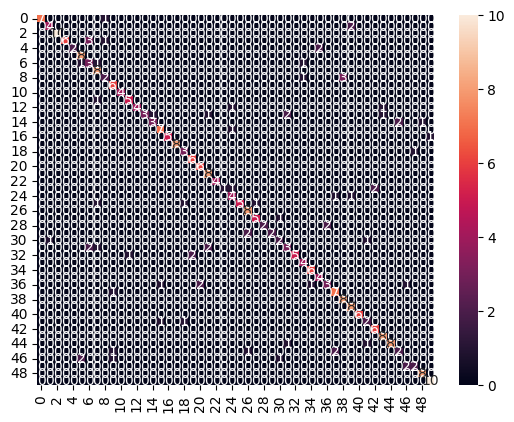

In [295]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
cm = confusion_matrix(np.argmax(Yval, axis=1), np.argmax(best_model.predict(Xval), axis=1))

sns.heatmap(cm, annot = True)

print(classification_report(np.argmax(Yval, axis=1), np.argmax(best_model.predict(Xval), axis=1)))

In [291]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters)

In [95]:
import kerastuner as kt
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2)

In [292]:
print(tuner.get_best_hyperparameters(1)[0])

In [154]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D
from kerastuner import HyperModel
import tensorflow_addons as tfa

#supercool hyperparameter
# Define the CNN model
model = Sequential(name='Sequential')
act_function = 'elu'

# Add convolutional layers
model.add(Conv1D(filters=125, kernel_size=2, activation=act_function, input_shape=(130, 126)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=125, kernel_size=2, activation=act_function))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=125, kernel_size=2, activation=act_function))
model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=100, kernel_size=2, activation=act_function))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=75, kernel_size=2, activation=act_function))
#model.add(MaxPooling1D(pool_size=2))

# droput layer, remove if no work
model.add(Dropout(0.8))


# Flatten the output for the fully connected layers
model.add(Flatten())
# Add fully connected layers
model.add(Dense(80, activation=act_function))
#model.add(Dense(16, activation=act_function))
#model.add(Dense(40, activation=act_function))
#model.add(Dense(16, activation=act_function))
model.add(Dropout(0.8))
model.add(Dense(50, activation='softmax'))  # Output layer
optimizer = Nadam(learning_rate=.0008273819395816823)
# Compile the model
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tfa.metrics.F1Score(num_classes=50, average='macro')])

# Print model summary
model.summary()

# Train the model
history = model.fit(Xtrain, Ytrain, epochs=500, validation_data=(Xval,Yval), batch_size = 96, callbacks=[tb_callback])

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 129, 125)          31625     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 64, 125)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 63, 125)           31375     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 31, 125)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 30, 125)           31375     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 15, 125)          0

Epoch 44/500
28/28 [==============================] - 1s 25ms/step - loss: 2.0918 - f1_score: 0.3834 - val_loss: 1.5365 - val_f1_score: 0.6179
Epoch 45/500
28/28 [==============================] - 1s 25ms/step - loss: 2.0865 - f1_score: 0.3753 - val_loss: 1.5811 - val_f1_score: 0.5754
Epoch 46/500
28/28 [==============================] - 1s 25ms/step - loss: 2.0244 - f1_score: 0.3971 - val_loss: 1.5359 - val_f1_score: 0.5827
Epoch 47/500
28/28 [==============================] - 1s 26ms/step - loss: 2.1067 - f1_score: 0.3972 - val_loss: 1.5295 - val_f1_score: 0.5951
Epoch 48/500
28/28 [==============================] - 1s 25ms/step - loss: 1.9666 - f1_score: 0.4229 - val_loss: 1.5604 - val_f1_score: 0.6111
Epoch 49/500
28/28 [==============================] - 1s 25ms/step - loss: 2.0078 - f1_score: 0.4276 - val_loss: 1.5114 - val_f1_score: 0.5636
Epoch 50/500
28/28 [==============================] - 1s 25ms/step - loss: 2.0150 - f1_score: 0.4126 - val_loss: 1.4760 - val_f1_score: 0.6087

Epoch 158/500
28/28 [==============================] - 1s 26ms/step - loss: 1.2623 - f1_score: 0.5945 - val_loss: 1.0093 - val_f1_score: 0.7471
Epoch 159/500
28/28 [==============================] - 1s 25ms/step - loss: 1.2509 - f1_score: 0.5914 - val_loss: 1.0791 - val_f1_score: 0.7531
Epoch 160/500
28/28 [==============================] - 1s 26ms/step - loss: 1.2447 - f1_score: 0.6127 - val_loss: 1.0285 - val_f1_score: 0.7657
Epoch 161/500
28/28 [==============================] - 1s 25ms/step - loss: 1.2130 - f1_score: 0.6147 - val_loss: 1.1312 - val_f1_score: 0.7282
Epoch 162/500
28/28 [==============================] - 1s 26ms/step - loss: 1.2235 - f1_score: 0.5995 - val_loss: 1.0494 - val_f1_score: 0.7354
Epoch 163/500
28/28 [==============================] - 1s 26ms/step - loss: 1.2629 - f1_score: 0.5982 - val_loss: 1.0416 - val_f1_score: 0.7616
Epoch 164/500
28/28 [==============================] - 1s 26ms/step - loss: 1.2293 - f1_score: 0.6165 - val_loss: 1.1879 - val_f1_score:

Epoch 215/500
28/28 [==============================] - 1s 28ms/step - loss: 1.0097 - f1_score: 0.6772 - val_loss: 1.0341 - val_f1_score: 0.7570
Epoch 216/500
28/28 [==============================] - 1s 26ms/step - loss: 1.1064 - f1_score: 0.6385 - val_loss: 1.0741 - val_f1_score: 0.7541
Epoch 217/500
28/28 [==============================] - 1s 26ms/step - loss: 1.0776 - f1_score: 0.6499 - val_loss: 1.0728 - val_f1_score: 0.7546
Epoch 218/500
28/28 [==============================] - 1s 26ms/step - loss: 1.1262 - f1_score: 0.6479 - val_loss: 1.0388 - val_f1_score: 0.7542
Epoch 219/500
28/28 [==============================] - 1s 26ms/step - loss: 1.1070 - f1_score: 0.6497 - val_loss: 1.0383 - val_f1_score: 0.7714
Epoch 220/500
28/28 [==============================] - 1s 27ms/step - loss: 1.0551 - f1_score: 0.6671 - val_loss: 1.0413 - val_f1_score: 0.7444
Epoch 221/500
28/28 [==============================] - 1s 26ms/step - loss: 1.0530 - f1_score: 0.6608 - val_loss: 1.0520 - val_f1_score:

Epoch 272/500
28/28 [==============================] - 1s 26ms/step - loss: 0.9261 - f1_score: 0.6968 - val_loss: 1.0509 - val_f1_score: 0.7793
Epoch 273/500
28/28 [==============================] - 1s 26ms/step - loss: 0.9655 - f1_score: 0.6924 - val_loss: 1.1830 - val_f1_score: 0.7384
Epoch 274/500
28/28 [==============================] - 1s 26ms/step - loss: 0.9163 - f1_score: 0.6876 - val_loss: 1.0750 - val_f1_score: 0.7590
Epoch 275/500
28/28 [==============================] - 1s 26ms/step - loss: 0.9526 - f1_score: 0.6960 - val_loss: 1.0866 - val_f1_score: 0.7364
Epoch 276/500
28/28 [==============================] - 1s 26ms/step - loss: 0.9660 - f1_score: 0.6810 - val_loss: 1.0787 - val_f1_score: 0.7204
Epoch 277/500
28/28 [==============================] - 1s 26ms/step - loss: 0.9471 - f1_score: 0.7004 - val_loss: 1.0305 - val_f1_score: 0.7441
Epoch 278/500
28/28 [==============================] - 1s 26ms/step - loss: 0.9255 - f1_score: 0.6991 - val_loss: 1.0790 - val_f1_score:

Epoch 329/500
28/28 [==============================] - 1s 26ms/step - loss: 0.8695 - f1_score: 0.7123 - val_loss: 1.0940 - val_f1_score: 0.7528
Epoch 330/500
28/28 [==============================] - 1s 26ms/step - loss: 0.8902 - f1_score: 0.7117 - val_loss: 1.0979 - val_f1_score: 0.7510
Epoch 331/500
28/28 [==============================] - 1s 26ms/step - loss: 0.8418 - f1_score: 0.7211 - val_loss: 1.0925 - val_f1_score: 0.7739
Epoch 332/500
28/28 [==============================] - 1s 26ms/step - loss: 0.8367 - f1_score: 0.7076 - val_loss: 1.0999 - val_f1_score: 0.7625
Epoch 333/500
28/28 [==============================] - 1s 28ms/step - loss: 0.8498 - f1_score: 0.7210 - val_loss: 1.0997 - val_f1_score: 0.7805
Epoch 334/500
28/28 [==============================] - 1s 30ms/step - loss: 0.8312 - f1_score: 0.7283 - val_loss: 1.1690 - val_f1_score: 0.7508
Epoch 335/500
28/28 [==============================] - 1s 27ms/step - loss: 0.9017 - f1_score: 0.7072 - val_loss: 1.1327 - val_f1_score:

Epoch 386/500
28/28 [==============================] - 1s 26ms/step - loss: 0.7639 - f1_score: 0.7347 - val_loss: 1.1928 - val_f1_score: 0.7519
Epoch 387/500
28/28 [==============================] - 1s 27ms/step - loss: 0.8017 - f1_score: 0.7320 - val_loss: 1.1767 - val_f1_score: 0.7845
Epoch 388/500
28/28 [==============================] - 1s 32ms/step - loss: 0.7990 - f1_score: 0.7381 - val_loss: 1.0505 - val_f1_score: 0.8025
Epoch 389/500
28/28 [==============================] - 1s 27ms/step - loss: 0.7803 - f1_score: 0.7382 - val_loss: 1.1526 - val_f1_score: 0.7657
Epoch 390/500
28/28 [==============================] - 1s 26ms/step - loss: 0.8065 - f1_score: 0.7298 - val_loss: 1.0953 - val_f1_score: 0.7790
Epoch 391/500
28/28 [==============================] - 1s 29ms/step - loss: 0.8081 - f1_score: 0.7295 - val_loss: 1.1342 - val_f1_score: 0.7762
Epoch 392/500
28/28 [==============================] - 1s 26ms/step - loss: 0.8303 - f1_score: 0.7317 - val_loss: 1.1665 - val_f1_score:

Epoch 443/500
28/28 [==============================] - 1s 26ms/step - loss: 0.7806 - f1_score: 0.7346 - val_loss: 1.1357 - val_f1_score: 0.8071
Epoch 444/500
28/28 [==============================] - 1s 26ms/step - loss: 0.7871 - f1_score: 0.7543 - val_loss: 1.2192 - val_f1_score: 0.7755
Epoch 445/500
28/28 [==============================] - 1s 26ms/step - loss: 0.7597 - f1_score: 0.7553 - val_loss: 1.2551 - val_f1_score: 0.7256
Epoch 446/500
28/28 [==============================] - 1s 27ms/step - loss: 0.7540 - f1_score: 0.7520 - val_loss: 1.1727 - val_f1_score: 0.7942
Epoch 447/500
28/28 [==============================] - 1s 26ms/step - loss: 0.7496 - f1_score: 0.7557 - val_loss: 1.1845 - val_f1_score: 0.7893
Epoch 448/500
28/28 [==============================] - 1s 26ms/step - loss: 0.7366 - f1_score: 0.7496 - val_loss: 1.1567 - val_f1_score: 0.7720
Epoch 449/500
28/28 [==============================] - 1s 27ms/step - loss: 0.7551 - f1_score: 0.7451 - val_loss: 1.1566 - val_f1_score:

Epoch 500/500
28/28 [==============================] - 1s 27ms/step - loss: 0.7168 - f1_score: 0.7671 - val_loss: 1.1581 - val_f1_score: 0.7873


In [110]:
res = model.predict(Xval)

11/11 [==============================] - 0s 4ms/step


In [137]:
np.argmax(res[100])

21

In [193]:
np.argmax(Yval[0])

0

In [191]:
Yval[100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [130]:
res = best_model.predict(Xval)

11/11 [==============================] - 0s 5ms/step


In [155]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(np.argmax(Yval, axis=1), np.argmax(model.predict(Xval), axis=1)))

11/11 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      1.00      1.00         6
           2       0.83      1.00      0.91        10
           3       0.88      0.70      0.78        10
           4       0.80      1.00      0.89         4
           5       0.73      1.00      0.84         8
           6       0.62      0.83      0.71         6
           7       0.88      0.88      0.88         8
           8       0.00      0.00      0.00         6
           9       0.62      0.83      0.71         6
          10       0.80      1.00      0.89         4
          11       1.00      0.83      0.91         6
          12       1.00      0.67      0.80         6
          13       0.71      0.62      0.67         8
          14       0.50      0.33      0.40         6
          15       0.88      0.88      0.88         8
          16       0.75    

/home/kristian/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kristian/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kristian/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [141]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        act_function = hp.Choice('dense_activation',values=['relu','selu','LeakyReLU'],default='selu')
        model = Sequential()
        model.add(Conv1D(filters=hp.Choice('num_filters_1',values=[25,50, 100],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=hp.Choice('num_filters_2',values=[25,50, 100],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=hp.Choice('num_filters_3',values=[25,50, 100],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.7,default=0.25,step=0.05,)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units',min_value=20,max_value=100,step=20,default=40),activation=act_function))
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.7,default=0.25,step=0.05,)))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(Lion(hp.Float('learning_rate',min_value=1e-5,max_value=1e-3,sampling='LOG',default=1e-5)),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=(130,126), num_classes=50)

In [142]:

HYPERBAND_MAX_EPOCHS = 100
#MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_loss',
    seed=10,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='test2',
    overwrite=True
)

In [143]:
tuner.search_space_summary()


Search space summary
Default search space size: 8
dense_activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['relu', 'selu', 'LeakyReLU'], 'ordered': False}
num_filters_1 (Choice)
{'default': 50, 'conditions': [], 'values': [25, 50, 100], 'ordered': True}
num_filters_2 (Choice)
{'default': 50, 'conditions': [], 'values': [25, 50, 100], 'ordered': True}
num_filters_3 (Choice)
{'default': 50, 'conditions': [], 'values': [25, 50, 100], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
units (Int)
{'default': 40, 'conditions': [], 'min_value': 20, 'max_value': 100, 'step': 20, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [144]:
tuner.search(Xtrain, Ytrain, epochs=1000, validation_split=0.15,batch_size=96)

Trial 254 Complete [00h 05m 55s]
val_loss: 3.711934208869934

Best val_loss So Far: 0.5881174206733704
Total elapsed time: 03h 26m 05s
INFO:tensorflow:Oracle triggered exit


In [213]:
best_model = tuner.get_best_models(num_models=1)[0]

In [147]:
tuner.results_summary()

Results summary
Results in hyperband/test2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0146 summary
Hyperparameters:
dense_activation: LeakyReLU
num_filters_1: 100
num_filters_2: 50
num_filters_3: 25
dropout_1: 0.55
units: 60
dropout_2: 0.0
learning_rate: 0.0008623436067374464
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0144
Score: 0.5881174206733704

Trial 0208 summary
Hyperparameters:
dense_activation: LeakyReLU
num_filters_1: 50
num_filters_2: 100
num_filters_3: 50
dropout_1: 0.6000000000000001
units: 40
dropout_2: 0.15000000000000002
learning_rate: 0.0008453355630521282
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0203
Score: 0.6373574137687683

Trial 0247 summary
Hyperparameters:
dense_activation: selu
num_filters_1: 50
num_filters_2: 25
num_filters_3: 50
dropout_1: 0.55
units: 60
dropout_2: 0.1
learning_rate: 0.00011684126260235347
tuner/epochs: 100
tuner/initi

In [228]:
bestHP = tuner.get_best_hyperparameters(num_trials=2)[1]

In [65]:
es = EarlyStopping(monitor="val_loss",patience=20,restore_best_weights=True)

In [233]:
print("[INFO] training the best model...")
model = tuner.hypermodel.build(bestHP)
History = model.fit(x=Xtrain, y=Ytrain,validation_data= (Xval,Yval), batch_size=96,epochs=200, callbacks=[es], verbose=1)

[INFO] training the best model...
Epoch 1/200
28/28 [==============================] - 2s 25ms/step - loss: 3.9155 - accuracy: 0.0164 - val_loss: 3.8558 - val_accuracy: 0.0123
Epoch 2/200
28/28 [==============================] - 0s 16ms/step - loss: 3.8114 - accuracy: 0.0374 - val_loss: 3.6777 - val_accuracy: 0.0617
Epoch 3/200
28/28 [==============================] - 0s 16ms/step - loss: 3.5656 - accuracy: 0.0803 - val_loss: 3.4296 - val_accuracy: 0.0556
Epoch 4/200
28/28 [==============================] - 0s 16ms/step - loss: 3.3048 - accuracy: 0.1110 - val_loss: 3.1529 - val_accuracy: 0.1358
Epoch 5/200
28/28 [==============================] - 0s 16ms/step - loss: 3.0500 - accuracy: 0.1416 - val_loss: 2.9998 - val_accuracy: 0.1698
Epoch 6/200
28/28 [==============================] - 0s 16ms/step - loss: 2.8309 - accuracy: 0.1977 - val_loss: 2.9745 - val_accuracy: 0.1821
Epoch 7/200
28/28 [==============================] - 0s 16ms/step - loss: 2.6850 - accuracy: 0.2351 - val_loss: 2.

In [234]:
loss, accuracy = model.evaluate(Xval, Yval)

11/11 [==============================] - 0s 5ms/step - loss: 2.1784 - accuracy: 0.6080


In [175]:
res = model.predict(Xval)

11/11 [==============================] - 0s 15ms/step


In [192]:
np.argmax(res[19])

5

In [191]:
np.argmax(Yval[19])

5

In [193]:
loss, accuracy = model.evaluate(Xval, Yval)

11/11 [==============================] - 0s 5ms/step - loss: 6.4985 - categorical_accuracy: 0.5833


In [36]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        act_function = hp.Choice('dense_activation',values=['elu','selu','gelu','LeakyReLU'],default='selu')
        model = Sequential()
        model.add(Conv1D(filters=hp.Choice('num_filters_1',values=[25,50, 100,150],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=hp.Choice('num_filters_2',values=[25,50, 100,150],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=hp.Choice('num_filters_3',values=[25,50, 100,150],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.7,default=0.25,step=0.05,)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units',min_value=20,max_value=120,step=20,default=40),activation=act_function))
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.7,default=0.25,step=0.05,)))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(Lion(hp.Float('learning_rate',min_value=1e-5,max_value=1e-3,sampling='LOG',default=1e-5)),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=(130,126), num_classes=50)

/tmp/ipykernel_6797/979066352.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [37]:
HYPERBAND_MAX_EPOCHS = 100
#MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_loss',
    seed=10,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='test3',
    overwrite=False)

2023-08-13 16:44:00.341249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1739 MB memory:  -> device: 0, name: NVIDIA GeForce MX250, pci bus id: 0000:01:00.0, compute capability: 6.1


In [39]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
dense_activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['elu', 'selu', 'gelu', 'LeakyReLU'], 'ordered': False}
num_filters_1 (Choice)
{'default': 50, 'conditions': [], 'values': [25, 50, 100, 150], 'ordered': True}
num_filters_2 (Choice)
{'default': 50, 'conditions': [], 'values': [25, 50, 100, 150], 'ordered': True}
num_filters_3 (Choice)
{'default': 50, 'conditions': [], 'values': [25, 50, 100, 150], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
units (Int)
{'default': 40, 'conditions': [], 'min_value': 20, 'max_value': 120, 'step': 20, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [66]:
tuner.search(Xtrain, Ytrain, epochs=1000, validation_data=(Xval,Yval),batch_size=96,callbacks=[es])

Trial 254 Complete [00h 09m 04s]
val_loss: 3.1169066429138184

Best val_loss So Far: 1.811120629310608
Total elapsed time: 03h 32m 27s
INFO:tensorflow:Oracle triggered exit


In [40]:
tuner.results_summary()

Results summary
Results in hyperband/test3
Showing 10 best trials
Objective(name="val_loss", direction="min")


In [69]:
best_model = tuner.get_best_models(num_models=1)[0]

In [70]:
loss, accuracy = best_model.evaluate(Xval, Yval)

11/11 [==============================] - 1s 22ms/step - loss: 1.8111 - accuracy: 0.5586


In [77]:
res = best_model.predict(Xval)

11/11 [==============================] - 0s 3ms/step


In [73]:
bestHP = tuner.get_best_hyperparameters(num_trials=2)[1]

In [85]:
print("[INFO] training the best model...")
model = tuner.hypermodel.build(bestHP)
History = model.fit(x=Xtrain, y=Ytrain,validation_data= (Xval,Yval), batch_size=96,epochs=500, verbose=1)

[INFO] training the best model...
Epoch 1/500
28/28 [==============================] - 2s 24ms/step - loss: 3.9340 - accuracy: 0.0194 - val_loss: 3.9039 - val_accuracy: 0.0247
Epoch 2/500
28/28 [==============================] - 0s 17ms/step - loss: 3.9069 - accuracy: 0.0295 - val_loss: 3.8650 - val_accuracy: 0.0432
Epoch 3/500
28/28 [==============================] - 0s 17ms/step - loss: 3.8578 - accuracy: 0.0396 - val_loss: 3.7671 - val_accuracy: 0.0617
Epoch 4/500
28/28 [==============================] - 0s 18ms/step - loss: 3.7790 - accuracy: 0.0546 - val_loss: 3.6556 - val_accuracy: 0.0679
Epoch 5/500
28/28 [==============================] - 0s 17ms/step - loss: 3.6996 - accuracy: 0.0534 - val_loss: 3.5803 - val_accuracy: 0.0710
Epoch 6/500
28/28 [==============================] - 0s 18ms/step - loss: 3.5841 - accuracy: 0.0736 - val_loss: 3.4399 - val_accuracy: 0.0772
Epoch 7/500
28/28 [==============================] - 0s 18ms/step - loss: 3.4903 - accuracy: 0.0856 - val_loss: 3.

28/28 [==============================] - 1s 18ms/step - loss: 0.9780 - accuracy: 0.6809 - val_loss: 1.8858 - val_accuracy: 0.6636
Epoch 116/500
28/28 [==============================] - 1s 18ms/step - loss: 1.0004 - accuracy: 0.6741 - val_loss: 2.0265 - val_accuracy: 0.6173
Epoch 117/500
28/28 [==============================] - 1s 18ms/step - loss: 0.9997 - accuracy: 0.6846 - val_loss: 1.7123 - val_accuracy: 0.6543
Epoch 118/500
28/28 [==============================] - 0s 18ms/step - loss: 0.9669 - accuracy: 0.6805 - val_loss: 1.7534 - val_accuracy: 0.6451
Epoch 119/500
28/28 [==============================] - 1s 18ms/step - loss: 0.9562 - accuracy: 0.6928 - val_loss: 2.0635 - val_accuracy: 0.6173
Epoch 120/500
28/28 [==============================] - 1s 18ms/step - loss: 0.9709 - accuracy: 0.6801 - val_loss: 1.9979 - val_accuracy: 0.5957
Epoch 121/500
28/28 [==============================] - 1s 18ms/step - loss: 0.9878 - accuracy: 0.6910 - val_loss: 1.9819 - val_accuracy: 0.6019
Epoch 

Epoch 172/500
28/28 [==============================] - 1s 18ms/step - loss: 0.7722 - accuracy: 0.7474 - val_loss: 1.9057 - val_accuracy: 0.7099
Epoch 173/500
28/28 [==============================] - 1s 18ms/step - loss: 0.8160 - accuracy: 0.7354 - val_loss: 1.8212 - val_accuracy: 0.7099
Epoch 174/500
28/28 [==============================] - 1s 19ms/step - loss: 0.7991 - accuracy: 0.7339 - val_loss: 1.8918 - val_accuracy: 0.6759
Epoch 175/500
28/28 [==============================] - 1s 19ms/step - loss: 0.7624 - accuracy: 0.7470 - val_loss: 1.8620 - val_accuracy: 0.6728
Epoch 176/500
28/28 [==============================] - 1s 18ms/step - loss: 0.7808 - accuracy: 0.7283 - val_loss: 1.7157 - val_accuracy: 0.7068
Epoch 177/500
28/28 [==============================] - 1s 18ms/step - loss: 0.7678 - accuracy: 0.7440 - val_loss: 1.8266 - val_accuracy: 0.6914
Epoch 178/500
28/28 [==============================] - 1s 18ms/step - loss: 0.8177 - accuracy: 0.7347 - val_loss: 1.7192 - val_accuracy:

Epoch 229/500
28/28 [==============================] - 1s 18ms/step - loss: 0.6798 - accuracy: 0.7788 - val_loss: 2.3628 - val_accuracy: 0.6327
Epoch 230/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6414 - accuracy: 0.7806 - val_loss: 2.0518 - val_accuracy: 0.6975
Epoch 231/500
28/28 [==============================] - 1s 19ms/step - loss: 0.7028 - accuracy: 0.7777 - val_loss: 1.9602 - val_accuracy: 0.7006
Epoch 232/500
28/28 [==============================] - 1s 19ms/step - loss: 0.7119 - accuracy: 0.7679 - val_loss: 2.0242 - val_accuracy: 0.7191
Epoch 233/500
28/28 [==============================] - 1s 19ms/step - loss: 0.7203 - accuracy: 0.7623 - val_loss: 2.3282 - val_accuracy: 0.6296
Epoch 234/500
28/28 [==============================] - 1s 18ms/step - loss: 0.7091 - accuracy: 0.7750 - val_loss: 2.2333 - val_accuracy: 0.6574
Epoch 235/500
28/28 [==============================] - 1s 19ms/step - loss: 0.7208 - accuracy: 0.7597 - val_loss: 2.1238 - val_accuracy:

Epoch 286/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6236 - accuracy: 0.7941 - val_loss: 2.1563 - val_accuracy: 0.6790
Epoch 287/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6367 - accuracy: 0.7933 - val_loss: 2.3089 - val_accuracy: 0.6790
Epoch 288/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6302 - accuracy: 0.7948 - val_loss: 2.3395 - val_accuracy: 0.6914
Epoch 289/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6355 - accuracy: 0.7862 - val_loss: 2.0399 - val_accuracy: 0.7160
Epoch 290/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6529 - accuracy: 0.7900 - val_loss: 2.0723 - val_accuracy: 0.7222
Epoch 291/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6512 - accuracy: 0.7889 - val_loss: 2.3631 - val_accuracy: 0.6636
Epoch 292/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6396 - accuracy: 0.7877 - val_loss: 2.3959 - val_accuracy:

Epoch 343/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6469 - accuracy: 0.7967 - val_loss: 2.2998 - val_accuracy: 0.7469
Epoch 344/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6197 - accuracy: 0.8008 - val_loss: 2.0798 - val_accuracy: 0.7284
Epoch 345/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6025 - accuracy: 0.8061 - val_loss: 2.4137 - val_accuracy: 0.7037
Epoch 346/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6232 - accuracy: 0.8008 - val_loss: 2.3309 - val_accuracy: 0.6790
Epoch 347/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6091 - accuracy: 0.8124 - val_loss: 2.6325 - val_accuracy: 0.6698
Epoch 348/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5655 - accuracy: 0.8161 - val_loss: 2.2502 - val_accuracy: 0.7160
Epoch 349/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5889 - accuracy: 0.8034 - val_loss: 2.4137 - val_accuracy:

Epoch 400/500
28/28 [==============================] - 1s 19ms/step - loss: 0.6045 - accuracy: 0.7997 - val_loss: 2.6240 - val_accuracy: 0.6574
Epoch 401/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5980 - accuracy: 0.8165 - val_loss: 2.7850 - val_accuracy: 0.6389
Epoch 402/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5915 - accuracy: 0.8083 - val_loss: 2.4213 - val_accuracy: 0.6883
Epoch 403/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5798 - accuracy: 0.8124 - val_loss: 2.2786 - val_accuracy: 0.7037
Epoch 404/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5729 - accuracy: 0.8214 - val_loss: 2.4126 - val_accuracy: 0.6883
Epoch 405/500
28/28 [==============================] - 1s 20ms/step - loss: 0.5833 - accuracy: 0.8150 - val_loss: 2.6340 - val_accuracy: 0.6728
Epoch 406/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5530 - accuracy: 0.8195 - val_loss: 2.6447 - val_accuracy:

Epoch 457/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5216 - accuracy: 0.8315 - val_loss: 2.4650 - val_accuracy: 0.6821
Epoch 458/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5114 - accuracy: 0.8281 - val_loss: 2.6585 - val_accuracy: 0.6543
Epoch 459/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5285 - accuracy: 0.8255 - val_loss: 2.4726 - val_accuracy: 0.6759
Epoch 460/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5082 - accuracy: 0.8393 - val_loss: 2.8692 - val_accuracy: 0.6481
Epoch 461/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5949 - accuracy: 0.8132 - val_loss: 2.6516 - val_accuracy: 0.6914
Epoch 462/500
28/28 [==============================] - 1s 18ms/step - loss: 0.5240 - accuracy: 0.8225 - val_loss: 2.8863 - val_accuracy: 0.6852
Epoch 463/500
28/28 [==============================] - 1s 19ms/step - loss: 0.5353 - accuracy: 0.8240 - val_loss: 2.6029 - val_accuracy:

In [93]:
res = best_model.predict(Xtest)

17/17 [==============================] - 0s 17ms/step


In [122]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

/home/kristian/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kristian/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kristian/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.00      0.00      0.00        11
           2       0.75      0.40      0.52        15
           3       1.00      0.14      0.25         7
           4       0.43      1.00      0.60        15
           5       0.45      0.62      0.53         8
           6       0.33      0.20      0.25        10
           7       0.75      0.25      0.38        12
           8       0.83      0.38      0.53        13
           9       0.50      0.08      0.14        12
          10       1.00      0.71      0.83        14
          11       0.67      0.40      0.50        10
          12       0.53      0.67      0.59        12
          13       0.00      0.00      0.00        10
          14       0.50      0.55      0.52        11
          15       0.00      0.00      0.00        10
          16       1.00      0.17      0.29        12
          17       0.52    

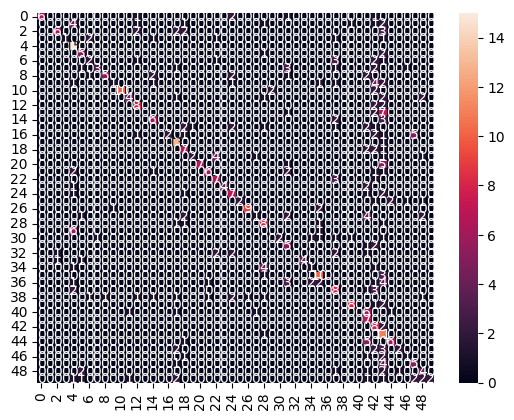

In [94]:
cm = confusion_matrix(np.argmax(Ytest, axis=1), np.argmax(res, axis=1))

sns.heatmap(cm, annot = True)

print(classification_report(np.argmax(Ytest, axis=1), np.argmax(res, axis=1)))

In [79]:
predict_class = np.argmax(predict, axis=1)
predict_class = predict_class.tolist()

2917

## Hyperparameter Tunning 2 1D CNN Layers

In [256]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D,
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        act_function = hp.Choice('dense_activation',values=['selu','LeakyReLU'],default='selu')
        model = Sequential()
        model.add(Conv1D(filters=hp.Choice('num_filters_1',values=[25,50, 100,150],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=hp.Choice('num_filters_2',values=[25,50, 100,150],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
#        model.add(Conv1D(filters=hp.Choice('num_filters_3',values=[25,50, 100,150],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
#        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.7,default=0.25,step=0.05,)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units',min_value=20,max_value=120,step=20,default=40),activation=act_function))
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.7,default=0.25,step=0.05,)))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(Lion(hp.Float('learning_rate',min_value=1e-5,max_value=1e-3,sampling='LOG',default=1e-5)),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=(130,126), num_classes=50)

/tmp/ipykernel_198611/792044357.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [497]:
HYPERBAND_MAX_EPOCHS = 100
#MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_loss',
    seed=10,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='/media/kristian/HDD/ASL_Citizen/Mediapipe/hyperband/',
    project_name='test4',
    overwrite=False)

INFO:tensorflow:Reloading Tuner from hyperband/test4/tuner0.json


In [498]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
dense_activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['selu', 'LeakyReLU'], 'ordered': False}
num_filters_1 (Choice)
{'default': 50, 'conditions': [], 'values': [25, 50, 100, 150], 'ordered': True}
num_filters_2 (Choice)
{'default': 50, 'conditions': [], 'values': [25, 50, 100, 150], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
units (Int)
{'default': 40, 'conditions': [], 'min_value': 20, 'max_value': 120, 'step': 20, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [499]:
es = EarlyStopping(monitor="val_loss",patience=20,restore_best_weights=True)

In [48]:
tuner.search(Xtrain, Ytrain, epochs=1000, validation_data=(Xval,Yval),batch_size=96,callbacks=[es])

Trial 254 Complete [00h 02m 53s]
val_loss: 2.798992872238159

Best val_loss So Far: 1.5037063360214233
Total elapsed time: 02h 34m 13s
INFO:tensorflow:Oracle triggered exit


In [500]:
tuner.results_summary()

Results summary
Results in hyperband/test4
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0245 summary
Hyperparameters:
dense_activation: selu
num_filters_1: 100
num_filters_2: 25
dropout_1: 0.65
units: 40
dropout_2: 0.4
learning_rate: 0.00013960407115272237
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0242
Score: 1.5037063360214233

Trial 0208 summary
Hyperparameters:
dense_activation: selu
num_filters_1: 50
num_filters_2: 100
dropout_1: 0.6000000000000001
units: 60
dropout_2: 0.6000000000000001
learning_rate: 0.00022015333534136284
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0207
Score: 2.004472494125366

Trial 0233 summary
Hyperparameters:
dense_activation: selu
num_filters_1: 25
num_filters_2: 25
dropout_1: 0.30000000000000004
units: 80
dropout_2: 0.65
learning_rate: 0.00025224242614677007
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 1
tune

In [501]:
bestHP = tuner.get_best_hyperparameters(num_trials=2)[1]

In [502]:
print("[INFO] training the best model...")
model = tuner.hypermodel.build(bestHP)
History = model.fit(x=Xtrain, y=Ytrain,validation_data= (Xval,Yval), batch_size=96,epochs=100, verbose=1)

[INFO] training the best model...
Epoch 1/100
28/28 [==============================] - 1s 32ms/step - loss: 5.5308 - accuracy: 0.0243 - val_loss: 3.8263 - val_accuracy: 0.0833
Epoch 2/100
28/28 [==============================] - 1s 27ms/step - loss: 4.3483 - accuracy: 0.0501 - val_loss: 3.5147 - val_accuracy: 0.1420
Epoch 3/100
28/28 [==============================] - 1s 29ms/step - loss: 3.8559 - accuracy: 0.0968 - val_loss: 3.2292 - val_accuracy: 0.2006
Epoch 4/100
28/28 [==============================] - 1s 27ms/step - loss: 3.4544 - accuracy: 0.1424 - val_loss: 3.0182 - val_accuracy: 0.2623
Epoch 5/100
28/28 [==============================] - 1s 27ms/step - loss: 3.1560 - accuracy: 0.1865 - val_loss: 2.7759 - val_accuracy: 0.3519
Epoch 6/100
28/28 [==============================] - 1s 27ms/step - loss: 2.9038 - accuracy: 0.2414 - val_loss: 2.5860 - val_accuracy: 0.3951
Epoch 7/100
28/28 [==============================] - 1s 28ms/step - loss: 2.7335 - accuracy: 0.2844 - val_loss: 2.

In [52]:
best_model = tuner.get_best_models(num_models=1)[0]

In [61]:
History = best_model.fit(x=Xtrain, y=Ytrain,validation_data= (Xval,Yval), batch_size=96,epochs=500, verbose=1)

Epoch 1/500
28/28 [==============================] - 2s 17ms/step - loss: 1.1973 - accuracy: 0.6364 - val_loss: 1.6069 - val_accuracy: 0.6543
Epoch 2/500
28/28 [==============================] - 0s 15ms/step - loss: 1.1804 - accuracy: 0.6368 - val_loss: 1.6015 - val_accuracy: 0.6049
Epoch 3/500
28/28 [==============================] - 0s 15ms/step - loss: 1.1668 - accuracy: 0.6480 - val_loss: 1.6986 - val_accuracy: 0.6173
Epoch 4/500
28/28 [==============================] - 0s 15ms/step - loss: 1.2008 - accuracy: 0.6177 - val_loss: 1.6607 - val_accuracy: 0.6111
Epoch 5/500
28/28 [==============================] - 0s 15ms/step - loss: 1.1745 - accuracy: 0.6319 - val_loss: 1.6212 - val_accuracy: 0.6173
Epoch 6/500
28/28 [==============================] - 0s 15ms/step - loss: 1.1680 - accuracy: 0.6383 - val_loss: 1.5716 - val_accuracy: 0.6204
Epoch 7/500
28/28 [==============================] - 0s 16ms/step - loss: 1.1666 - accuracy: 0.6371 - val_loss: 1.4613 - val_accuracy: 0.6543
Epoch 

28/28 [==============================] - 0s 15ms/step - loss: 0.8847 - accuracy: 0.7156 - val_loss: 1.7174 - val_accuracy: 0.6358
Epoch 116/500
28/28 [==============================] - 0s 15ms/step - loss: 0.9036 - accuracy: 0.7100 - val_loss: 1.6745 - val_accuracy: 0.6389
Epoch 117/500
28/28 [==============================] - 0s 15ms/step - loss: 0.9146 - accuracy: 0.7100 - val_loss: 1.6302 - val_accuracy: 0.6852
Epoch 118/500
28/28 [==============================] - 0s 15ms/step - loss: 0.8746 - accuracy: 0.7294 - val_loss: 1.4993 - val_accuracy: 0.6728
Epoch 119/500
28/28 [==============================] - 0s 16ms/step - loss: 0.8975 - accuracy: 0.7134 - val_loss: 1.5081 - val_accuracy: 0.6821
Epoch 120/500
28/28 [==============================] - 0s 15ms/step - loss: 0.9008 - accuracy: 0.7111 - val_loss: 1.6858 - val_accuracy: 0.6698
Epoch 121/500
28/28 [==============================] - 0s 15ms/step - loss: 0.9219 - accuracy: 0.7104 - val_loss: 1.8443 - val_accuracy: 0.6235
Epoch 

Epoch 172/500
28/28 [==============================] - 0s 15ms/step - loss: 0.8254 - accuracy: 0.7298 - val_loss: 1.6094 - val_accuracy: 0.6821
Epoch 173/500
28/28 [==============================] - 0s 16ms/step - loss: 0.8408 - accuracy: 0.7351 - val_loss: 2.1210 - val_accuracy: 0.5617
Epoch 174/500
28/28 [==============================] - 0s 15ms/step - loss: 0.8103 - accuracy: 0.7354 - val_loss: 1.6483 - val_accuracy: 0.7037
Epoch 175/500
28/28 [==============================] - 0s 16ms/step - loss: 0.8149 - accuracy: 0.7365 - val_loss: 1.8927 - val_accuracy: 0.6420
Epoch 176/500
28/28 [==============================] - 0s 15ms/step - loss: 0.7995 - accuracy: 0.7384 - val_loss: 1.7119 - val_accuracy: 0.6420
Epoch 177/500
28/28 [==============================] - 0s 15ms/step - loss: 0.8509 - accuracy: 0.7328 - val_loss: 1.5842 - val_accuracy: 0.6698
Epoch 178/500
28/28 [==============================] - 0s 15ms/step - loss: 0.8482 - accuracy: 0.7283 - val_loss: 1.8628 - val_accuracy:

Epoch 229/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7591 - accuracy: 0.7410 - val_loss: 1.7798 - val_accuracy: 0.6636
Epoch 230/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7688 - accuracy: 0.7451 - val_loss: 1.8049 - val_accuracy: 0.6543
Epoch 231/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7679 - accuracy: 0.7608 - val_loss: 1.6894 - val_accuracy: 0.6852
Epoch 232/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7392 - accuracy: 0.7653 - val_loss: 1.7807 - val_accuracy: 0.6605
Epoch 233/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7773 - accuracy: 0.7515 - val_loss: 1.7914 - val_accuracy: 0.6636
Epoch 234/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7373 - accuracy: 0.7597 - val_loss: 1.9289 - val_accuracy: 0.6327
Epoch 235/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7769 - accuracy: 0.7560 - val_loss: 2.0037 - val_accuracy:

Epoch 286/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7167 - accuracy: 0.7713 - val_loss: 1.9682 - val_accuracy: 0.6451
Epoch 287/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7190 - accuracy: 0.7664 - val_loss: 1.9762 - val_accuracy: 0.6451
Epoch 288/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7686 - accuracy: 0.7500 - val_loss: 1.9480 - val_accuracy: 0.6605
Epoch 289/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7175 - accuracy: 0.7672 - val_loss: 1.9774 - val_accuracy: 0.6389
Epoch 290/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7338 - accuracy: 0.7564 - val_loss: 1.7772 - val_accuracy: 0.6451
Epoch 291/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7107 - accuracy: 0.7679 - val_loss: 1.6474 - val_accuracy: 0.6914
Epoch 292/500
28/28 [==============================] - 0s 16ms/step - loss: 0.7212 - accuracy: 0.7575 - val_loss: 1.7297 - val_accuracy:

Epoch 343/500
28/28 [==============================] - 0s 16ms/step - loss: 0.6997 - accuracy: 0.7720 - val_loss: 2.1009 - val_accuracy: 0.6080
Epoch 344/500
28/28 [==============================] - 0s 16ms/step - loss: 0.6925 - accuracy: 0.7724 - val_loss: 1.6792 - val_accuracy: 0.7006
Epoch 345/500
28/28 [==============================] - 0s 16ms/step - loss: 0.6749 - accuracy: 0.7806 - val_loss: 2.0945 - val_accuracy: 0.6265
Epoch 346/500
28/28 [==============================] - 0s 16ms/step - loss: 0.6950 - accuracy: 0.7750 - val_loss: 2.5844 - val_accuracy: 0.5710
Epoch 347/500
13/28 [============>.................] - ETA: 0s - loss: 0.6542 - accuracy: 0.7949

KeyboardInterrupt: 

In [504]:
res = model.predict(Xval)

11/11 [==============================] - 0s 3ms/step


In [506]:
loss, accuracy = model.evaluate(Xval, Yval)

11/11 [==============================] - 0s 4ms/step - loss: 1.3734 - accuracy: 0.7469


In [507]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

              precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.86      1.00      0.92         6
           2       0.70      0.70      0.70        10
           3       1.00      0.70      0.82        10
           4       1.00      1.00      1.00         4
           5       0.88      0.88      0.88         8
           6       0.33      0.50      0.40         6
           7       0.80      1.00      0.89         8
           8       0.67      0.67      0.67         6
           9       0.43      1.00      0.60         6
          10       0.67      1.00      0.80         4
          11       0.83      0.83      0.83         6
          12       0.67      0.67      0.67         6
          13       0.57      0.50      0.53         8
          14       0.40      0.33      0.36         6
          15       0.62      0.62      0.62         8
          16       1.00      1.00      1.00         6
          17       1.00    

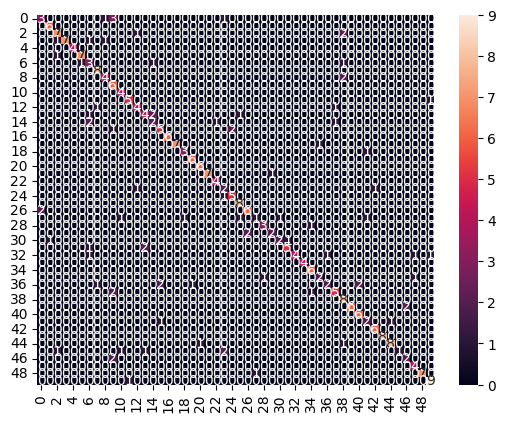

In [508]:
cm = confusion_matrix(np.argmax(Yval, axis=1), np.argmax(res, axis=1))

sns.heatmap(cm, annot = True)

print(classification_report(np.argmax(Yval, axis=1), np.argmax(res, axis=1)))

In [509]:
np.argmax(res[11])

2

In [510]:
np.argmax(Yval[11])

2

In [511]:
np.argmax(res, axis=1)

array([ 0,  8, 23,  0,  1,  1,  1, 38,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        4,  4,  5,  2,  5,  5,  5,  6, 38,  7,  7,  7,  7,  8,  8,  8,  9,
        9,  9, 10, 10, 11, 11, 49, 12, 12, 37, 14, 25, 13, 13, 14, 22, 37,
        9, 15, 24, 15, 16, 16, 16, 17, 17, 17, 17, 18, 18, 19, 19, 19, 20,
       20, 20, 29, 21, 21, 21, 22, 22, 23, 42, 24, 23, 24, 25, 25, 25, 25,
       26,  0, 26, 26, 18, 10, 25, 28, 28, 29, 26, 31, 30, 31,  6, 31, 31,
       47, 32, 32, 36, 33, 33, 34, 34, 34, 35, 28, 40, 15, 15,  7, 37, 37,
        9, 37, 38, 38, 38, 38, 46, 39, 39, 39, 40, 40, 40, 44, 41, 42, 42,
       42, 43, 43, 43, 43, 44, 44, 44, 38, 44, 10, 23, 45, 46,  9, 47, 47,
       48, 48, 48, 48, 11, 49, 49, 49, 49,  9,  9,  9,  0,  1,  1,  1, 38,
       12,  2,  2,  2,  6,  3,  3,  3,  8,  4,  4,  5,  5,  5,  5, 14,  6,
        6,  7,  7,  7,  7, 38,  8, 38,  9,  9,  9, 10, 10, 11, 11, 11, 12,
       12,  7,  6, 14, 13, 13,  6,  6, 14, 15, 15, 24, 15, 16, 16, 16, 17,
       17, 35, 17, 41, 18

In [512]:
np.argmax(Yval, axis=1)

array([ 0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  9,
        9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,
       15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 18, 18, 19, 19, 19, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 23, 23, 24, 24, 24, 25, 25, 25, 25,
       26, 26, 26, 26, 27, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 31, 31,
       32, 32, 32, 32, 33, 33, 34, 34, 34, 35, 35, 36, 36, 36, 36, 37, 37,
       37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 41, 41, 42, 42,
       42, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 46, 46, 47, 47,
       48, 48, 48, 48, 49, 49, 49, 49, 49,  0,  0,  0,  0,  1,  1,  1,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12,
       12, 12, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 17,
       17, 17, 17, 18, 18

TypeError: list.count() takes exactly one argument (0 given)

In [202]:
sequence.shape

AttributeError: 'list' object has no attribute 'shape'

In [152]:
Xtrain[0][10]

array([0.        , 0.        , 0.61430512, 0.        , 0.        ,
       0.39596278, 0.        , 0.        , 0.40874202, 0.        ,
       0.        , 0.40810024, 0.        , 0.        , 0.48266869,
       0.        , 0.        , 0.65779321, 0.        , 0.        ,
       0.81176704, 0.        , 0.        , 0.92339662, 0.        ,
       0.        , 0.96071672, 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.70816574, 0.        , 0.        , 0.30657587, 0.        ,
       0.        , 0.52645834, 0.        , 0.        , 0.65912

In [94]:
predictions

[42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 42]

In [124]:
predictions

[]

In [130]:
sequence

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [138]:
trials = tuner.oracle.trials

# Print out the ID and the score of all trials
for trial_id, trial in trials.items():
    print(trial_id, trial.score)

# Return best 5 trials
best_trials = tuner.oracle.get_best_trials(num_trials=5)
for trial in best_trials:
    trial.summary()
    model2 = tuner.load_model(trial)
    # Do some stuff to the model

0000 3.898800849914551
0001 3.803058624267578
0002 3.886780858039856
0003 3.5405542850494385
0004 3.8846980333328247
0005 3.9728771448135376
0006 3.5900771617889404
0007 3.9532002210617065
0008 3.938177227973938
0009 4.048365831375122
0010 3.615102171897888
0011 3.7522424459457397
0012 3.909103274345398
0013 3.9027684926986694
0014 3.885507822036743
0015 3.9257211685180664
0016 3.282256007194519
0017 3.7758527994155884
0018 3.873215436935425
0019 3.8949038982391357
0020 3.8801382780075073
0021 3.788564443588257
0022 3.5741392374038696
0023 3.3994975090026855
0024 3.911440849304199
0025 3.7547767162323
0026 4.029992580413818
0027 3.9448060989379883
0028 3.910792350769043
0029 3.740312933921814
0030 3.8987677097320557
0031 3.4418601989746094
0032 3.28007972240448
0033 3.9038991928100586
0034 3.888121247291565
0035 3.936005473136902
0036 3.3792749643325806
0037 3.713937997817993
0038 3.5628620386123657
0039 3.688674569129944
0040 3.908714771270752
0041 3.925951600074768
0042 3.90328323841

Trial 0233 summary
Hyperparameters:
dense_activation: selu
num_filters_1: 25
num_filters_2: 25
dropout_1: 0.30000000000000004
units: 80
dropout_2: 0.65
learning_rate: 0.00025224242614677007
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0216
Score: 2.0138278007507324
Trial 0207 summary
Hyperparameters:
dense_activation: selu
num_filters_1: 50
num_filters_2: 100
dropout_1: 0.6000000000000001
units: 60
dropout_2: 0.6000000000000001
learning_rate: 0.00022015333534136284
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0199
Score: 2.0394604206085205
Trial 0229 summary
Hyperparameters:
dense_activation: selu
num_filters_1: 50
num_filters_2: 50
dropout_1: 0.55
units: 80
dropout_2: 0.1
learning_rate: 0.00021979153094558063
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0213
Score: 2.0706980228424072


In [112]:
loss, accuracy = reconstructed_model.evaluate(Xval, Yval)

11/11 [==============================] - 0s 4ms/step - loss: 2.0496 - accuracy: 0.6358


In [141]:
loss, accuracy = best_model.evaluate(Xval, Yval)

11/11 [==============================] - 0s 4ms/step - loss: 2.0496 - accuracy: 0.6358


In [513]:
import matplotlib.pyplot as plt

plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(best_model.history['loss'])
plt.plot(best_model.history['val_loss'])
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

TypeError: 'History' object is not subscriptable

In [235]:
best_model.save("best_model")

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


In [61]:
reconstructed_model = tf.keras.models.load_model("best_model")

In [240]:
reconstructed_model.history()

TypeError: 'History' object is not callable

In [172]:
cv2.destroyAllWindows()
cap.release()

## Realtime Code Prediction 

In [121]:
path = '/home/kristian/ASL_Citizen/videos/0525121513125173-DARK.mp4'
cap = cv2.VideoCapture(path)
#cap = cv2.VideoCapture(0)
print(frames_from_file(path))

sequence = [np.zeros(126)] * 130  # Initialize with 130 zero-filled sequences
predictions = []

with mp_holistic.Holistic(static_image_mode=False,
                          model_complexity=1) as holistic:
    while True:
        ret, frame = cap.read()
        if ret == False:
            break
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)
        # Left hand
        mp_drawing.draw_landmarks(
            frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))

        # Right Hand
        mp_drawing.draw_landmarks(
            frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))
                # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence.pop(0)  # Remove the oldest element
        
        if len(sequence) == 130:
            res = reconstructed_model.predict(np.expand_dims(sequence, axis=0))[0]
            print(np.argmax(res))
            predictions.append(np.argmax(res))
            
        frame = cv2.flip(frame, 1)
        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break
cap.release()
cv2.destroyAllWindows()

(114, 30, 4)
1/1 [==============================] - 0s 16ms/step
42
1/1 [==============================] - 0s 16ms/step
42
1/1 [==============================] - 0s 14ms/step
42
1/1 [==============================] - 0s 14ms/step
42
1/1 [==============================] - 0s 17ms/step
42
1/1 [==============================] - 0s 15ms/step
42
1/1 [==============================] - 0s 15ms/step
42
1/1 [==============================] - 0s 20ms/step
42
1/1 [==============================] - 0s 14ms/step
18
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 15ms/step
46
1/1 [==============================] - 0s 15ms/step
46
1/1 [==============================] - 0s 15ms/step
46
1/1 [==============================] - 0s 14ms/step
46
1/1 [==============================] - 0s 17ms/step
46
1/1 [==============================] - 0s 17ms/step
42
1/1 [==============================] - 0s 16ms/step
42
1/1 [==============================] - 0s 18ms/step
4

In [234]:
#path = valdf.Path[9]
#path = '/home/kristian/ASL_Citizen/videos/00930662603221255-WHAT FOR.mp4'
path = '/home/kristian/WLASL/videos_organized/basketball/05243.mp4'
#path = 0
cap = cv2.VideoCapture(path)
#cap = cv2.VideoCapture(0)
#print(frames_from_file(path))

sequence = [np.zeros(126)] * 130  # Initialize with 130 zero-filled sequences
predictions = []
threshold = 0.8

with mp_holistic.Holistic(static_image_mode=False,
                          model_complexity=1) as holistic:
    while True:
        ret, frame = cap.read()
        if ret == False:
            break
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)
        # Left hand
        mp_drawing.draw_landmarks(
            frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))

        # Right Hand
        mp_drawing.draw_landmarks(
            frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))
                # 2. Prediction logic
            
            # Open the video file
        # Initialize an empty list to store the keypoints for each frame
        keypoints = []
        sequence.append(extract_keypoints(results))
        sequence.pop(0)  # Remove the oldest element
        sequence = np.array(sequence)
     #   sequence = sequence.reshape(1, -1)
     #   sequence=scaler.transform(sequence).reshape(130, 126)
        sequence = sequence.tolist()
        if len(sequence) == 130:
            
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            if res[np.argmax(res)] > threshold:
                print(np.argmax(res))
                predictions.append(np.argmax(res))
            
        frame = cv2.flip(frame, 1)
        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step
26
1/1 [==============================] - 0s 19ms/step
26
1/1 [==============================] - 0s 24ms/step
26
1/1 [==============================] - 0s 28ms/step
26
1/1 [==============================] - 0s 23ms/step
26
1/1 [==============================] - 0s 23ms/step
26
1/1 [==============================] - 0s 22ms/step
26
1/1 [==============================] - 0s 20ms/step
26
1/1 [==============================] - 0s 20ms/step
1
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 22ms/step


In [218]:
#path = valdf.Path[9]
#path = '/home/kristian/ASL_Citizen/videos/9161417844146778-WHAT FOR.mp4'
#path = '/home/kristian/WLASL/videos_organized/dark/65440.mp4'
path = 0
cap = cv2.VideoCapture(path)
#cap = cv2.VideoCapture(0)
#print(frames_from_file(path))

sequence = [np.zeros(126)] * 130  # Initialize with 130 zero-filled sequences
predictions = []
threshold = 0.9

with mp_holistic.Holistic(static_image_mode=False,
                          model_complexity=1) as holistic:
    while True:
        ret, frame = cap.read()
        if ret == False:
            break
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)
        # Left hand
        mp_drawing.draw_landmarks(
            frame, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))

        # Right Hand
        mp_drawing.draw_landmarks(
            frame, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(0, 0, 0),
                                   thickness=2,
                                   circle_radius=1),
            mp_drawing.DrawingSpec(color=(0, 92, 230), thickness=2))
                # 2. Prediction logic
            
            # Open the video file
        # Initialize an empty list to store the keypoints for each frame
        keypoints = []
        sequence = np.array(sequence)
        sequence = sequence.reshape(1, -1)
        sequence = scaler.inverse_transform(sequence).reshape(130, 126)
        sequence = sequence.tolist()
        sequence.append(extract_keypoints(results))
        sequence.pop(0)  # Remove the oldest element
        sequence = np.array(sequence)
        sequence = sequence.reshape(1, -1)
        sequence=scaler.transform(sequence).reshape(130, 126)
        sequence = sequence.tolist()
        if len(sequence) == 130:
            
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            if res[np.argmax(res)] > threshold:
                print(inv_label_map[np.argmax(res)])
                predictions.append(np.argmax(res))
                frame = cv2.putText(frame,inv_label_map[np.argmax(res)],(10,30),cv2.FONT_HERSHEY_SIMPLEX,1.0,(0, 255, 0), 2)
#        frame = cv2.flip(frame, 1)
        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break
cap.release()
cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


1/1 [==============================] - 0s 22ms/step
DARK
1/1 [==============================] - 0s 24ms/step
DARK
1/1 [==============================] - 0s 26ms/step
DARK
1/1 [==============================] - 0s 20ms/step
DARK
1/1 [==============================] - 0s 20ms/step
DARK
1/1 [==============================] - 0s 24ms/step
DARK
1/1 [==============================] - 0s 21ms/step
DARK
1/1 [==============================] - 0s 24ms/step
DARK
1/1 [==============================] - 0s 43ms/step
DARK
1/1 [==============================] - 0s 26ms/step
DARK
1/1 [==============================] - 0s 22ms/step
DARK
1/1 [==============================] - 0s 24ms/step
DARK
1/1 [==============================] - 0s 20ms/step
DARK
1/1 [==============================] - 0s 24ms/step
DARK
1/1 [==============================] - 0s 22ms/step
DARK
1/1 [==============================] - 0s 23ms/step
DARK
1/1 [==============================] - 0s 21ms/step
DARK
1/1 [==========================

1/1 [==============================] - 0s 26ms/step
AXE
1/1 [==============================] - 0s 25ms/step
AXE
1/1 [==============================] - 0s 27ms/step
AXE
1/1 [==============================] - 0s 27ms/step
AXE
1/1 [==============================] - 0s 26ms/step
AXE
1/1 [==============================] - 0s 25ms/step
AXE
1/1 [==============================] - 0s 20ms/step
AXE
1/1 [==============================] - 0s 23ms/step
AXE
1/1 [==============================] - 0s 19ms/step
AXE
1/1 [==============================] - 0s 20ms/step
AXE
1/1 [==============================] - 0s 24ms/step
AXE
1/1 [==============================] - 0s 27ms/step
AXE
1/1 [==============================] - 0s 23ms/step
AXE
1/1 [==============================] - 0s 26ms/step
AXE
1/1 [==============================] - 0s 19ms/step
AXE
1/1 [==============================] - 0s 26ms/step
AXE
1/1 [==============================] - 0s 25ms/step
AXE
1/1 [==============================] - 0s 20ms/s

In [81]:
#sequence = np.array(sequence)
sequence = sequence.reshape(1, -1)
sequence.shape
sequence=scaler.transform(sequence).reshape(130, 126)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [82]:
sequence

array([[-1.17129192e+049, -3.04913669e+046,  1.22797842e+299, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

In [162]:
predictions

[13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13]

In [234]:
valdf.Path.tail()

157    file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...
158    file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...
159    file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...
160    file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...
161    file:///media/kristian/HDD/ASL_Citizen/ASL_Cit...
Name: Path, dtype: object

In [492]:
sequence

array([[-1.13346792e+049, -3.22915747e+046,  2.01043630e+293, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

In [396]:
scaler.fit_transform(sequence).reshape(130, 126)

array([[-0.80275307, -0.76500565,  0.15641896, ..., -0.79544123,
        -0.6547425 ,  0.61363025],
       [-0.80275307, -0.76500565,  0.15641896, ..., -0.79544123,
        -0.6547425 ,  0.61363025],
       [-0.80275307, -0.76500565,  0.15641896, ..., -0.79544123,
        -0.6547425 ,  0.61363025],
       ...,
       [-0.80275307, -0.76500565,  0.15641896, ..., -0.79544123,
        -0.6547425 ,  0.61363025],
       [-0.80275307, -0.76500565,  0.15641896, ..., -0.79544123,
        -0.6547425 ,  0.61363025],
       [-0.80275307, -0.76500565,  0.15641896, ..., -0.79544123,
        -0.6547425 ,  0.61363025]])

In [325]:
act_function = 'selu'
model = Sequential(name='sequential')
model.add(Conv1D(filters=100,kernel_size=2,activation=act_function,input_shape=(130,126)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=25,kernel_size=2,activation=act_function))
model.add(MaxPooling1D(pool_size=2))
#        model.add(Conv1D(filters=hp.Choice('num_filters_3',values=[25,50, 100,150],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
#        model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(.65))
model.add(Flatten())
model.add(Dense(units=40,activation=act_function))
model.add(Dropout(.4))
model.add(Dense(50, activation='softmax'))

model.compile(Lion(learning_rate=0.00013960407115272237),
           loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 129, 100)          25300     
                                                                 
 max_pooling1d_28 (MaxPooli  (None, 64, 100)           0         
 ng1D)                                                           
                                                                 
 conv1d_29 (Conv1D)          (None, 63, 25)            5025      
                                                                 
 max_pooling1d_29 (MaxPooli  (None, 31, 25)            0         
 ng1D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 31, 25)            0         
                                                                 
 flatten_14 (Flatten)        (None, 775)               0

In [316]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(2)
   tf.random.set_seed(2)
   np.random.seed(2)
  # random.seed(2)

In [326]:
tf.random.set_seed(10)

In [317]:
reset_random_seeds()

In [327]:
History = model.fit(x=Xtrain, y=Ytrain,validation_data= (Xval,Yval), batch_size=96,epochs=5, verbose=1,)

Epoch 1/5
28/28 [==============================] - 1s 32ms/step - loss: 4.6835 - accuracy: 0.0217 - val_loss: 3.9621 - val_accuracy: 0.0247
Epoch 2/5
28/28 [==============================] - 1s 28ms/step - loss: 4.1676 - accuracy: 0.0262 - val_loss: 3.9453 - val_accuracy: 0.0185
Epoch 3/5
28/28 [==============================] - 1s 29ms/step - loss: 4.0481 - accuracy: 0.0258 - val_loss: 3.8856 - val_accuracy: 0.0309
Epoch 4/5
28/28 [==============================] - 1s 28ms/step - loss: 3.9564 - accuracy: 0.0321 - val_loss: 3.8553 - val_accuracy: 0.0309
Epoch 5/5
28/28 [==============================] - 1s 27ms/step - loss: 3.8901 - accuracy: 0.0362 - val_loss: 3.8133 - val_accuracy: 0.0679


In [324]:
loss, accuracy = model.evaluate(Xval, Yval)

11/11 [==============================] - 0s 4ms/step - loss: 3.7301 - accuracy: 0.0710


## Test 2 1D CNN Layers + 3 GRU Layers

In [252]:
act_function = 'selu'
model = Sequential(name='sequential')
model.add(Conv1D(filters=150,kernel_size=4,activation=act_function,input_shape=(130,126)))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(filters=100,kernel_size=4,activation=act_function))
model.add(MaxPooling1D(pool_size=4))
model.add(GRU(150,return_sequences=True))
model.add(GRU(200,return_sequences=True))
model.add(GRU(100))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(units=80,activation=act_function))
model.add(Dropout(.65))
model.add(Dense(50, activation='softmax'))

model.compile(tf.optimizers.experimental.Nadam(learning_rate=0.0002),
           loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, 127, 150)          75750     
                                                                 
 max_pooling1d_68 (MaxPoolin  (None, 31, 150)          0         
 g1D)                                                            
                                                                 
 conv1d_69 (Conv1D)          (None, 28, 100)           60100     
                                                                 
 max_pooling1d_69 (MaxPoolin  (None, 7, 100)           0         
 g1D)                                                            
                                                                 
 gru_102 (GRU)               (None, 7, 150)            113400    
                                                                 
 gru_103 (GRU)               (None, 7, 200)            2

In [253]:
History = model.fit(x=Xtrain, y=Ytrain,validation_split=.1, batch_size=96,epochs=300, verbose=1,)

Epoch 1/300
26/26 [==============================] - 14s 93ms/step - loss: 3.9566 - accuracy: 0.0203 - val_loss: 3.8417 - val_accuracy: 0.0261
Epoch 2/300
26/26 [==============================] - 1s 34ms/step - loss: 3.8492 - accuracy: 0.0461 - val_loss: 3.7791 - val_accuracy: 0.0373
Epoch 3/300
26/26 [==============================] - 1s 35ms/step - loss: 3.7827 - accuracy: 0.0577 - val_loss: 3.6928 - val_accuracy: 0.0560
Epoch 4/300
26/26 [==============================] - 1s 34ms/step - loss: 3.7025 - accuracy: 0.0768 - val_loss: 3.6296 - val_accuracy: 0.0821
Epoch 5/300
26/26 [==============================] - 1s 35ms/step - loss: 3.6247 - accuracy: 0.0918 - val_loss: 3.5040 - val_accuracy: 0.1157
Epoch 6/300
26/26 [==============================] - 1s 36ms/step - loss: 3.5450 - accuracy: 0.1188 - val_loss: 3.4345 - val_accuracy: 0.1269
Epoch 7/300
26/26 [==============================] - 1s 35ms/step - loss: 3.4724 - accuracy: 0.1250 - val_loss: 3.3438 - val_accuracy: 0.1493
Epoch

KeyboardInterrupt: 

In [217]:
loss, accuracy = model.evaluate(Xval, Yval)

11/11 [==============================] - 0s 12ms/step - loss: 0.9502 - accuracy: 0.8025


In [218]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

11/11 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      0.67      0.73         6
           2       1.00      1.00      1.00        10
           3       0.83      0.50      0.62        10
           4       1.00      1.00      1.00         4
           5       0.78      0.88      0.82         8
           6       0.43      1.00      0.60         6
           7       0.73      1.00      0.84         8
           8       0.80      0.67      0.73         6
           9       0.62      0.83      0.71         6
          10       1.00      1.00      1.00         4
          11       0.62      0.83      0.71         6
          12       0.75      1.00      0.86         6
          13       1.00      0.62      0.77         8
          14       0.67      0.67      0.67         6
          15       1.00      0.62      0.77         8
          16       1.00    

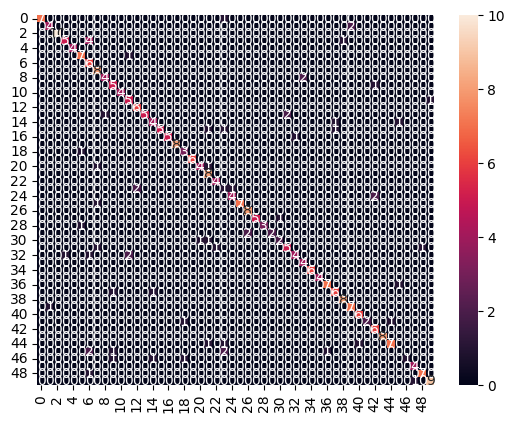

In [238]:
cm = confusion_matrix(np.argmax(Yval, axis=1), np.argmax(model.predict(Xval), axis=1))

sns.heatmap(cm, annot = True)

print(classification_report(np.argmax(Yval, axis=1), np.argmax(model.predict(Xval), axis=1)))

In [237]:
np.argmax(model.predict(Xval), axis=1)

11/11 [==============================] - 0s 10ms/step


array([ 0, 23,  0,  0, 39,  1,  1,  2,  2,  2,  2,  2,  6,  3,  3,  3,  3,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8, 33,  9,
        9,  9, 10, 10, 11, 11, 11, 12, 12, 12,  8, 13, 31, 13, 45, 37, 14,
       23, 15, 21, 15, 16, 16, 16, 17, 17, 17, 17,  5, 18, 19, 19, 19, 20,
        7, 20, 21, 21, 21, 21, 22, 22, 24, 12, 24, 42, 24, 25, 25,  7, 25,
       26, 26, 26, 26, 27, 27, 27, 28, 28, 29, 26, 21, 30, 31, 48, 31, 31,
       11, 32, 32,  3, 33, 33, 34, 34, 34, 35, 35, 36, 45, 36, 36, 37, 14,
       37, 37, 38, 38, 38, 38, 39, 39,  1, 39, 40, 40, 40, 18, 41, 42, 42,
       42, 43, 43, 43, 43, 23, 44, 44, 40, 44,  6, 23,  6, 14,  9, 47, 47,
       48, 48, 48, 48, 49, 49, 49, 49, 49,  0,  0,  0,  0, 39,  1,  1,  2,
        2,  2,  2,  2,  6,  3,  6, 38,  6,  4,  4,  5,  5, 11,  5,  6,  6,
        6,  7,  7,  7,  7,  8,  8, 33,  9, 42,  9, 10, 10, 11, 11, 49, 12,
       12, 12, 13, 13, 13, 31, 14, 14, 14, 15, 15, 37, 15, 16, 16, 32, 17,
       17, 17, 17, 18, 18

In [236]:
np.argmax(Yval, axis=1)

array([ 0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  9,
        9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,
       15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 18, 18, 19, 19, 19, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 23, 23, 24, 24, 24, 25, 25, 25, 25,
       26, 26, 26, 26, 27, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 31, 31,
       32, 32, 32, 32, 33, 33, 34, 34, 34, 35, 35, 36, 36, 36, 36, 37, 37,
       37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 41, 41, 42, 42,
       42, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 46, 46, 47, 47,
       48, 48, 48, 48, 49, 49, 49, 49, 49,  0,  0,  0,  0,  1,  1,  1,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12,
       12, 12, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 17,
       17, 17, 17, 18, 18

## Hyperparameter Tunning 2 1D CNN Layers + 3 GRU

In [145]:
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping


/tmp/ipykernel_362142/1222377179.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [175]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D, GRU
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        act_function = hp.Choice('dense_activation',values=['selu','LeakyReLU','gelu','elu'],default='selu')
        model = Sequential()
        model.add(Conv1D(filters=hp.Choice('num_filters_1',values=[25,50,75, 100,150],default=150,),kernel_size=hp.Choice('kernel_1',values=[2,3,4,5],default=3,),activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=hp.Choice('pool_1',values=[2,3,4,5],default=3,)))
        model.add(Conv1D(filters=hp.Choice('num_filters_2',values=[25,50,75, 100,150],default=150,),kernel_size=hp.Choice('kernel_2',values=[2,3,4,5],default=3,),activation=act_function))
        model.add(MaxPooling1D(pool_size=hp.Choice('pool_2',values=[2,3,4,5],default=3,)))
#        model.add(Conv1D(filters=hp.Choice('num_filters_3',values=[25,50, 100,150],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
#        model.add(MaxPooling1D(pool_size=2))
        model.add(GRU(units=hp.Int('units_1',min_value=50,max_value=200,step=50,default=200),return_sequences=True))
        model.add(GRU(units=hp.Int('units_2',min_value=50,max_value=200,step=50,default=150),return_sequences=True))
        model.add(GRU(units=hp.Int('units_3',min_value=50,max_value=200,step=50,default=100),return_sequences=True))
        model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.7,default=0.65,step=0.05,)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units_4',min_value=20,max_value=120,step=20,default=40),activation=act_function))
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.7,default=0.0,step=0.05,)))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(tf.optimizers.experimental.Nadam(hp.Float('learning_rate',min_value=1e-7,max_value=1e-4,sampling='LOG',default=0.00002)),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=(130,126), num_classes=50)

In [177]:
HYPERBAND_MAX_EPOCHS = 300
#MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_loss',
    seed=10,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='/media/kristian/HDD/ASL_Citizen/Mediapipe/hyperband/',
    project_name='2CNN-3GRU',
    overwrite=True)

In [178]:
tuner.search_space_summary()

Search space summary
Default search space size: 14
dense_activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['selu', 'LeakyReLU', 'gelu', 'elu'], 'ordered': False}
num_filters_1 (Choice)
{'default': 150, 'conditions': [], 'values': [25, 50, 75, 100, 150], 'ordered': True}
kernel_1 (Choice)
{'default': 3, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
pool_1 (Choice)
{'default': 3, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
num_filters_2 (Choice)
{'default': 150, 'conditions': [], 'values': [25, 50, 75, 100, 150], 'ordered': True}
kernel_2 (Choice)
{'default': 3, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
pool_2 (Choice)
{'default': 3, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
units_1 (Int)
{'default': 200, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
units_2 (Int)
{'default': 150, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
u

In [179]:
es = EarlyStopping(monitor="val_loss",patience=30,restore_best_weights=True)

In [180]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [181]:
tuner.search(Xtrain, Ytrain, epochs=1000, validation_data=(Xval,Yval),batch_size=96,callbacks=[es])

Trial 725 Complete [00h 16m 39s]
val_loss: 3.8870142698287964

Best val_loss So Far: 1.0019769072532654
Total elapsed time: 10h 27m 09s
INFO:tensorflow:Oracle triggered exit


In [182]:
best_model = tuner.get_best_models(num_models=1)[0]

In [183]:
tuner.results_summary()

Results summary
Results in /media/kristian/HDD/ASL_Citizen/Mediapipe/hyperband/2CNN-3GRU
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0423 summary
Hyperparameters:
dense_activation: selu
num_filters_1: 75
kernel_1: 4
pool_1: 4
num_filters_2: 100
kernel_2: 2
pool_2: 2
units_1: 50
units_2: 100
units_3: 50
dropout_1: 0.0
units_4: 100
dropout_2: 0.45
learning_rate: 9.32064685337975e-05
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 5
tuner/round: 4
tuner/trial_id: 0414
Score: 1.0019769072532654

Trial 0426 summary
Hyperparameters:
dense_activation: selu
num_filters_1: 75
kernel_1: 4
pool_1: 4
num_filters_2: 100
kernel_2: 2
pool_2: 2
units_1: 50
units_2: 100
units_3: 50
dropout_1: 0.0
units_4: 100
dropout_2: 0.45
learning_rate: 9.32064685337975e-05
tuner/epochs: 300
tuner/initial_epoch: 100
tuner/bracket: 5
tuner/round: 5
tuner/trial_id: 0423
Score: 1.0033312439918518

Trial 0670 summary
Hyperparameters:
dense_activation: LeakyReLU
num_filters_1: 100
k

In [184]:
loss, accuracy = best_model.evaluate(Xval, Yval)

11/11 [==============================] - 2s 10ms/step - loss: 1.0014 - accuracy: 0.7623


In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

11/11 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.80      0.67      0.73         6
           2       0.91      1.00      0.95        10
           3       0.88      0.70      0.78        10
           4       1.00      1.00      1.00         4
           5       0.67      1.00      0.80         8
           6       0.45      0.83      0.59         6
           7       1.00      0.88      0.93         8
           8       1.00      0.33      0.50         6
           9       1.00      0.83      0.91         6
          10       1.00      1.00      1.00         4
          11       0.83      0.83      0.83         6
          12       0.80      0.67      0.73         6
          13       1.00      0.75      0.86         8
          14       0.55      1.00      0.71         6
          15       0.86      0.75      0.80         8
          16       0.86    

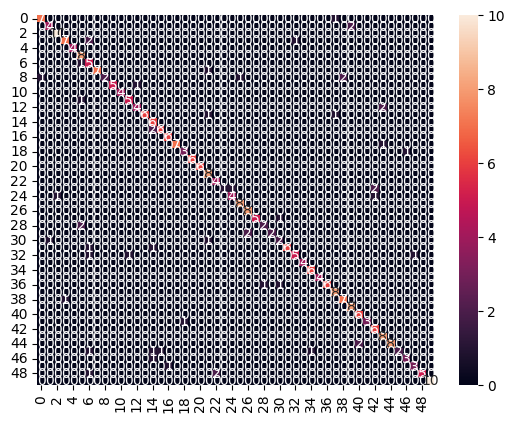

In [46]:
cm = confusion_matrix(np.argmax(Yval, axis=1), np.argmax(best_model.predict(Xval), axis=1))

sns.heatmap(cm, annot = True)

print(classification_report(np.argmax(Yval, axis=1), np.argmax(best_model.predict(Xval), axis=1)))

In [47]:
np.argmax(best_model.predict(Xval), axis=1)

11/11 [==============================] - 0s 10ms/step


array([ 0, 37,  0,  0, 39,  1,  1,  2,  2,  2,  2,  2,  6,  3,  3,  3, 32,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7, 25,  8,  0,  9,
        9,  9, 10, 10, 11, 11, 11, 12, 12, 43, 21, 13, 13, 13, 14, 14, 14,
       15, 15, 14, 15, 16, 16, 16, 17, 17, 17, 17, 46, 18, 19, 19, 19, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 24, 42, 24, 42, 24, 25, 25, 25, 25,
       26, 26, 26, 26, 27, 27, 27,  5, 28, 29, 26, 21, 30, 31,  6, 31, 31,
       47, 32, 32, 32, 33, 33, 34, 34, 34, 35, 35, 36, 36, 36, 36, 37, 37,
       37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 18, 41, 42, 42,
       42, 43, 43, 43, 43, 44, 44, 44, 40, 44, 45, 15,  6, 14, 46, 47, 47,
       22, 48,  6, 48, 49, 49, 49, 49, 49,  0,  0,  0,  0, 39,  1,  1,  2,
        2,  2,  2,  2,  6,  3,  3,  3,  3,  4,  4,  5,  5,  5,  5,  5,  6,
        6, 21,  7,  7,  7, 38,  8, 38,  9, 12,  9, 10, 10, 11, 11,  5, 12,
       12, 43, 13, 37, 13, 13, 14, 14, 14, 15, 15, 14, 15, 16, 16, 16, 17,
       17, 43, 17, 18, 18

In [48]:
np.argmax(Yval, axis=1)

array([ 0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  9,
        9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,
       15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 18, 18, 19, 19, 19, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 23, 23, 24, 24, 24, 25, 25, 25, 25,
       26, 26, 26, 26, 27, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 31, 31,
       32, 32, 32, 32, 33, 33, 34, 34, 34, 35, 35, 36, 36, 36, 36, 37, 37,
       37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 41, 41, 42, 42,
       42, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 46, 46, 47, 47,
       48, 48, 48, 48, 49, 49, 49, 49, 49,  0,  0,  0,  0,  1,  1,  1,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12,
       12, 12, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 17,
       17, 17, 17, 18, 18

## Hyperparameter Tuning 3 GRU Layers

In [71]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D, GRU
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        act_function = hp.Choice('dense_activation',values=['selu','LeakyReLU','elu','gelu'],default='selu')
        model = Sequential()
#        model.add(Conv1D(filters=hp.Choice('num_filters_1',values=[25,50, 100,150],default=100,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
#        model.add(MaxPooling1D(pool_size=2))
#        model.add(Conv1D(filters=hp.Choice('num_filters_2',values=[25,50, 100,150],default=25,),kernel_size=2,activation=act_function))
#        model.add(MaxPooling1D(pool_size=2))
#        model.add(Conv1D(filters=hp.Choice('num_filters_3',values=[25,50, 100,150],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
#        model.add(MaxPooling1D(pool_size=2))
        model.add(GRU(units=hp.Int('units_1',min_value=1,max_value=200,step=50,default=200),return_sequences=True, input_shape=self.input_shape))
        model.add(GRU(units=hp.Int('units_2',min_value=1,max_value=200,step=50,default=150),return_sequences=True))
        model.add(GRU(units=hp.Int('units_3',min_value=1,max_value=200,step=50,default=100),return_sequences=False))
        model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.7,default=0.65,step=0.05,)))
 #       model.add(Flatten())
        model.add(Dense(units=hp.Int('units_4',min_value=20,max_value=120,step=20,default=40),activation=act_function))
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.7,default=0.0,step=0.05,)))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(Adam(hp.Float('learning_rate',min_value=1e-5,max_value=1e-3,sampling='LOG',default=0.00013960407115272237)),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=(130,126), num_classes=50)

/tmp/ipykernel_64262/3598984445.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [72]:
HYPERBAND_MAX_EPOCHS = 100
#MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_loss',
    seed=10,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='/media/kristian/HDD/ASL_Citizen/Mediapipe/hyperband/',
    project_name='GRU',
    overwrite=False)

2023-08-15 06:49:27.726689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 06:49:27.787802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1739 MB memory:  -> device: 0, name: NVIDIA GeForce MX250, pci bus id: 0000:01:00.0, compute capability: 6.1


In [73]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
dense_activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['selu', 'LeakyReLU', 'elu', 'gelu'], 'ordered': False}
units_1 (Int)
{'default': 200, 'conditions': [], 'min_value': 1, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
units_2 (Int)
{'default': 150, 'conditions': [], 'min_value': 1, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
units_3 (Int)
{'default': 100, 'conditions': [], 'min_value': 1, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.65, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
units_4 (Int)
{'default': 40, 'conditions': [], 'min_value': 20, 'max_value': 120, 'step': 20, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.00013960407115272237, 'conditions': [], 'min_value': 1e-05, 'max_

In [74]:
es = EarlyStopping(monitor="val_loss",patience=20,restore_best_weights=True)

In [75]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
tuner.search(Xtrain, Ytrain, validation_data=(Xval,Yval),batch_size=96,callbacks=[es])

Trial 160 Complete [00h 00m 45s]
val_loss: 3.910211682319641

Best val_loss So Far: 1.9025814533233643
Total elapsed time: 01h 57m 10s


In [488]:
np.argmax(best_model.predict(Xval), axis=1)

11/11 [==============================] - 0s 21ms/step


array([ 0, 44,  0,  0, 39,  1,  1,  2,  2,  2,  2,  2,  6,  3,  3,  3,  3,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8, 33,  9,
       42, 45, 10, 10, 11, 11, 11, 12, 12, 42, 31, 13, 13, 13, 45,  6, 14,
       15, 15, 37, 15, 16, 16, 16, 17, 17, 17, 17, 45, 18, 19, 19, 19, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 24, 42, 24, 18, 24, 25, 25, 25, 25,
       26, 26, 26, 26, 27, 27, 27, 28, 28, 29, 26, 41, 30, 31, 48, 31, 31,
       11, 32, 49, 32, 33, 33, 34, 34, 34, 35, 35, 36, 28, 15, 36, 37, 21,
       37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 18, 41, 42, 42,
       42, 43, 43, 43, 43, 44, 44, 44, 40, 44,  6, 34, 45,  5, 18, 47, 47,
       22, 48,  3, 48, 49, 49, 11, 49, 49,  0,  2,  0,  0,  1,  1,  1,  2,
        2,  2,  2,  2,  3,  3,  6,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  0,  9, 18, 42, 10, 10, 11, 11, 11, 12,
       12, 42, 14,  9, 31, 13, 14,  6, 14, 15, 15, 22, 15, 16, 16, 16, 17,
       17, 17, 17, 28, 18

In [489]:
np.argmax(Yval, axis=1)

array([ 0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  9,
        9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,
       15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 18, 18, 19, 19, 19, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 23, 23, 24, 24, 24, 25, 25, 25, 25,
       26, 26, 26, 26, 27, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 31, 31,
       32, 32, 32, 32, 33, 33, 34, 34, 34, 35, 35, 36, 36, 36, 36, 37, 37,
       37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 41, 41, 42, 42,
       42, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 46, 46, 47, 47,
       48, 48, 48, 48, 49, 49, 49, 49, 49,  0,  0,  0,  0,  1,  1,  1,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12,
       12, 12, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 17,
       17, 17, 17, 18, 18

## Hyperparameter Tuning 3 LSTM Layers

In [71]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D, GRU
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        act_function = hp.Choice('dense_activation',values=['selu','LeakyReLU','elu','gelu'],default='selu')
        model = Sequential()
#        model.add(Conv1D(filters=hp.Choice('num_filters_1',values=[25,50, 100,150],default=100,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
#        model.add(MaxPooling1D(pool_size=2))
#        model.add(Conv1D(filters=hp.Choice('num_filters_2',values=[25,50, 100,150],default=25,),kernel_size=2,activation=act_function))
#        model.add(MaxPooling1D(pool_size=2))
#        model.add(Conv1D(filters=hp.Choice('num_filters_3',values=[25,50, 100,150],default=50,),kernel_size=2,activation=act_function,input_shape=self.input_shape))
#        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(units=hp.Int('units_1',min_value=1,max_value=200,step=50,default=200),return_sequences=True, input_shape=self.input_shape))
        model.add(LSTM(units=hp.Int('units_2',min_value=1,max_value=200,step=50,default=150),return_sequences=True))
        model.add(LSTM(units=hp.Int('units_3',min_value=1,max_value=200,step=50,default=100),return_sequences=False))
        model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.7,default=0.65,step=0.05,)))
 #       model.add(Flatten())
        model.add(Dense(units=hp.Int('units_4',min_value=20,max_value=120,step=20,default=40),activation=act_function))
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.7,default=0.0,step=0.05,)))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(Adam(hp.Float('learning_rate',min_value=1e-5,max_value=1e-3,sampling='LOG',default=0.00013960407115272237)),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=(130,126), num_classes=50)

/tmp/ipykernel_64262/3598984445.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [72]:
HYPERBAND_MAX_EPOCHS = 100
#MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_loss',
    seed=10,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='/media/kristian/HDD/ASL_Citizen/Mediapipe/hyperband/',
    project_name='GRU',
    overwrite=False)

2023-08-15 06:49:27.726689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 06:49:27.787802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1739 MB memory:  -> device: 0, name: NVIDIA GeForce MX250, pci bus id: 0000:01:00.0, compute capability: 6.1


In [73]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
dense_activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['selu', 'LeakyReLU', 'elu', 'gelu'], 'ordered': False}
units_1 (Int)
{'default': 200, 'conditions': [], 'min_value': 1, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
units_2 (Int)
{'default': 150, 'conditions': [], 'min_value': 1, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
units_3 (Int)
{'default': 100, 'conditions': [], 'min_value': 1, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.65, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
units_4 (Int)
{'default': 40, 'conditions': [], 'min_value': 20, 'max_value': 120, 'step': 20, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.7, 'step': 0.05, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.00013960407115272237, 'conditions': [], 'min_value': 1e-05, 'max_

In [74]:
es = EarlyStopping(monitor="val_loss",patience=20,restore_best_weights=True)

In [75]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
tuner.search(Xtrain, Ytrain, validation_data=(Xval,Yval),batch_size=96,callbacks=[es])

Trial 160 Complete [00h 00m 45s]
val_loss: 3.910211682319641

Best val_loss So Far: 1.9025814533233643
Total elapsed time: 01h 57m 10s


In [488]:
np.argmax(best_model.predict(Xval), axis=1)

11/11 [==============================] - 0s 21ms/step


array([ 0, 44,  0,  0, 39,  1,  1,  2,  2,  2,  2,  2,  6,  3,  3,  3,  3,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8, 33,  9,
       42, 45, 10, 10, 11, 11, 11, 12, 12, 42, 31, 13, 13, 13, 45,  6, 14,
       15, 15, 37, 15, 16, 16, 16, 17, 17, 17, 17, 45, 18, 19, 19, 19, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 24, 42, 24, 18, 24, 25, 25, 25, 25,
       26, 26, 26, 26, 27, 27, 27, 28, 28, 29, 26, 41, 30, 31, 48, 31, 31,
       11, 32, 49, 32, 33, 33, 34, 34, 34, 35, 35, 36, 28, 15, 36, 37, 21,
       37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 18, 41, 42, 42,
       42, 43, 43, 43, 43, 44, 44, 44, 40, 44,  6, 34, 45,  5, 18, 47, 47,
       22, 48,  3, 48, 49, 49, 11, 49, 49,  0,  2,  0,  0,  1,  1,  1,  2,
        2,  2,  2,  2,  3,  3,  6,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  0,  9, 18, 42, 10, 10, 11, 11, 11, 12,
       12, 42, 14,  9, 31, 13, 14,  6, 14, 15, 15, 22, 15, 16, 16, 16, 17,
       17, 17, 17, 28, 18

In [489]:
np.argmax(Yval, axis=1)

array([ 0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  9,
        9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,
       15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 18, 18, 19, 19, 19, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 23, 23, 24, 24, 24, 25, 25, 25, 25,
       26, 26, 26, 26, 27, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 31, 31,
       32, 32, 32, 32, 33, 33, 34, 34, 34, 35, 35, 36, 36, 36, 36, 37, 37,
       37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 41, 41, 42, 42,
       42, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 46, 46, 47, 47,
       48, 48, 48, 48, 49, 49, 49, 49, 49,  0,  0,  0,  0,  1,  1,  1,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12,
       12, 12, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 17,
       17, 17, 17, 18, 18

## Hyperparameter Tuning 4 1D CNN Layers

In [49]:
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping


/tmp/ipykernel_8299/1222377179.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [50]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SpatialDropout1D, GRU
import keras_tuner
from keras_tuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        act_function = hp.Choice('dense_activation',values=['selu','LeakyReLU','gelu','elu'],default='elu')
        model = Sequential()
        model.add(Conv1D(filters=hp.Choice('num_filters_1',values=[100,125,150,200],default=150,),kernel_size=hp.Choice('kernel_1',values=[2,3,4,5],default=2,),activation=act_function,input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=hp.Choice('num_filters_2',values=[100,125,150,200],default=150,),kernel_size=hp.Choice('kernel_2',values=[2,3,4,5],default=2,),activation=act_function))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=hp.Choice('num_filters_3',values=[100,125,150,200],default=150,),kernel_size=hp.Choice('kernel_3',values=[2,3,4,5],default=2,),activation=act_function))
        model.add(MaxPooling1D(pool_size=2))
#        model.add(Conv1D(filters=hp.Choice('num_filters_4',values=[50,100,150,200],default=150,),kernel_size=hp.Choice('kernel_4',values=[2,3,4,5],default=2,),activation=act_function))
#        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.5,max_value=0.9,default=0.8,step=0.05,)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units_5',min_value=70,max_value=120,step=10,default=80),activation=act_function))
        model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.5,max_value=0.9,default=0.8,step=0.05,)))
        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(tf.optimizers.experimental.Nadam(hp.Float('learning_rate',min_value=1e-4,max_value=1e-2,sampling='LOG',default=.0008273819395816823)),
            loss='categorical_crossentropy',
            metrics=[tfa.metrics.F1Score(num_classes=50, average='macro')]
        )
        return model

hypermodel = CNNHyperModel(input_shape=(130,126), num_classes=50)

/home/kristian/miniconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [52]:
HYPERBAND_MAX_EPOCHS = 300
#MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    seed=10,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='/media/kristian/HDD/ASL_Citizen/Mediapipe/hyperband/',
    project_name='3_1D_CNN_2',
    overwrite=False)

In [53]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
dense_activation (Choice)
{'default': 'elu', 'conditions': [], 'values': ['selu', 'LeakyReLU', 'gelu', 'elu'], 'ordered': False}
num_filters_1 (Choice)
{'default': 150, 'conditions': [], 'values': [100, 125, 150, 200], 'ordered': True}
kernel_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
num_filters_2 (Choice)
{'default': 150, 'conditions': [], 'values': [100, 125, 150, 200], 'ordered': True}
kernel_2 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
num_filters_3 (Choice)
{'default': 150, 'conditions': [], 'values': [100, 125, 150, 200], 'ordered': True}
kernel_3 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
dropout_1 (Float)
{'default': 0.8, 'conditions': [], 'min_value': 0.5, 'max_value': 0.9, 'step': 0.05, 'sampling': 'linear'}
units_5 (Int)
{'default': 80, 'conditions': [], 'min_value': 70, 'max_value': 120, 'step': 10, 'sa

In [54]:
es = EarlyStopping(monitor="val_f1_score",patience=30,restore_best_weights=True,mode="max")

In [55]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
tuner.search(Xtrain, Ytrain, epochs=1000, validation_data=(Xval,Yval),batch_size=96,callbacks=[es])

Trial 8 Complete [00h 00m 11s]
val_f1_score: 0.04849547706544399

Best val_f1_score So Far: 0.127159271389246
Total elapsed time: 00h 01m 41s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
LeakyReLU         |selu              |dense_activation
125               |150               |num_filters_1
2                 |4                 |kernel_1
150               |150               |num_filters_2
2                 |3                 |kernel_2
200               |150               |num_filters_3
5                 |4                 |kernel_3
0.85              |0.55              |dropout_1
110               |90                |units_5
0.6               |0.65              |dropout_2
0.00018241        |0.0019004         |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
5                 |5                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


2023-08-23 23:43:57.504375: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


28/28 [==============================] - ETA: 0s - loss: 3.9681 - f1_score: 0.0180

2023-08-23 23:44:00.229789: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


28/28 [==============================] - 5s 59ms/step - loss: 3.9681 - f1_score: 0.0180 - val_loss: 3.9055 - val_f1_score: 0.0058
Epoch 2/2
28/28 [==============================] - 1s 31ms/step - loss: 3.9103 - f1_score: 0.0148 - val_loss: 3.8981 - val_f1_score: 0.0145
Epoch 1/2


In [197]:
best_model = tuner.get_best_models(num_models=3)[0]

In [167]:
tuner.results_summary()

Results summary
Results in /media/kristian/HDD/ASL_Citizen/Mediapipe/hyperband/4_1D_CNN_2
Showing 10 best trials
Objective(name="val_f1_score", direction="max")

Trial 0599 summary
Hyperparameters:
dense_activation: gelu
num_filters_1: 200
kernel_1: 2
num_filters_2: 200
kernel_2: 4
num_filters_3: 150
kernel_3: 5
dropout_1: 0.5
units_5: 100
dropout_2: 0.7
learning_rate: 0.0015664483309874415
tuner/epochs: 300
tuner/initial_epoch: 100
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0593
Score: 0.8009045422077179

Trial 0714 summary
Hyperparameters:
dense_activation: elu
num_filters_1: 150
kernel_1: 5
num_filters_2: 125
kernel_2: 5
num_filters_3: 200
kernel_3: 3
dropout_1: 0.75
units_5: 120
dropout_2: 0.65
learning_rate: 0.000332180455993387
tuner/epochs: 300
tuner/initial_epoch: 100
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0703
Score: 0.798288881778717

Trial 0718 summary
Hyperparameters:
dense_activation: elu
num_filters_1: 200
kernel_1: 5
num_filters_2: 100
kernel_2: 3
num_filte

In [198]:
loss, accuracy = best_model.evaluate(Xval, Yval)

2023-08-23 22:47:35.152206: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


11/11 [==============================] - 4s 27ms/step - loss: 1.1782 - f1_score: 0.8031


In [207]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [216]:
#cm = confusion_matrix(np.argmax(Yval, axis=1), np.argmax(model.predict(Xval), axis=1))

#sns.heatmap(cm, annot = True)

print(classification_report(np.argmax(Yval, axis=1), np.argmax(reconstructed_model.predict(Xval), axis=1)))

11/11 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.75      1.00      0.86         6
           2       0.83      1.00      0.91        10
           3       0.88      0.70      0.78        10
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         8
           6       0.55      1.00      0.71         6
           7       0.80      1.00      0.89         8
           8       1.00      0.50      0.67         6
           9       0.71      0.83      0.77         6
          10       1.00      1.00      1.00         4
          11       0.86      1.00      0.92         6
          12       1.00      0.67      0.80         6
          13       0.86      0.75      0.80         8
          14       0.67      0.67      0.67         6
          15       0.75      0.75      0.75         8
          16       1.00     

In [184]:
np.argmax(best_model.predict(Xval), axis=1)

11/11 [==============================] - 0s 7ms/step


array([ 0, 37,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  6,  3,  3,  3,  6,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8, 17,  9,
        9,  9, 10, 10, 11, 11, 11, 12, 12, 35, 14, 37, 31, 13, 45, 37, 14,
       15, 15, 24, 15, 16, 16, 16, 17, 17, 17, 17, 46, 18, 19, 19, 19, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 23, 42, 24, 42, 24, 25, 25, 25, 25,
       26, 26, 26, 26, 27, 27, 27, 28, 28, 29, 26,  1, 30, 31,  6, 31, 31,
       47, 32, 32,  6, 33, 33, 34, 34, 23, 35, 35, 36, 28, 34, 36, 37, 37,
        9, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 41, 41, 42, 42,
       42, 43, 43, 43, 43, 41, 44, 44, 44, 44,  6, 37,  6,  5, 42, 47, 47,
       48, 48, 48, 48, 49, 49, 49, 49, 49,  0, 37,  0,  0, 39,  1,  1,  2,
        2,  2,  2,  2,  6,  3,  3,  3,  6,  4,  4,  5,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  7, 38,  8, 17,  9, 46,  9, 10, 10, 11, 11, 11, 12,
       12, 24, 13, 14, 13, 13, 14, 14, 14, 15, 15, 24, 15, 16, 16, 16, 17,
       17, 17, 17, 18, 18

In [185]:
np.argmax(Yval, axis=1)

array([ 0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  9,
        9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,
       15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 18, 18, 19, 19, 19, 20,
       20, 20, 21, 21, 21, 21, 22, 22, 23, 23, 24, 24, 24, 25, 25, 25, 25,
       26, 26, 26, 26, 27, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 31, 31,
       32, 32, 32, 32, 33, 33, 34, 34, 34, 35, 35, 36, 36, 36, 36, 37, 37,
       37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 41, 41, 42, 42,
       42, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 46, 46, 47, 47,
       48, 48, 48, 48, 49, 49, 49, 49, 49,  0,  0,  0,  0,  1,  1,  1,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  5,  5,  5,  5,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12,
       12, 12, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 17,
       17, 17, 17, 18, 18

In [199]:
#bestHP = tuner.get_best_hyperparameters(num_trials=5)[2]
bestHP = tuner.get_best_hyperparameters(num_trials=5)[2]

In [212]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model/',
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)

In [213]:
print("[INFO] training the best model...")
model = tuner.hypermodel.build(bestHP)
History = model.fit(x=Xtrain, y=Ytrain,validation_data= (Xval,Yval), batch_size=96,epochs=500, verbose=1,callbacks=[model_checkpoint_callback])

[INFO] training the best model...
Epoch 1/500
27/28 [===========================>..] - ETA: 0s - loss: 4.1188 - f1_score: 0.0196

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 10s 287ms/step - loss: 4.1166 - f1_score: 0.0193 - val_loss: 3.9013 - val_f1_score: 0.0586
Epoch 2/500
28/28 [==============================] - 1s 35ms/step - loss: 4.0031 - f1_score: 0.0192 - val_loss: 3.8677 - val_f1_score: 0.0301
Epoch 3/500
28/28 [==============================] - 1s 35ms/step - loss: 3.9711 - f1_score: 0.0286 - val_loss: 3.8331 - val_f1_score: 0.0476
Epoch 4/500
28/28 [==============================] - 1s 36ms/step - loss: 3.9119 - f1_score: 0.0353 - val_loss: 3.7936 - val_f1_score: 0.0433
Epoch 5/500
27/28 [===========================>..] - ETA: 0s - loss: 3.8669 - f1_score: 0.0414

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 168ms/step - loss: 3.8702 - f1_score: 0.0418 - val_loss: 3.7464 - val_f1_score: 0.0740
Epoch 6/500
27/28 [===========================>..] - ETA: 0s - loss: 3.8443 - f1_score: 0.0484

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 199ms/step - loss: 3.8466 - f1_score: 0.0479 - val_loss: 3.6856 - val_f1_score: 0.0762
Epoch 7/500
28/28 [==============================] - 1s 36ms/step - loss: 3.7926 - f1_score: 0.0501 - val_loss: 3.6147 - val_f1_score: 0.0754
Epoch 8/500
28/28 [==============================] - 1s 36ms/step - loss: 3.7113 - f1_score: 0.0574 - val_loss: 3.5455 - val_f1_score: 0.0596
Epoch 9/500
28/28 [==============================] - 1s 35ms/step - loss: 3.6512 - f1_score: 0.0664 - val_loss: 3.4618 - val_f1_score: 0.0617
Epoch 10/500
27/28 [===========================>..] - ETA: 0s - loss: 3.5877 - f1_score: 0.0832

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 180ms/step - loss: 3.5890 - f1_score: 0.0816 - val_loss: 3.3892 - val_f1_score: 0.0820
Epoch 11/500
27/28 [===========================>..] - ETA: 0s - loss: 3.5328 - f1_score: 0.0866

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 154ms/step - loss: 3.5253 - f1_score: 0.0888 - val_loss: 3.3011 - val_f1_score: 0.0899
Epoch 12/500
27/28 [===========================>..] - ETA: 0s - loss: 3.4711 - f1_score: 0.1027

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 159ms/step - loss: 3.4656 - f1_score: 0.1030 - val_loss: 3.2443 - val_f1_score: 0.1141
Epoch 13/500
27/28 [===========================>..] - ETA: 0s - loss: 3.3926 - f1_score: 0.1122

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 22s 828ms/step - loss: 3.3923 - f1_score: 0.1121 - val_loss: 3.1629 - val_f1_score: 0.1478
Epoch 14/500
27/28 [===========================>..] - ETA: 0s - loss: 3.3236 - f1_score: 0.1194

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 161ms/step - loss: 3.3274 - f1_score: 0.1182 - val_loss: 3.0865 - val_f1_score: 0.1636
Epoch 15/500
27/28 [===========================>..] - ETA: 0s - loss: 3.2564 - f1_score: 0.1186

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 159ms/step - loss: 3.2503 - f1_score: 0.1197 - val_loss: 2.9978 - val_f1_score: 0.1893
Epoch 16/500
27/28 [===========================>..] - ETA: 0s - loss: 3.2265 - f1_score: 0.1295

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 168ms/step - loss: 3.2240 - f1_score: 0.1300 - val_loss: 2.9305 - val_f1_score: 0.2015
Epoch 17/500
27/28 [===========================>..] - ETA: 0s - loss: 3.1844 - f1_score: 0.1439

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 185ms/step - loss: 3.1799 - f1_score: 0.1448 - val_loss: 2.8763 - val_f1_score: 0.2061
Epoch 18/500
27/28 [===========================>..] - ETA: 0s - loss: 3.0765 - f1_score: 0.1627

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 179ms/step - loss: 3.0811 - f1_score: 0.1620 - val_loss: 2.7879 - val_f1_score: 0.2598
Epoch 19/500
27/28 [===========================>..] - ETA: 0s - loss: 3.0063 - f1_score: 0.1840

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 195ms/step - loss: 3.0017 - f1_score: 0.1847 - val_loss: 2.7149 - val_f1_score: 0.3069
Epoch 20/500
27/28 [===========================>..] - ETA: 0s - loss: 2.9614 - f1_score: 0.1685

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 164ms/step - loss: 2.9572 - f1_score: 0.1702 - val_loss: 2.6359 - val_f1_score: 0.3396
Epoch 21/500
27/28 [===========================>..] - ETA: 0s - loss: 2.8919 - f1_score: 0.1925

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 157ms/step - loss: 2.8868 - f1_score: 0.1937 - val_loss: 2.5444 - val_f1_score: 0.3752
Epoch 22/500
27/28 [===========================>..] - ETA: 0s - loss: 2.8297 - f1_score: 0.2073

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 163ms/step - loss: 2.8233 - f1_score: 0.2109 - val_loss: 2.5032 - val_f1_score: 0.3790
Epoch 23/500
27/28 [===========================>..] - ETA: 0s - loss: 2.7471 - f1_score: 0.2272

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 169ms/step - loss: 2.7553 - f1_score: 0.2263 - val_loss: 2.4529 - val_f1_score: 0.4081
Epoch 24/500
27/28 [===========================>..] - ETA: 0s - loss: 2.7794 - f1_score: 0.2154

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 170ms/step - loss: 2.7768 - f1_score: 0.2153 - val_loss: 2.3774 - val_f1_score: 0.4089
Epoch 25/500
27/28 [===========================>..] - ETA: 0s - loss: 2.6633 - f1_score: 0.2610

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 179ms/step - loss: 2.6671 - f1_score: 0.2600 - val_loss: 2.2874 - val_f1_score: 0.4326
Epoch 26/500
28/28 [==============================] - 1s 35ms/step - loss: 2.6094 - f1_score: 0.2660 - val_loss: 2.2260 - val_f1_score: 0.4220
Epoch 27/500
27/28 [===========================>..] - ETA: 0s - loss: 2.5880 - f1_score: 0.2671

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 185ms/step - loss: 2.5810 - f1_score: 0.2679 - val_loss: 2.1859 - val_f1_score: 0.4556
Epoch 28/500
28/28 [==============================] - 1s 36ms/step - loss: 2.4999 - f1_score: 0.2798 - val_loss: 2.1423 - val_f1_score: 0.4490
Epoch 29/500
27/28 [===========================>..] - ETA: 0s - loss: 2.4425 - f1_score: 0.2923

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 183ms/step - loss: 2.4409 - f1_score: 0.2926 - val_loss: 2.0501 - val_f1_score: 0.4880
Epoch 30/500
27/28 [===========================>..] - ETA: 0s - loss: 2.4343 - f1_score: 0.2812

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 185ms/step - loss: 2.4273 - f1_score: 0.2839 - val_loss: 2.0313 - val_f1_score: 0.4885
Epoch 31/500
27/28 [===========================>..] - ETA: 0s - loss: 2.3761 - f1_score: 0.3112

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 164ms/step - loss: 2.3782 - f1_score: 0.3104 - val_loss: 1.9683 - val_f1_score: 0.5188
Epoch 32/500
28/28 [==============================] - 1s 35ms/step - loss: 2.2965 - f1_score: 0.3224 - val_loss: 1.9154 - val_f1_score: 0.5019
Epoch 33/500
28/28 [==============================] - 1s 36ms/step - loss: 2.3094 - f1_score: 0.3341 - val_loss: 1.9231 - val_f1_score: 0.5114
Epoch 34/500
27/28 [===========================>..] - ETA: 0s - loss: 2.2552 - f1_score: 0.3305

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 199ms/step - loss: 2.2539 - f1_score: 0.3296 - val_loss: 1.8274 - val_f1_score: 0.5402
Epoch 35/500
27/28 [===========================>..] - ETA: 0s - loss: 2.1729 - f1_score: 0.3703

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 160ms/step - loss: 2.1721 - f1_score: 0.3695 - val_loss: 1.8348 - val_f1_score: 0.5460
Epoch 36/500
27/28 [===========================>..] - ETA: 0s - loss: 2.1606 - f1_score: 0.3602

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 173ms/step - loss: 2.1621 - f1_score: 0.3617 - val_loss: 1.7827 - val_f1_score: 0.5589
Epoch 37/500
28/28 [==============================] - 1s 36ms/step - loss: 2.0885 - f1_score: 0.3810 - val_loss: 1.7940 - val_f1_score: 0.5421
Epoch 38/500
27/28 [===========================>..] - ETA: 0s - loss: 2.0864 - f1_score: 0.3853

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 32s 1s/step - loss: 2.0799 - f1_score: 0.3871 - val_loss: 1.6919 - val_f1_score: 0.5654
Epoch 39/500
27/28 [===========================>..] - ETA: 0s - loss: 2.0246 - f1_score: 0.3976

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 184ms/step - loss: 2.0215 - f1_score: 0.3969 - val_loss: 1.6841 - val_f1_score: 0.5797
Epoch 40/500
28/28 [==============================] - 1s 35ms/step - loss: 2.0117 - f1_score: 0.3959 - val_loss: 1.6439 - val_f1_score: 0.5622
Epoch 41/500
28/28 [==============================] - 1s 35ms/step - loss: 2.0091 - f1_score: 0.4077 - val_loss: 1.6561 - val_f1_score: 0.5699
Epoch 42/500
27/28 [===========================>..] - ETA: 0s - loss: 1.9993 - f1_score: 0.4098

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 189ms/step - loss: 1.9985 - f1_score: 0.4081 - val_loss: 1.6006 - val_f1_score: 0.5816
Epoch 43/500
28/28 [==============================] - 1s 35ms/step - loss: 1.8981 - f1_score: 0.4374 - val_loss: 1.6074 - val_f1_score: 0.5761
Epoch 44/500
27/28 [===========================>..] - ETA: 0s - loss: 1.9202 - f1_score: 0.4419

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 190ms/step - loss: 1.9218 - f1_score: 0.4429 - val_loss: 1.5717 - val_f1_score: 0.6066
Epoch 45/500
27/28 [===========================>..] - ETA: 0s - loss: 1.9216 - f1_score: 0.4317

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 153ms/step - loss: 1.9269 - f1_score: 0.4329 - val_loss: 1.5538 - val_f1_score: 0.6077
Epoch 46/500
28/28 [==============================] - 1s 35ms/step - loss: 1.8949 - f1_score: 0.4439 - val_loss: 1.5215 - val_f1_score: 0.6037
Epoch 47/500
27/28 [===========================>..] - ETA: 0s - loss: 1.8518 - f1_score: 0.4584

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 4s 157ms/step - loss: 1.8485 - f1_score: 0.4594 - val_loss: 1.4850 - val_f1_score: 0.6335
Epoch 48/500
27/28 [===========================>..] - ETA: 0s - loss: 1.8109 - f1_score: 0.4652

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 171ms/step - loss: 1.8191 - f1_score: 0.4612 - val_loss: 1.4896 - val_f1_score: 0.6372
Epoch 49/500
27/28 [===========================>..] - ETA: 0s - loss: 1.8581 - f1_score: 0.4543

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 196ms/step - loss: 1.8510 - f1_score: 0.4532 - val_loss: 1.4752 - val_f1_score: 0.6372
Epoch 50/500
28/28 [==============================] - 1s 35ms/step - loss: 1.7873 - f1_score: 0.4624 - val_loss: 1.4511 - val_f1_score: 0.6284
Epoch 51/500
28/28 [==============================] - 1s 36ms/step - loss: 1.7872 - f1_score: 0.4684 - val_loss: 1.4553 - val_f1_score: 0.6181
Epoch 52/500
28/28 [==============================] - 1s 36ms/step - loss: 1.7610 - f1_score: 0.4716 - val_loss: 1.4317 - val_f1_score: 0.6116
Epoch 53/500
28/28 [==============================] - 1s 36ms/step - loss: 1.7280 - f1_score: 0.4727 - val_loss: 1.4882 - val_f1_score: 0.6279
Epoch 54/500
28/28 [==============================] - 1s 36ms/step - loss: 1.7237 - f1_score: 0.4780 - val_loss: 1.4520 - val_f1_score: 0.6258
Epoch 55/500
28/28 [==============================] - 1s 36ms/step - loss: 1.7186 - f1_score: 0.4932 - val_loss: 1.3936 - val_f1_score: 0.6112
Epoch 56/50

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 180ms/step - loss: 1.6794 - f1_score: 0.5187 - val_loss: 1.3727 - val_f1_score: 0.6547
Epoch 57/500
28/28 [==============================] - 1s 36ms/step - loss: 1.6852 - f1_score: 0.5029 - val_loss: 1.3411 - val_f1_score: 0.6501
Epoch 58/500
27/28 [===========================>..] - ETA: 0s - loss: 1.6300 - f1_score: 0.5172

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 187ms/step - loss: 1.6365 - f1_score: 0.5146 - val_loss: 1.3697 - val_f1_score: 0.6668
Epoch 59/500
28/28 [==============================] - 1s 36ms/step - loss: 1.6248 - f1_score: 0.5090 - val_loss: 1.3478 - val_f1_score: 0.6471
Epoch 60/500
28/28 [==============================] - 1s 36ms/step - loss: 1.6485 - f1_score: 0.4977 - val_loss: 1.3412 - val_f1_score: 0.6485
Epoch 61/500
28/28 [==============================] - 1s 36ms/step - loss: 1.6041 - f1_score: 0.5280 - val_loss: 1.3348 - val_f1_score: 0.6321
Epoch 62/500
28/28 [==============================] - 1s 36ms/step - loss: 1.5782 - f1_score: 0.5249 - val_loss: 1.2991 - val_f1_score: 0.6568
Epoch 63/500
28/28 [==============================] - 1s 36ms/step - loss: 1.5941 - f1_score: 0.5209 - val_loss: 1.3133 - val_f1_score: 0.6509
Epoch 64/500
27/28 [===========================>..] - ETA: 0s - loss: 1.4947 - f1_score: 0.5459

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 198ms/step - loss: 1.4974 - f1_score: 0.5476 - val_loss: 1.3162 - val_f1_score: 0.6700
Epoch 65/500
28/28 [==============================] - 1s 36ms/step - loss: 1.5895 - f1_score: 0.5190 - val_loss: 1.2892 - val_f1_score: 0.6586
Epoch 66/500
27/28 [===========================>..] - ETA: 0s - loss: 1.5348 - f1_score: 0.5457

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 175ms/step - loss: 1.5326 - f1_score: 0.5470 - val_loss: 1.2835 - val_f1_score: 0.6740
Epoch 67/500
27/28 [===========================>..] - ETA: 0s - loss: 1.5699 - f1_score: 0.5304

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 173ms/step - loss: 1.5621 - f1_score: 0.5341 - val_loss: 1.2566 - val_f1_score: 0.6796
Epoch 68/500
27/28 [===========================>..] - ETA: 0s - loss: 1.4917 - f1_score: 0.5568

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 201ms/step - loss: 1.4945 - f1_score: 0.5570 - val_loss: 1.2534 - val_f1_score: 0.6851
Epoch 69/500
28/28 [==============================] - 1s 37ms/step - loss: 1.4831 - f1_score: 0.5572 - val_loss: 1.2858 - val_f1_score: 0.6565
Epoch 70/500
28/28 [==============================] - 1s 36ms/step - loss: 1.4904 - f1_score: 0.5540 - val_loss: 1.2446 - val_f1_score: 0.6831
Epoch 71/500
28/28 [==============================] - 1s 37ms/step - loss: 1.4274 - f1_score: 0.5801 - val_loss: 1.2598 - val_f1_score: 0.6701
Epoch 72/500
27/28 [===========================>..] - ETA: 0s - loss: 1.4776 - f1_score: 0.5614

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 193ms/step - loss: 1.4822 - f1_score: 0.5601 - val_loss: 1.2088 - val_f1_score: 0.6855
Epoch 73/500
27/28 [===========================>..] - ETA: 0s - loss: 1.3840 - f1_score: 0.5871

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 170ms/step - loss: 1.3842 - f1_score: 0.5878 - val_loss: 1.2044 - val_f1_score: 0.6963
Epoch 74/500
28/28 [==============================] - 1s 36ms/step - loss: 1.4235 - f1_score: 0.5776 - val_loss: 1.2119 - val_f1_score: 0.6796
Epoch 75/500
28/28 [==============================] - 1s 36ms/step - loss: 1.4081 - f1_score: 0.5618 - val_loss: 1.1845 - val_f1_score: 0.6850
Epoch 76/500
27/28 [===========================>..] - ETA: 0s - loss: 1.4107 - f1_score: 0.5723

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 18s 684ms/step - loss: 1.4098 - f1_score: 0.5721 - val_loss: 1.1772 - val_f1_score: 0.7065
Epoch 77/500
28/28 [==============================] - 1s 36ms/step - loss: 1.3912 - f1_score: 0.5765 - val_loss: 1.1959 - val_f1_score: 0.7043
Epoch 78/500
27/28 [===========================>..] - ETA: 0s - loss: 1.4102 - f1_score: 0.5722

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 172ms/step - loss: 1.4025 - f1_score: 0.5729 - val_loss: 1.1871 - val_f1_score: 0.7198
Epoch 79/500
28/28 [==============================] - 1s 35ms/step - loss: 1.3849 - f1_score: 0.5754 - val_loss: 1.1865 - val_f1_score: 0.7087
Epoch 80/500
28/28 [==============================] - 1s 36ms/step - loss: 1.3697 - f1_score: 0.5968 - val_loss: 1.2492 - val_f1_score: 0.6728
Epoch 81/500
28/28 [==============================] - 1s 36ms/step - loss: 1.3495 - f1_score: 0.5848 - val_loss: 1.1951 - val_f1_score: 0.7101
Epoch 82/500
28/28 [==============================] - 1s 36ms/step - loss: 1.3765 - f1_score: 0.5922 - val_loss: 1.1733 - val_f1_score: 0.6752
Epoch 83/500
28/28 [==============================] - 1s 36ms/step - loss: 1.3146 - f1_score: 0.5928 - val_loss: 1.1945 - val_f1_score: 0.7113
Epoch 84/500
28/28 [==============================] - 1s 36ms/step - loss: 1.3319 - f1_score: 0.5908 - val_loss: 1.2064 - val_f1_score: 0.6784
Epoch 85/50

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 194ms/step - loss: 1.3184 - f1_score: 0.5939 - val_loss: 1.1552 - val_f1_score: 0.7200
Epoch 86/500
28/28 [==============================] - 1s 36ms/step - loss: 1.2832 - f1_score: 0.5994 - val_loss: 1.1668 - val_f1_score: 0.7049
Epoch 87/500
28/28 [==============================] - 1s 36ms/step - loss: 1.3068 - f1_score: 0.5991 - val_loss: 1.1313 - val_f1_score: 0.7102
Epoch 88/500
28/28 [==============================] - 1s 36ms/step - loss: 1.2915 - f1_score: 0.6111 - val_loss: 1.1660 - val_f1_score: 0.6998
Epoch 89/500
28/28 [==============================] - 1s 36ms/step - loss: 1.2398 - f1_score: 0.6261 - val_loss: 1.1204 - val_f1_score: 0.6991
Epoch 90/500
27/28 [===========================>..] - ETA: 0s - loss: 1.2772 - f1_score: 0.6156

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 191ms/step - loss: 1.2754 - f1_score: 0.6140 - val_loss: 1.1133 - val_f1_score: 0.7366
Epoch 91/500
28/28 [==============================] - 1s 36ms/step - loss: 1.2887 - f1_score: 0.6096 - val_loss: 1.1120 - val_f1_score: 0.7163
Epoch 92/500
28/28 [==============================] - 1s 36ms/step - loss: 1.2685 - f1_score: 0.6110 - val_loss: 1.1612 - val_f1_score: 0.7006
Epoch 93/500
28/28 [==============================] - 1s 36ms/step - loss: 1.2880 - f1_score: 0.5972 - val_loss: 1.1012 - val_f1_score: 0.7358
Epoch 94/500
28/28 [==============================] - 1s 36ms/step - loss: 1.2593 - f1_score: 0.6217 - val_loss: 1.1730 - val_f1_score: 0.6889
Epoch 95/500
28/28 [==============================] - 1s 36ms/step - loss: 1.2095 - f1_score: 0.6382 - val_loss: 1.1669 - val_f1_score: 0.6987
Epoch 96/500
28/28 [==============================] - 1s 36ms/step - loss: 1.1988 - f1_score: 0.6477 - val_loss: 1.1257 - val_f1_score: 0.7177
Epoch 97/50

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 13s 481ms/step - loss: 1.1562 - f1_score: 0.6415 - val_loss: 1.0578 - val_f1_score: 0.7456
Epoch 106/500
28/28 [==============================] - 1s 36ms/step - loss: 1.1450 - f1_score: 0.6424 - val_loss: 1.1065 - val_f1_score: 0.7211
Epoch 107/500
28/28 [==============================] - 1s 36ms/step - loss: 1.1332 - f1_score: 0.6523 - val_loss: 1.1214 - val_f1_score: 0.7207
Epoch 108/500
28/28 [==============================] - 1s 36ms/step - loss: 1.1434 - f1_score: 0.6428 - val_loss: 1.0687 - val_f1_score: 0.7416
Epoch 109/500
28/28 [==============================] - 1s 36ms/step - loss: 1.1114 - f1_score: 0.6582 - val_loss: 1.0970 - val_f1_score: 0.7289
Epoch 110/500
28/28 [==============================] - 1s 36ms/step - loss: 1.1282 - f1_score: 0.6550 - val_loss: 1.1297 - val_f1_score: 0.7320
Epoch 111/500
28/28 [==============================] - 1s 36ms/step - loss: 1.1352 - f1_score: 0.6575 - val_loss: 1.0955 - val_f1_score: 0.7451
Epoc

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 197ms/step - loss: 1.1090 - f1_score: 0.6580 - val_loss: 1.0580 - val_f1_score: 0.7492
Epoch 114/500
27/28 [===========================>..] - ETA: 0s - loss: 1.1260 - f1_score: 0.6476

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 183ms/step - loss: 1.1331 - f1_score: 0.6471 - val_loss: 1.1136 - val_f1_score: 0.7498
Epoch 115/500
27/28 [===========================>..] - ETA: 0s - loss: 1.1259 - f1_score: 0.6489

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 175ms/step - loss: 1.1305 - f1_score: 0.6456 - val_loss: 1.0833 - val_f1_score: 0.7619
Epoch 116/500
28/28 [==============================] - 1s 36ms/step - loss: 1.1133 - f1_score: 0.6536 - val_loss: 1.0820 - val_f1_score: 0.7401
Epoch 117/500
28/28 [==============================] - 1s 36ms/step - loss: 1.0876 - f1_score: 0.6643 - val_loss: 1.0816 - val_f1_score: 0.7298
Epoch 118/500
28/28 [==============================] - 1s 36ms/step - loss: 1.0569 - f1_score: 0.6706 - val_loss: 1.0845 - val_f1_score: 0.7307
Epoch 119/500
28/28 [==============================] - 1s 36ms/step - loss: 1.0794 - f1_score: 0.6616 - val_loss: 1.1633 - val_f1_score: 0.7235
Epoch 120/500
28/28 [==============================] - 1s 36ms/step - loss: 1.0131 - f1_score: 0.6940 - val_loss: 1.1617 - val_f1_score: 0.7127
Epoch 121/500
28/28 [==============================] - 1s 36ms/step - loss: 1.0575 - f1_score: 0.6805 - val_loss: 1.0899 - val_f1_score: 0.7326
Epoch

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 6s 219ms/step - loss: 1.0923 - f1_score: 0.6632 - val_loss: 1.0606 - val_f1_score: 0.7699
Epoch 125/500
28/28 [==============================] - 1s 36ms/step - loss: 1.0282 - f1_score: 0.6779 - val_loss: 1.1188 - val_f1_score: 0.7323
Epoch 126/500
28/28 [==============================] - 1s 36ms/step - loss: 1.0236 - f1_score: 0.6783 - val_loss: 1.1237 - val_f1_score: 0.7378
Epoch 127/500
28/28 [==============================] - 1s 37ms/step - loss: 0.9983 - f1_score: 0.6860 - val_loss: 1.0703 - val_f1_score: 0.7384
Epoch 128/500
28/28 [==============================] - 1s 37ms/step - loss: 1.0280 - f1_score: 0.6871 - val_loss: 1.0725 - val_f1_score: 0.7635
Epoch 129/500
28/28 [==============================] - 1s 37ms/step - loss: 1.0355 - f1_score: 0.6845 - val_loss: 1.0767 - val_f1_score: 0.7266
Epoch 130/500
28/28 [==============================] - 1s 37ms/step - loss: 0.9943 - f1_score: 0.6893 - val_loss: 1.1004 - val_f1_score: 0.7419
Epoch

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 8s 301ms/step - loss: 0.9731 - f1_score: 0.7080 - val_loss: 1.0512 - val_f1_score: 0.7725
Epoch 140/500
28/28 [==============================] - 1s 36ms/step - loss: 0.9244 - f1_score: 0.7180 - val_loss: 1.0861 - val_f1_score: 0.7495
Epoch 141/500
28/28 [==============================] - 1s 36ms/step - loss: 0.9461 - f1_score: 0.7028 - val_loss: 1.0336 - val_f1_score: 0.7546
Epoch 142/500
28/28 [==============================] - 1s 36ms/step - loss: 0.9462 - f1_score: 0.7186 - val_loss: 1.0767 - val_f1_score: 0.7631
Epoch 143/500
28/28 [==============================] - 1s 37ms/step - loss: 0.9186 - f1_score: 0.7029 - val_loss: 1.0172 - val_f1_score: 0.7575
Epoch 144/500
28/28 [==============================] - 1s 36ms/step - loss: 0.9011 - f1_score: 0.7236 - val_loss: 1.1005 - val_f1_score: 0.7515
Epoch 145/500
28/28 [==============================] - 1s 37ms/step - loss: 0.9454 - f1_score: 0.7008 - val_loss: 1.0543 - val_f1_score: 0.7713
Epoch

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 174ms/step - loss: 0.8976 - f1_score: 0.7314 - val_loss: 1.0378 - val_f1_score: 0.7771
Epoch 148/500
28/28 [==============================] - 1s 36ms/step - loss: 0.9224 - f1_score: 0.7226 - val_loss: 1.0543 - val_f1_score: 0.7494
Epoch 149/500
28/28 [==============================] - 1s 36ms/step - loss: 0.9055 - f1_score: 0.7056 - val_loss: 1.0816 - val_f1_score: 0.7550
Epoch 150/500
28/28 [==============================] - 1s 36ms/step - loss: 0.8996 - f1_score: 0.7249 - val_loss: 1.0899 - val_f1_score: 0.7722
Epoch 151/500
28/28 [==============================] - 1s 37ms/step - loss: 0.8991 - f1_score: 0.7220 - val_loss: 1.0320 - val_f1_score: 0.7680
Epoch 152/500
28/28 [==============================] - 1s 37ms/step - loss: 0.8619 - f1_score: 0.7229 - val_loss: 1.1108 - val_f1_score: 0.7521
Epoch 153/500
27/28 [===========================>..] - ETA: 0s - loss: 0.8484 - f1_score: 0.7261

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 177ms/step - loss: 0.8466 - f1_score: 0.7265 - val_loss: 1.0338 - val_f1_score: 0.7774
Epoch 154/500
28/28 [==============================] - 1s 36ms/step - loss: 0.8789 - f1_score: 0.7204 - val_loss: 1.0709 - val_f1_score: 0.7640
Epoch 155/500
28/28 [==============================] - 1s 38ms/step - loss: 0.8647 - f1_score: 0.7234 - val_loss: 1.0442 - val_f1_score: 0.7620
Epoch 156/500
28/28 [==============================] - 1s 37ms/step - loss: 0.8731 - f1_score: 0.7213 - val_loss: 1.0359 - val_f1_score: 0.7660
Epoch 157/500
28/28 [==============================] - 1s 37ms/step - loss: 0.8416 - f1_score: 0.7250 - val_loss: 1.0830 - val_f1_score: 0.7621
Epoch 158/500
28/28 [==============================] - 1s 37ms/step - loss: 0.8846 - f1_score: 0.7270 - val_loss: 1.2240 - val_f1_score: 0.7300
Epoch 159/500
28/28 [==============================] - 1s 37ms/step - loss: 0.9052 - f1_score: 0.7219 - val_loss: 1.0510 - val_f1_score: 0.7499
Epoch

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 5s 202ms/step - loss: 0.8411 - f1_score: 0.7389 - val_loss: 1.0603 - val_f1_score: 0.7835
Epoch 161/500
28/28 [==============================] - 1s 37ms/step - loss: 0.8524 - f1_score: 0.7312 - val_loss: 1.0585 - val_f1_score: 0.7558
Epoch 162/500
28/28 [==============================] - 1s 36ms/step - loss: 0.8548 - f1_score: 0.7354 - val_loss: 1.0931 - val_f1_score: 0.7547
Epoch 163/500
28/28 [==============================] - 1s 37ms/step - loss: 0.8689 - f1_score: 0.7074 - val_loss: 1.1267 - val_f1_score: 0.7310
Epoch 164/500
28/28 [==============================] - 1s 37ms/step - loss: 0.8401 - f1_score: 0.7270 - val_loss: 1.0260 - val_f1_score: 0.7750
Epoch 165/500
28/28 [==============================] - 1s 38ms/step - loss: 0.7963 - f1_score: 0.7417 - val_loss: 1.0656 - val_f1_score: 0.7742
Epoch 166/500
28/28 [==============================] - 1s 37ms/step - loss: 0.8542 - f1_score: 0.7303 - val_loss: 1.0502 - val_f1_score: 0.7808
Epoch

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 21s 795ms/step - loss: 0.7596 - f1_score: 0.7528 - val_loss: 1.0368 - val_f1_score: 0.7972
Epoch 174/500
28/28 [==============================] - 1s 36ms/step - loss: 0.8087 - f1_score: 0.7396 - val_loss: 1.0296 - val_f1_score: 0.7874
Epoch 175/500
28/28 [==============================] - 1s 36ms/step - loss: 0.8325 - f1_score: 0.7339 - val_loss: 1.0375 - val_f1_score: 0.7857
Epoch 176/500
28/28 [==============================] - 1s 36ms/step - loss: 0.7836 - f1_score: 0.7441 - val_loss: 1.0855 - val_f1_score: 0.7690
Epoch 177/500
28/28 [==============================] - 1s 36ms/step - loss: 0.7883 - f1_score: 0.7387 - val_loss: 1.0206 - val_f1_score: 0.7836
Epoch 178/500
28/28 [==============================] - 1s 36ms/step - loss: 0.7750 - f1_score: 0.7548 - val_loss: 1.0370 - val_f1_score: 0.7709
Epoch 179/500
28/28 [==============================] - 1s 37ms/step - loss: 0.7635 - f1_score: 0.7462 - val_loss: 1.0671 - val_f1_score: 0.7704
Epoc

Epoch 230/500
28/28 [==============================] - 1s 38ms/step - loss: 0.6703 - f1_score: 0.7816 - val_loss: 1.0351 - val_f1_score: 0.7892
Epoch 231/500
28/28 [==============================] - 1s 38ms/step - loss: 0.6238 - f1_score: 0.7989 - val_loss: 1.0918 - val_f1_score: 0.7759
Epoch 232/500
28/28 [==============================] - 1s 38ms/step - loss: 0.6181 - f1_score: 0.8025 - val_loss: 1.0412 - val_f1_score: 0.7881
Epoch 233/500
28/28 [==============================] - 1s 39ms/step - loss: 0.6043 - f1_score: 0.8104 - val_loss: 1.0879 - val_f1_score: 0.7735
Epoch 234/500
28/28 [==============================] - 1s 38ms/step - loss: 0.6577 - f1_score: 0.7875 - val_loss: 1.0951 - val_f1_score: 0.7764
Epoch 235/500
28/28 [==============================] - 1s 38ms/step - loss: 0.6204 - f1_score: 0.7995 - val_loss: 1.1822 - val_f1_score: 0.7634
Epoch 236/500
27/28 [===========================>..] - ETA: 0s - loss: 0.6321 - f1_score: 0.7913

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 7s 258ms/step - loss: 0.6307 - f1_score: 0.7915 - val_loss: 1.0759 - val_f1_score: 0.8052
Epoch 237/500
28/28 [==============================] - 1s 37ms/step - loss: 0.6295 - f1_score: 0.8063 - val_loss: 1.0682 - val_f1_score: 0.7875
Epoch 238/500
28/28 [==============================] - 1s 38ms/step - loss: 0.6130 - f1_score: 0.7959 - val_loss: 1.1468 - val_f1_score: 0.7399
Epoch 239/500
28/28 [==============================] - 1s 38ms/step - loss: 0.6113 - f1_score: 0.8026 - val_loss: 1.0720 - val_f1_score: 0.7771
Epoch 240/500
28/28 [==============================] - 1s 37ms/step - loss: 0.6356 - f1_score: 0.7882 - val_loss: 1.0866 - val_f1_score: 0.7703
Epoch 241/500
28/28 [==============================] - 1s 38ms/step - loss: 0.6489 - f1_score: 0.7884 - val_loss: 1.0713 - val_f1_score: 0.7749
Epoch 242/500
28/28 [==============================] - 1s 37ms/step - loss: 0.6352 - f1_score: 0.7978 - val_loss: 1.0257 - val_f1_score: 0.7951
Epoch

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 6s 219ms/step - loss: 0.5302 - f1_score: 0.8272 - val_loss: 1.0956 - val_f1_score: 0.8189
Epoch 284/500
28/28 [==============================] - 1s 38ms/step - loss: 0.5397 - f1_score: 0.8247 - val_loss: 1.1059 - val_f1_score: 0.7794
Epoch 285/500
28/28 [==============================] - 1s 38ms/step - loss: 0.5488 - f1_score: 0.8257 - val_loss: 1.1269 - val_f1_score: 0.7952
Epoch 286/500
28/28 [==============================] - 1s 37ms/step - loss: 0.5515 - f1_score: 0.8180 - val_loss: 1.1288 - val_f1_score: 0.7588
Epoch 287/500
28/28 [==============================] - 1s 38ms/step - loss: 0.5237 - f1_score: 0.8267 - val_loss: 1.0727 - val_f1_score: 0.7919
Epoch 288/500
28/28 [==============================] - 1s 38ms/step - loss: 0.5010 - f1_score: 0.8287 - val_loss: 1.0870 - val_f1_score: 0.8003
Epoch 289/500
28/28 [==============================] - 1s 38ms/step - loss: 0.5495 - f1_score: 0.8162 - val_loss: 1.1286 - val_f1_score: 0.7688
Epoch

Epoch 340/500
28/28 [==============================] - 1s 39ms/step - loss: 0.4772 - f1_score: 0.8464 - val_loss: 1.1731 - val_f1_score: 0.7913
Epoch 341/500
28/28 [==============================] - 1s 39ms/step - loss: 0.4930 - f1_score: 0.8340 - val_loss: 1.1502 - val_f1_score: 0.7790
Epoch 342/500
28/28 [==============================] - 1s 39ms/step - loss: 0.4712 - f1_score: 0.8450 - val_loss: 1.1391 - val_f1_score: 0.7911
Epoch 343/500
28/28 [==============================] - 1s 39ms/step - loss: 0.4627 - f1_score: 0.8445 - val_loss: 1.0965 - val_f1_score: 0.8066
Epoch 344/500
28/28 [==============================] - 1s 39ms/step - loss: 0.4718 - f1_score: 0.8379 - val_loss: 1.1706 - val_f1_score: 0.7789
Epoch 345/500
28/28 [==============================] - 1s 39ms/step - loss: 0.4504 - f1_score: 0.8464 - val_loss: 1.1470 - val_f1_score: 0.7946
Epoch 346/500
28/28 [==============================] - 1s 39ms/step - loss: 0.4629 - f1_score: 0.8471 - val_loss: 1.1563 - val_f1_score:

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 7s 269ms/step - loss: 0.3973 - f1_score: 0.8686 - val_loss: 1.1294 - val_f1_score: 0.8279
Epoch 390/500
28/28 [==============================] - 1s 38ms/step - loss: 0.3877 - f1_score: 0.8760 - val_loss: 1.1907 - val_f1_score: 0.7930
Epoch 391/500
28/28 [==============================] - 1s 38ms/step - loss: 0.4166 - f1_score: 0.8563 - val_loss: 1.1640 - val_f1_score: 0.7872
Epoch 392/500
28/28 [==============================] - 1s 38ms/step - loss: 0.4390 - f1_score: 0.8557 - val_loss: 1.2190 - val_f1_score: 0.7870
Epoch 393/500
28/28 [==============================] - 1s 38ms/step - loss: 0.4313 - f1_score: 0.8580 - val_loss: 1.1436 - val_f1_score: 0.8006
Epoch 394/500
28/28 [==============================] - 1s 38ms/step - loss: 0.4105 - f1_score: 0.8573 - val_loss: 1.1365 - val_f1_score: 0.8116
Epoch 395/500
28/28 [==============================] - 1s 38ms/step - loss: 0.4178 - f1_score: 0.8675 - val_loss: 1.1244 - val_f1_score: 0.7930
Epoch

Epoch 446/500
28/28 [==============================] - 1s 39ms/step - loss: 0.3692 - f1_score: 0.8756 - val_loss: 1.1889 - val_f1_score: 0.7993
Epoch 447/500
28/28 [==============================] - 1s 39ms/step - loss: 0.3520 - f1_score: 0.8854 - val_loss: 1.1936 - val_f1_score: 0.8071
Epoch 448/500
28/28 [==============================] - 1s 39ms/step - loss: 0.3801 - f1_score: 0.8690 - val_loss: 1.1629 - val_f1_score: 0.7935
Epoch 449/500
28/28 [==============================] - 1s 39ms/step - loss: 0.3548 - f1_score: 0.8883 - val_loss: 1.1535 - val_f1_score: 0.8051
Epoch 450/500
28/28 [==============================] - 1s 39ms/step - loss: 0.3657 - f1_score: 0.8765 - val_loss: 1.1642 - val_f1_score: 0.8027
Epoch 451/500
28/28 [==============================] - 1s 39ms/step - loss: 0.3748 - f1_score: 0.8721 - val_loss: 1.2139 - val_f1_score: 0.7788
Epoch 452/500
27/28 [===========================>..] - ETA: 0s - loss: 0.3423 - f1_score: 0.8842

INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


28/28 [==============================] - 6s 234ms/step - loss: 0.3432 - f1_score: 0.8833 - val_loss: 1.1148 - val_f1_score: 0.8328
Epoch 453/500
28/28 [==============================] - 1s 38ms/step - loss: 0.3340 - f1_score: 0.8858 - val_loss: 1.1574 - val_f1_score: 0.8104
Epoch 454/500
28/28 [==============================] - 1s 38ms/step - loss: 0.3633 - f1_score: 0.8759 - val_loss: 1.1273 - val_f1_score: 0.8036
Epoch 455/500
28/28 [==============================] - 1s 38ms/step - loss: 0.3699 - f1_score: 0.8795 - val_loss: 1.1508 - val_f1_score: 0.8008
Epoch 456/500
28/28 [==============================] - 1s 38ms/step - loss: 0.3310 - f1_score: 0.8913 - val_loss: 1.2252 - val_f1_score: 0.7843
Epoch 457/500
28/28 [==============================] - 1s 38ms/step - loss: 0.3284 - f1_score: 0.8858 - val_loss: 1.1786 - val_f1_score: 0.7964
Epoch 458/500
28/28 [==============================] - 1s 38ms/step - loss: 0.3535 - f1_score: 0.8823 - val_loss: 1.1576 - val_f1_score: 0.8230
Epoch

In [156]:
Xval.dtype

dtype('float64')

In [161]:
Xval.min()

0.0

In [222]:
reconstructed_model = tf.keras.models.load_model("best_model")

In [217]:
reconstructed_model.evaluate(Xval,Yval)

11/11 [==============================] - 0s 6ms/step - loss: 1.1148 - f1_score: 0.8328


[1.114823818206787, 0.8327561020851135]